In [1]:
import pandas as pd
import numpy as np
import itertools
import pickle
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
import pyreadstat
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
from scipy.cluster import hierarchy
from imblearn.over_sampling import SMOTENC , SMOTE, ADASYN ,RandomOverSampler,SVMSMOTE
from imblearn.pipeline import Pipeline
from imblearn.keras import balanced_batch_generator
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder,RobustScaler,MinMaxScaler
from sklearn.decomposition import KernelPCA,PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  confusion_matrix, accuracy_score, balanced_accuracy_score, roc_curve, roc_auc_score, recall_score, precision_score,zero_one_loss
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,permutation_test_score,train_test_split,cross_validate,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.feature_selection import RFECV, mutual_info_classif,SelectPercentile ,mutual_info_regression,SequentialFeatureSelector
from sklearn.compose import ColumnTransformer 
from sklearn import set_config
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import torch.nn as nn
from sklearn import feature_selection

In [2]:
torch.cuda.is_available()

True

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
file=files.upload()

Saving ML mortality_vareng.sav to ML mortality_vareng.sav


In [ ]:
df=pd.read_spss('/content/ML mortality_vareng.sav')
print(df ,'\n\n' ,df.isna().sum())

      deceased   age gender  ... other_chronic_lung  htn Epil1CNS2Other3No0
0            0  83.0     زن  ...                بلی  بلی                3.0
1            1  94.0     زن  ...                بلی  بلی                3.0
2            0  61.0     زن  ...                بلی  بلی                3.0
3            0  66.0     زن  ...                بلی  بلی                3.0
4            1  75.0    مرد  ...                بلی  بلی                3.0
...        ...   ...    ...  ...                ...  ...                ...
28911        0  91.0    مرد  ...                خیر  خیر                0.0
28912        0  92.0    مرد  ...                خیر  خیر                0.0
28913        0  92.0    مرد  ...                خیر  خیر                0.0
28914        0  93.0    مرد  ...                خیر  خیر                0.0
28915        0  95.0    مرد  ...                خیر  خیر                0.0

[28916 rows x 33 columns] 

 deceased                 0
age                      0
gend

In [ ]:
df.replace({'ندارد':0.,'دارد':1.,'خیر':0.,'بلی':1.,'زن':0.,'مرد':1.,'کمتر از 93 درصد':0.,'بیشتر از 93 درصد':1.},inplace=True)
df

,deceased,age,gender,fever,cough,muscle_pain,rspiratory_distress,smell,taste,seizure,headache,dizziness,chest_pain,abd_pain,nausea,vomiting,diarrhea,anorexia,smoking,Po2,cancer,chronic_liver_disease,diabetes,chronic_dishem,HIVAIDS,immune_deficient,pregnancy,discardio,dis_chronic_renal,asthma,other_chronic_lung,htn,Epil1CNS2Other3No0
0,0,83.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0
1,1,94.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0
2,0,61.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
3,0,66.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
4,1,75.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28911,0,91.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28912,0,92.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28913,0,92.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28914,0,93.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pyreadstat.write_sav(df,'ML mortality_processed.sav')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp 'ML mortality_processed.sav' '/content/drive/MyDrive/ML mortality_processed.sav'

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df=pd.read_spss('ML mortality_processed.sav').astype(np.float64)
print(df,' \n\n',df.isna().sum())

       deceased   age  gender  fever  cough  muscle_pain  rspiratory_distress  \
0           0.0  83.0     0.0    1.0    1.0          0.0                  1.0   
1           1.0  94.0     0.0    0.0    1.0          0.0                  1.0   
2           0.0  61.0     0.0    0.0    0.0          1.0                  1.0   
3           0.0  66.0     0.0    1.0    1.0          0.0                  1.0   
4           1.0  75.0     1.0    0.0    0.0          0.0                  1.0   
...         ...   ...     ...    ...    ...          ...                  ...   
28911       0.0  91.0     1.0    0.0    0.0          0.0                  0.0   
28912       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28913       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28914       0.0  93.0     1.0    0.0    0.0          0.0                  0.0   
28915       0.0  95.0     1.0    0.0    0.0          0.0                  0.0   

       smell  taste  seizur

In [3]:
df['Po2']=np.where(df.loc[:,'Po2'].values==0,1,0)
asthma_indices=np.where(df.loc[:,'asthma'].values==1)[0]
df.loc[asthma_indices,'other_chronic_lung']=1

df.drop(['seizure','asthma','Epil1CNS2Other3No0','smoking','HIVAIDS','immune_deficient','chronic_dishem'],axis=1,inplace=True)

In [4]:
df.drop(df[df['age']<18].index,axis=0,inplace=True)
print(df)

       deceased   age  gender  fever  cough  muscle_pain  rspiratory_distress  \
0           0.0  83.0     0.0    1.0    1.0          0.0                  1.0   
1           1.0  94.0     0.0    0.0    1.0          0.0                  1.0   
2           0.0  61.0     0.0    0.0    0.0          1.0                  1.0   
3           0.0  66.0     0.0    1.0    1.0          0.0                  1.0   
4           1.0  75.0     1.0    0.0    0.0          0.0                  1.0   
...         ...   ...     ...    ...    ...          ...                  ...   
28911       0.0  91.0     1.0    0.0    0.0          0.0                  0.0   
28912       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28913       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28914       0.0  93.0     1.0    0.0    0.0          0.0                  0.0   
28915       0.0  95.0     1.0    0.0    0.0          0.0                  0.0   

       smell  taste  headac

In [5]:
#checking external consistency
x=df.loc[df['gender']==1,'pregnancy']
ext=np.where(x.values==1,x.index,0)
ext=ext[np.where(ext!=0)[0]]
print(ext)

[9045]


In [6]:
#checking external consistency
df.loc[ext,:]

,deceased,age,gender,fever,cough,muscle_pain,rspiratory_distress,smell,taste,headache,...,anorexia,Po2,cancer,chronic_liver_disease,diabetes,pregnancy,discardio,dis_chronic_renal,other_chronic_lung,htn
9045,0.0,30.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
df_ext=df.drop(labels=ext[0],axis=0)
df_ext.drop(['pregnancy'],axis=1,inplace=True)
print(df_ext)

       deceased   age  gender  fever  cough  muscle_pain  rspiratory_distress  \
0           0.0  83.0     0.0    1.0    1.0          0.0                  1.0   
1           1.0  94.0     0.0    0.0    1.0          0.0                  1.0   
2           0.0  61.0     0.0    0.0    0.0          1.0                  1.0   
3           0.0  66.0     0.0    1.0    1.0          0.0                  1.0   
4           1.0  75.0     1.0    0.0    0.0          0.0                  1.0   
...         ...   ...     ...    ...    ...          ...                  ...   
28911       0.0  91.0     1.0    0.0    0.0          0.0                  0.0   
28912       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28913       0.0  92.0     1.0    0.0    0.0          0.0                  0.0   
28914       0.0  93.0     1.0    0.0    0.0          0.0                  0.0   
28915       0.0  95.0     1.0    0.0    0.0          0.0                  0.0   

       smell  taste  headac

In [8]:
df_ext.describe()

,deceased,age,gender,fever,cough,muscle_pain,rspiratory_distress,smell,taste,headache,...,diarrhea,anorexia,Po2,cancer,chronic_liver_disease,diabetes,discardio,dis_chronic_renal,other_chronic_lung,htn
count,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,...,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000,27522.000000
mean,0.096904,55.423443,0.519039,0.329482,0.454400,0.361929,0.530303,0.017840,0.010828,0.125027,...,0.033319,0.108895,0.628261,0.018276,0.004905,0.153586,0.122557,0.022455,0.039169,0.223240
std,0.295833,17.971245,0.499646,0.470034,0.497925,0.480567,0.499090,0.132373,0.103493,0.330756,...,0.179471,0.311513,0.483278,0.133951,0.069866,0.360558,0.327933,0.148160,0.194000,0.416425
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,56.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,69.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,105.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


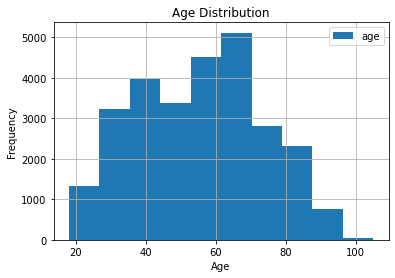

In [9]:
df_ext['age'].hist(legend=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [10]:
ks,p=stats.kstest(rvs=df_ext['age'].values,cdf='norm',alternative='two-sided', mode='auto')
ks,p

(1.0, 0.0)

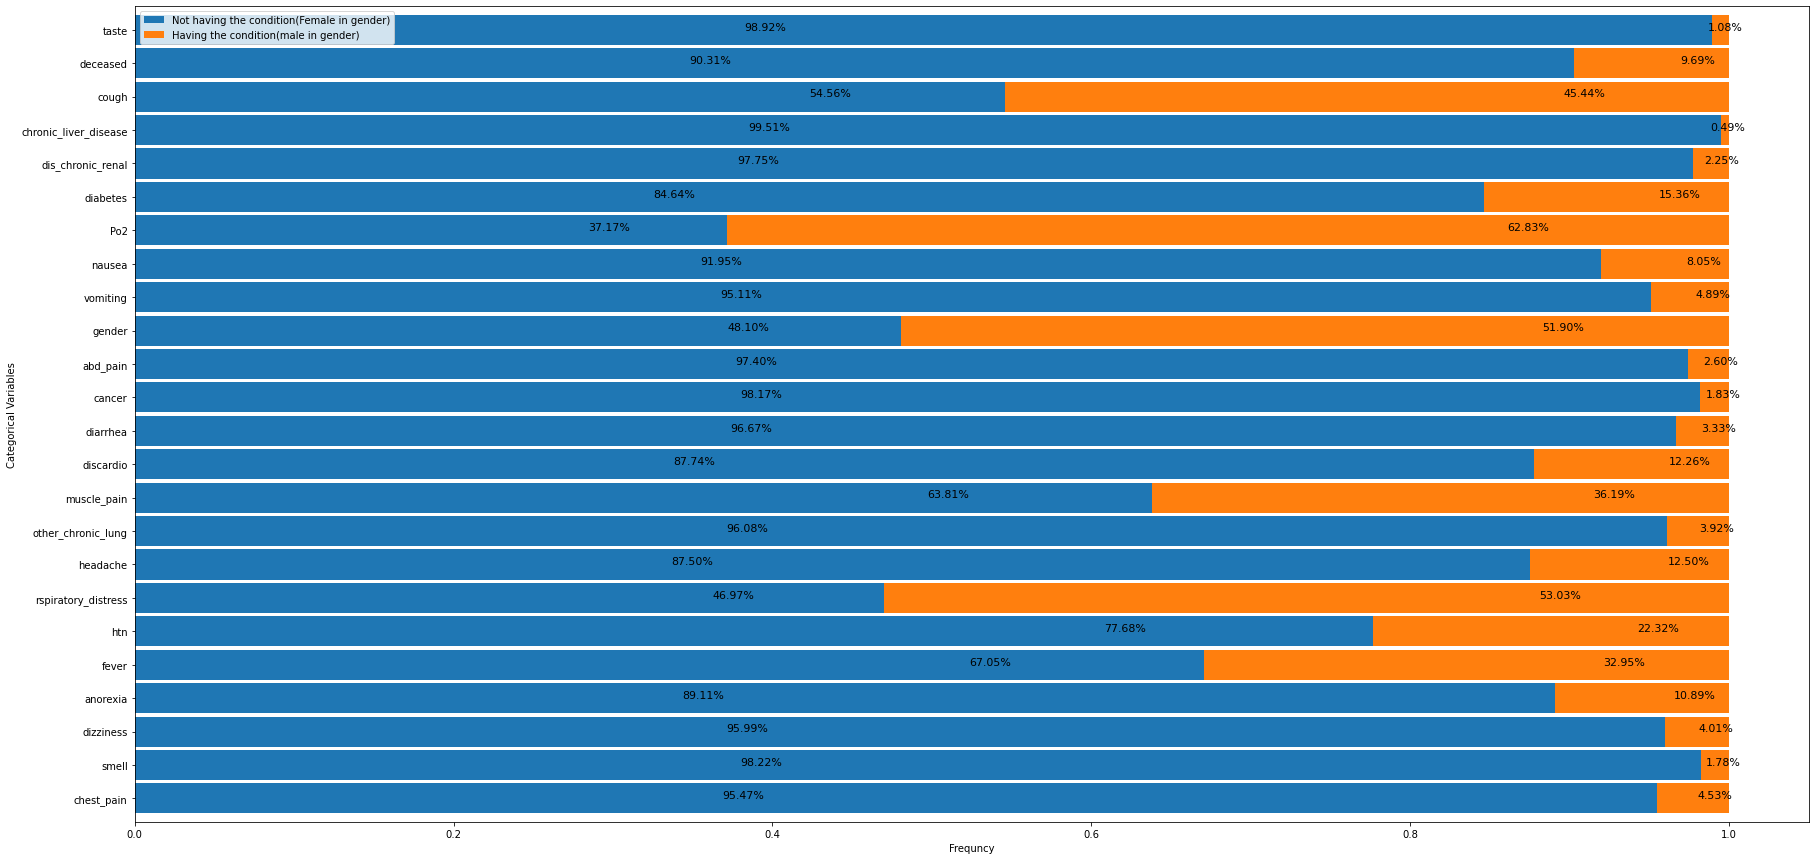

In [11]:
df_stacked=pd.DataFrame({'Not having the condition(Female in gender)':[df_ext.loc[:,i].isin([0.]).sum() for i in (set(df_ext.columns.to_list())-{'age'})]
                         ,'Having the condition(male in gender)':[df_ext.loc[:,i].isin([1.]).sum() for i in (set(df_ext.columns.to_list())-{'age'})]},
                        index=set(df_ext.columns.to_list())-{'age'})
 
df_stacked_normalized=df_stacked.div(df_stacked.sum(axis=1),axis=0)



plot=df_stacked_normalized.plot(kind='barh',stacked=True,rot=0,width=0.9,figsize=(30,15))


for p in plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if width==0:
        continue
    if width<0.8:
        plot.annotate(f'{100*width:.2f}%', (x + 0.8*width, y + height/2), ha='center',fontsize=11)
    if width>=0.8:
        plot.annotate(f'{100*width:.2f}%', (x + 0.4*width, y + height/2), ha='center',fontsize=11)
    

    
plot.set_xlabel('Frequncy')
plot.set_ylabel('Categorical Variables')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#pyreadstat.write_sav(df1,'preprocessed.sav')

In [12]:
x_train,x_test,y_train,y_test = train_test_split(df_ext.iloc[:,1:].values,df_ext.iloc[:,0].values,
                                                 test_size=0.2,stratify=df_ext.iloc[:,0].values,random_state=42)

In [13]:
x_train

array([[56.,  0.,  0., ...,  0.,  0.,  0.],
       [58.,  0.,  0., ...,  0.,  0.,  0.],
       [41.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [35.,  1.,  0., ...,  0.,  0.,  0.],
       [62.,  0.,  0., ...,  0.,  0.,  0.],
       [37.,  1.,  1., ...,  0.,  0.,  0.]])

In [14]:
x_train.shape ,x_test.shape

((22017, 24), (5505, 24))

In [3]:
def fun(x):
    for i in x:
        yield i+2

In [4]:
for i in fun([1,2,3]):
    print(i)

3
4
5


In [15]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [16]:
column_transfromer=ColumnTransformer([('minmax',MinMaxScaler(),[0]),
                                      ('pass','passthrough',np.arange(1,24))])
set_config(display='diagram')
column_transfromer

ColumnTransformer(transformers=[('minmax', MinMaxScaler(), [0]),
                                ('pass', 'passthrough',
                                 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23]))])

In [17]:
pip_analysis=Pipeline([('transformation',column_transfromer),
                       ('classification',svm.SVC(class_weight='balanced'))])
pip_analysis.fit(x_train,y_train)

preds=pip_analysis.predict(x_test)
print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds))

[[3309 1663]
 [ 122  411]] 0.718316946381915


In [18]:
pip_analysis=Pipeline([('transformation',column_transfromer),
                       ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])
pip_analysis.fit(x_train,y_train)

preds=pip_analysis.predict(x_test)
print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds))

[[3411 1561]
 [ 118  415]] 0.7323267332710458


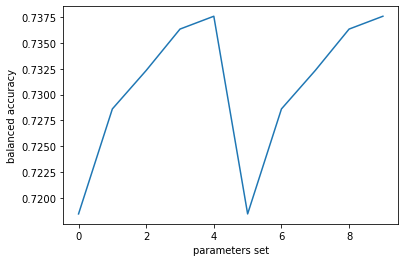

In [19]:
parameters=[(5,15),(5,35),(5,55),(5,75),(5,100),(10,15),(10,35),(10,55),(10,75),(5,100)]

scores_calculated=[]

for i,j in parameters:
    
    def Feature_selection(x,y,n_neighbors=i,random_state=42):
        return mutual_info_classif(x,y,n_neighbors=n_neighbors,
                                   discrete_features=np.arange(1,x.shape[1]),random_state=random_state)
    
    pip_analysis=Pipeline([('transformation',column_transfromer),
                           ('feature_selection',SelectPercentile(Feature_selection,percentile=j)),
                       ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])
    
    cross_val_scores=cross_val_score(pip_analysis,x_train,y_train,scoring='balanced_accuracy',cv=skf,n_jobs=-1)
    mean=np.mean(cross_val_scores)
    scores_calculated.append(mean)

plt.plot(scores_calculated)
plt.xlabel('parameters set')
plt.ylabel('balanced accuracy')
plt.show()

In [20]:



a=[]

for i,j in [(5,92),(5,100)]:
    
    def Feature_selection(x,y,n_neighbors=i,random_state=42):
        
        return mutual_info_classif(x,y,n_neighbors=n_neighbors,
                               discrete_features=np.arange(1,x.shape[1]),random_state=random_state)
    
    pip_analysis=Pipeline([('transformation',column_transfromer),
                           ('feature_selection',SelectPercentile(Feature_selection,percentile=j)),
                       ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])
    
    cross_val_scores=cross_val_score(pip_analysis,x_train,y_train,scoring='balanced_accuracy',cv=skf,n_jobs=-1)
    
    a.append(cross_val_scores)
    
    
u,p=stats.wilcoxon(a[0],a[1],zero_method='zsplit',mode='approx',alternative='less')

print (f' 92% of best features:{np.mean(a[0])}+/-{np.std(a[0])}\n\n whole features:{np.mean(a[1])}+/-{np.std(a[1])}\n\nwilcoxon:{u},{p}')

 92% of best features:0.7374136701017863+/-0.014994420595575627

 whole features:0.7375729971045266+/-0.01475540353328772

wilcoxon:23.0,0.3226938739346845


In [21]:
x_train_transfromer=column_transfromer.fit_transform(x_train)
x_test_transfromer=column_transfromer.transform(x_test)

In [22]:
x_train_transfromer[:,0].min()

0.0

In [23]:
def Feature_selection(x,y,n_neighbors=5,random_state=42):
    
    return mutual_info_classif(x,y,n_neighbors=n_neighbors,
                               discrete_features=np.arange(1,x.shape[1]),random_state=random_state)

scores=SelectPercentile(Feature_selection,percentile=92)

result_train=scores.fit_transform(x_train_transfromer,y_train)
result_test=scores.transform(x_test_transfromer)

print(result_train.shape,result_test.shape,np.argsort(scores.scores_)[::-1])

(22017, 22) (5505, 22) [ 0 16  5 23 20 19  4  3  8  2 21 17 12  6  9  1 18 14 13 22  7 10 11 15]


In [24]:
indices=np.argsort(scores.scores_)[:-23:-1]
indices

array([ 0, 16,  5, 23, 20, 19,  4,  3,  8,  2, 21, 17, 12,  6,  9,  1, 18,
       14, 13, 22,  7, 10], dtype=int64)

In [17]:
columns=np.array([                  'Age',                'Male sex',                 'Fever',
                 'Cough',           'Muscle pain',   'Respiratory distress',
                 'Loss of smell',                 'Loss of taste',       
              'Headache',             'Dizziness',            'Chest pain',
              'Abdominal pain',                'Nausea',              'Vomiting',
              'Diarrhea',              'Anorexia',               
                   'O2 saturation under 93',                'Cancer', 'Liver disease',
              'Diabetes',                    
                  'Cardiac disease',
     'Renal disease',    'Pulmonary disease',                   'Hypertension'])
columns,columns.shape

(array(['Age', 'Male sex', 'Fever', 'Cough', 'Muscle pain',
        'Respiratory distress', 'Loss of smell', 'Loss of taste',
        'Headache', 'Dizziness', 'Chest pain', 'Abdominal pain', 'Nausea',
        'Vomiting', 'Diarrhea', 'Anorexia', 'O2 saturation under 93',
        'Cancer', 'Liver disease', 'Diabetes', 'Cardiac disease',
        'Renal disease', 'Pulmonary disease', 'Hypertension'], dtype='<U22'),
 (24,))

In [18]:
x_train_f=x_train[:,[ 0,1,2,3,4,5,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23]]
x_test_f=x_test[:,[ 0,1,2,3,4,5,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23]]

In [19]:
column_transfromer_f=ColumnTransformer([('minmax',MinMaxScaler(),[0]),('pass','passthrough',np.arange(1,22))])
column_transfromer_f

ColumnTransformer(transformers=[('minmax', MinMaxScaler(), [0]),
                                ('pass', 'passthrough',
                                 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21]))])

In [20]:
col=columns[[ 0,1,2,3,4,5,6,7,8,9,10,12,13,14,16,17,18,19,20,21,22,23]]

In [21]:
col,col.shape

(array(['Age', 'Male sex', 'Fever', 'Cough', 'Muscle pain',
        'Respiratory distress', 'Loss of smell', 'Loss of taste',
        'Headache', 'Dizziness', 'Chest pain', 'Nausea', 'Vomiting',
        'Diarrhea', 'O2 saturation under 93', 'Cancer', 'Liver disease',
        'Diabetes', 'Cardiac disease', 'Renal disease',
        'Pulmonary disease', 'Hypertension'], dtype='<U22'),
 (22,))

In [22]:
df_ext.columns[[ 1,2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]]

Index(['age', 'gender', 'fever', 'cough', 'muscle_pain', 'rspiratory_distress',
       'smell', 'taste', 'headache', 'dizziness', 'chest_pain', 'nausea',
       'vomiting', 'diarrhea', 'Po2', 'cancer', 'chronic_liver_disease',
       'diabetes', 'discardio', 'dis_chronic_renal', 'other_chronic_lung',
       'htn'],
      dtype='object')

In [208]:
pd.crosstab(df_ext[['chest_pain']].values.flatten(),df_ext[['deceased']].values.flatten())

col_0,0.0,1.0
row_0,,
0.0,23708,2568
1.0,1147,99


In [42]:
for i in df_ext.columns[[ 2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]].values:
    cross_tab=pd.crosstab(df_ext[[i]].values.flatten(),df_ext[['deceased']].values.flatten())
    odds,p=stats.fisher_exact(cross_tab)
    print(f'odds ratio_{i}:{odds}\tp_value_{i}:{p}')
        

odds ratio_gender:1.2466644653282049	p_value_gender:8.02640653675379e-08
odds ratio_fever:0.6320365792676599	p_value_fever:9.866782604160377e-24
odds ratio_cough:0.5793068190628167	p_value_cough:1.8741515892980388e-38
odds ratio_muscle_pain:0.5297182362837196	p_value_muscle_pain:8.13937032942132e-45
odds ratio_rspiratory_distress:3.0354776058677313	p_value_rspiratory_distress:4.535549487779319e-141
odds ratio_smell:0.289685444313472	p_value_smell:1.9246152667555432e-08
odds ratio_taste:0.5259195646765171	p_value_taste:0.010052298144217554
odds ratio_headache:0.39919407522254935	p_value_headache:8.019409483670485e-34
odds ratio_dizziness:0.5154511697537206	p_value_dizziness:1.0317061609241823e-07
odds ratio_chest_pain:0.7968410074228585	p_value_chest_pain:0.034917841522220106
odds ratio_nausea:0.5886670509349292	p_value_nausea:5.640576028263749e-10
odds ratio_vomiting:0.7139451137384016	p_value_vomiting:0.0012901062866999041
odds ratio_diarrhea:0.4832749351589717	p_value_diarrhea:2.0107

In [43]:
clf=Pipeline([('transformation',column_transfromer_f),
                  ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])

clf.fit(x_train_f,y_train)
preds=clf.predict(x_test_f)
print(confusion_matrix(y_test,preds),balanced_accuracy_score(y_test,preds))

[[3421 1551]
 [ 117  416]] 0.7342704511115907


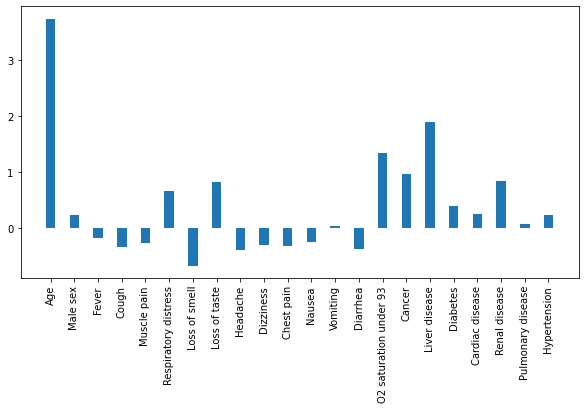

In [44]:
fig = plt.figure(figsize = (10, 5))
plt.bar(list(col),clf['classification'].coef_.flatten(),width=0.4)
plt.xticks(rotation=90)
plt.show()

In [45]:
clf=Pipeline([('transformation',column_transfromer_f),
              ('classification',LogisticRegression(class_weight='balanced',max_iter=500))])
clf.fit(x_train_f,y_train)

Pipeline(steps=[('transformation',
                 ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                  [0]),
                                                 ('pass', 'passthrough',
                                                  array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21]))])),
                ('classification',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [46]:
# permutation logistic

score_random, perm_random, pvalue_random = permutation_test_score(
  clf ,x_train_f, y_train, scoring="balanced_accuracy", cv=skf, n_permutations=100,n_jobs=-1)

In [47]:
pvalue_random

0.009900990099009901

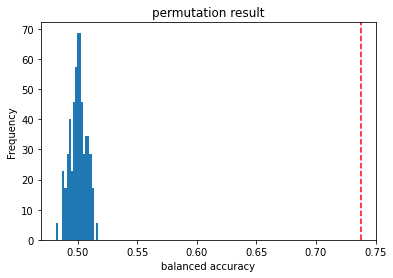

In [48]:
fig, ax = plt.subplots()
ax.hist(perm_random, bins=20, density=True)
ax.axvline(score_random, ls='--', color='r')
plt.xlabel('balanced accuracy')
plt.ylabel('Frequency')
plt.title('permutation result')
plt.show()

In [49]:
column_importance=list(col)
column_importance=np.array(column_importance)

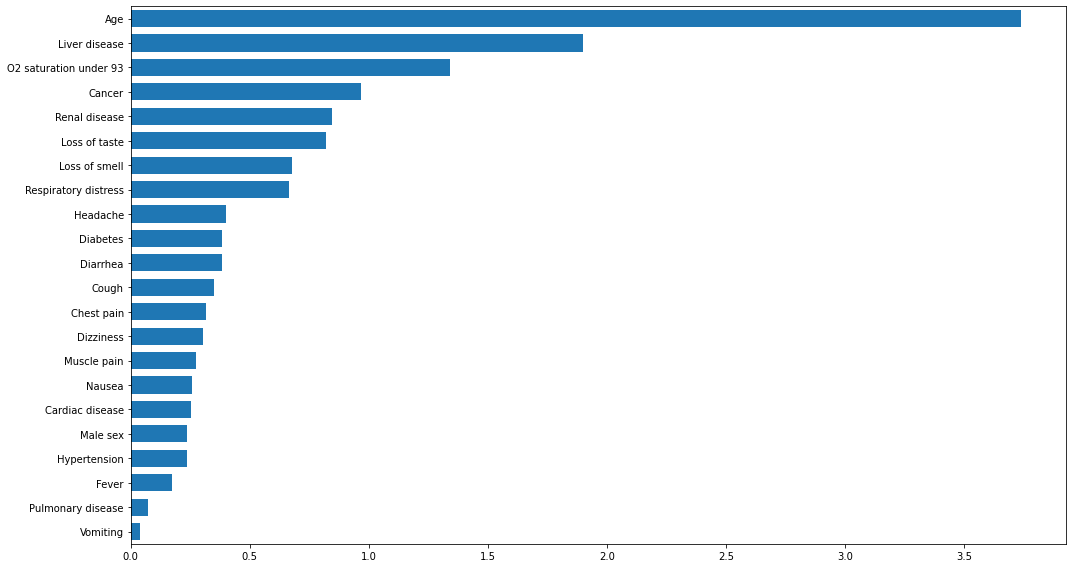

In [50]:


tree_importance_sorted_idx = np.argsort(np.abs(clf['classification'].coef_.flatten()))
tree_indices = np.arange(0, np.abs(clf['classification'].coef_.flatten()).shape[0]) + 0.5

#tree_labels= df_ext.columns.array[[0,1,4,5,6,10,19,22,27,31,32]]
#tree_labels=tree_labels[1:]

#tree_labels1=tree_labels[:-1]
#tree_labels2=np.append(tree_labels1,['epil0','epil1','epil2','epil3'])

fig,ax1 = plt.subplots(figsize=(15, 8))

ax1.barh(tree_indices,
         np.abs(clf['classification'].coef_.flatten())[tree_importance_sorted_idx], height=0.7)

ax1.set_yticks(tree_indices)
ax1.set_yticklabels(column_importance[tree_importance_sorted_idx])
ax1.set_ylim((0,np.abs(clf['classification'].coef_.flatten()).shape[0]))


fig.tight_layout()
plt.show()

In [51]:

mask_discrete=np.ones(x_train_f.shape[1],dtype=bool)
mask_discrete[0]=False

array_features=mutual_info_regression(x_train_f,x_train_f[:,0],
                                 discrete_features=mask_discrete,n_neighbors=5,random_state=42)

array_features=array_features.reshape(1,-1)



for i in range(1,x_train_f.shape[1]):
    
    
    mi_score=mutual_info_classif(x_train_f,x_train_f[:,i],
                        discrete_features=mask_discrete,n_neighbors=5,random_state=42)
    
    mi_score=mi_score.reshape(1,-1)
    
    array_features=np.append(array_features,mi_score,axis=0)
    
    
print(array_features.shape)

(22, 22)


In [52]:
df_odds=pd.DataFrame(np.zeros(shape=(21,21)),index=df_ext.columns[[ 2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]].values,
                     columns=df_ext.columns[[ 2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]].values)

for s,i in enumerate(df_ext.columns[[ 2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]].values):
    for b,j in enumerate(df_ext.columns[[ 2,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20,21,22,23,24]].values):
        cross_tab=pd.crosstab(df_ext[[i]].values.flatten(),df_ext[[j]].values.flatten())
        odds,p=stats.fisher_exact(cross_tab)
        df_odds.iloc[s,b]=odds
        
        
df_odds

,gender,fever,cough,muscle_pain,rspiratory_distress,smell,taste,headache,dizziness,chest_pain,...,vomiting,diarrhea,Po2,cancer,chronic_liver_disease,diabetes,discardio,dis_chronic_renal,other_chronic_lung,htn
gender,inf,1.114483,0.928096,0.901172,1.060561,0.705587,0.685407,0.861654,0.879446,0.886771,...,0.756354,1.041738,1.053268,1.084001,1.269500,0.678175,0.967109,1.402278,0.825796,0.625437
fever,1.114483,inf,1.330614,1.758477,0.494074,1.507377,2.167039,1.526579,1.216770,0.683351,...,1.397358,1.746740,0.851878,0.913411,0.796390,0.979017,0.951430,0.995363,0.873828,0.946798
cough,0.928096,1.330614,inf,1.665622,0.876531,1.260974,1.537850,1.233540,0.927661,1.117241,...,0.691452,0.784051,1.077594,0.421094,0.705117,1.046360,0.911564,0.686578,0.996721,0.993399
muscle_pain,0.901172,1.758477,1.665622,inf,0.517417,2.061638,2.571068,2.346026,1.232747,1.059678,...,1.121027,1.411263,0.842851,0.383765,0.459821,0.986911,0.954338,0.725210,0.702355,0.954018
rspiratory_distress,1.060561,0.494074,0.876531,0.517417,inf,0.336549,0.485250,0.466876,0.545339,1.049316,...,0.490497,0.438248,3.717933,1.210076,0.898461,1.337397,1.415231,1.107248,1.853815,1.499000
smell,0.705587,1.507377,1.260974,2.061638,0.336549,inf,192.454106,2.957051,2.349346,1.281646,...,1.000216,1.640394,0.312191,0.436717,0.827160,0.431191,0.395658,0.353383,0.823677,0.433859
taste,0.685407,2.167039,1.537850,2.571068,0.485250,192.454106,inf,2.886053,2.934800,1.525579,...,1.406217,1.882449,0.492742,0.360401,0.680687,0.568654,0.484662,0.440000,0.501278,0.552105
headache,0.861654,1.526579,1.233540,2.346026,0.466876,2.957051,2.886053,inf,5.922577,1.324844,...,1.741227,1.735679,0.655930,0.454719,0.874234,0.832139,0.780361,0.664785,0.763834,0.844372
dizziness,0.879446,1.216770,0.927661,1.232747,0.545339,2.349346,2.934800,5.922577,inf,1.336859,...,2.902438,1.617918,0.772372,0.382261,1.113610,1.069392,1.113348,1.009030,0.488332,1.002960
chest_pain,0.886771,0.683351,1.117241,1.059678,1.049316,1.281646,1.525579,1.324844,1.336859,inf,...,1.318170,0.934679,0.979343,0.466779,0.810327,1.240592,2.024052,1.515435,1.231995,1.439544


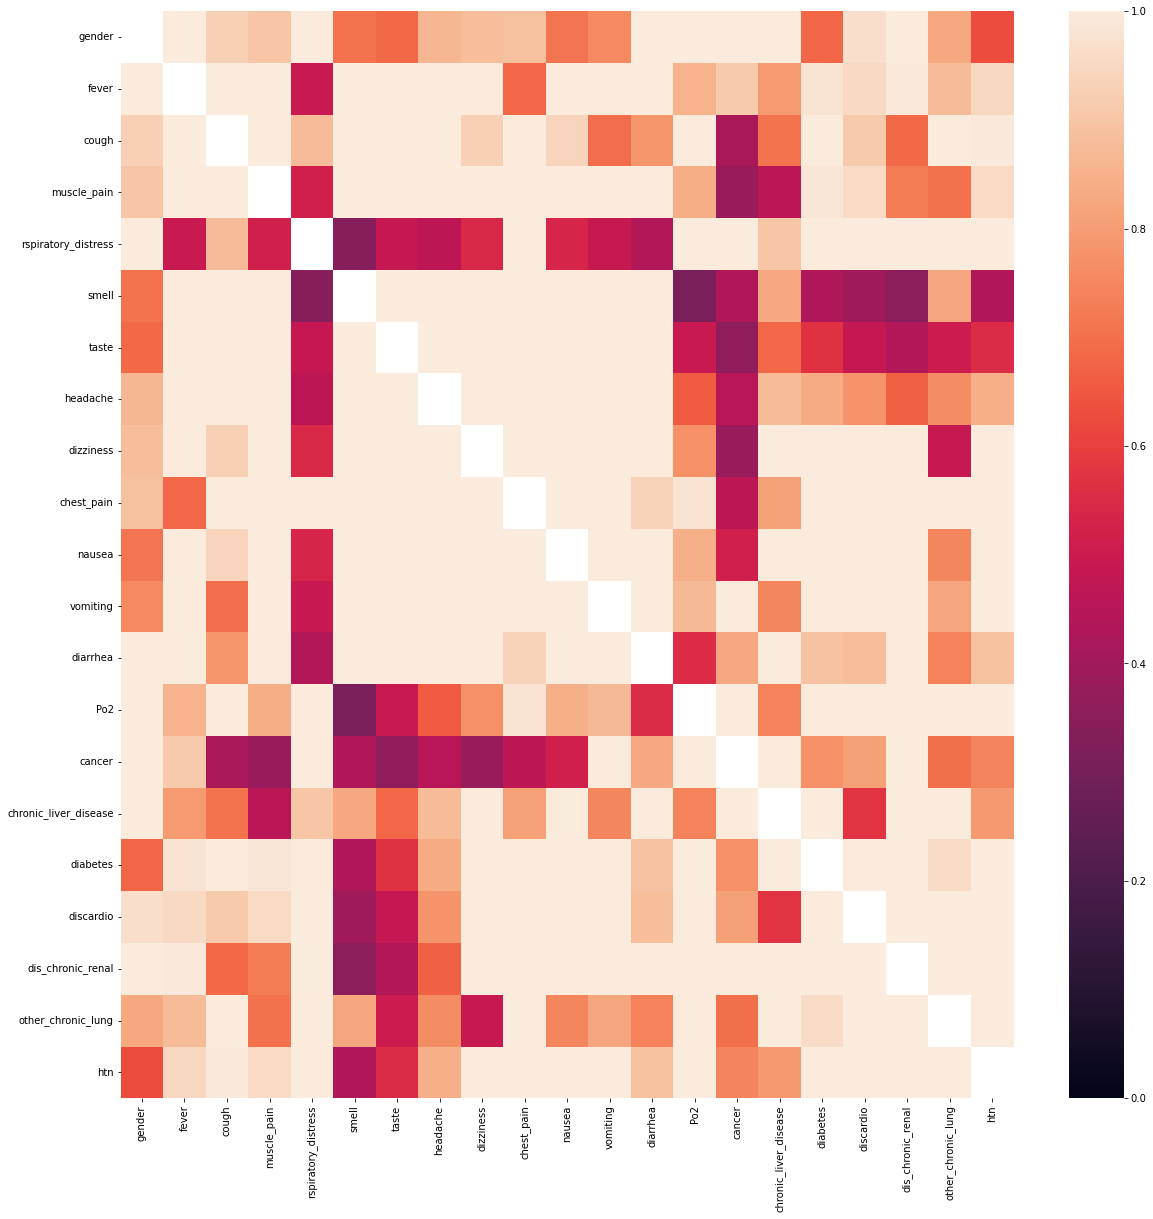

In [54]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_odds,ax=ax,vmin=0,vmax=1)
plt.show()

In [55]:
df_features=pd.DataFrame(array_features,
                         index=col,
                         columns=col)

In [56]:
df_features

,Age,Male sex,Fever,Cough,Muscle pain,Respiratory distress,Loss of smell,Loss of taste,Headache,Dizziness,...,Vomiting,Diarrhea,O2 saturation under 93,Cancer,Liver disease,Diabetes,Cardiac disease,Renal disease,Pulmonary disease,Hypertension
Age,4.249784,0.001314,2.987058e-03,7.485767e-03,0.000000e+00,0.013310,5.843596e-03,0.002581,0.003601,0.000000e+00,...,0.000287,1.043348e-03,0.058633,0.001880,3.337387e-04,3.532214e-02,0.046241,3.887687e-03,2.099357e-03,7.829741e-02
Male sex,0.000184,0.692540,4.413416e-04,9.888657e-05,3.288024e-04,0.000176,2.903504e-04,0.000174,0.000424,1.267845e-04,...,0.000452,8.092692e-06,0.000048,0.000028,7.920693e-05,2.810175e-03,0.000023,3.283440e-04,1.764991e-04,5.052671e-03
Fever,0.003119,0.000441,6.346085e-01,2.390788e-03,8.428855e-03,0.012785,3.557821e-04,0.000629,0.002283,1.525442e-04,...,0.000662,1.363423e-03,0.000737,0.000021,1.013985e-05,1.888479e-05,0.000008,7.869178e-07,2.883284e-05,6.156285e-05
Cough,0.004890,0.000099,2.390788e-03,6.891184e-01,7.061875e-03,0.000531,8.832812e-05,0.000199,0.000609,8.081933e-06,...,0.000944,3.025263e-04,0.000148,0.001525,1.328595e-04,2.362527e-05,0.000154,5.130173e-04,5.193536e-07,1.920367e-05
Muscle pain,0.005734,0.000329,8.428855e-03,7.061875e-03,6.531795e-01,0.012157,1.339804e-03,0.001448,0.009670,2.676051e-04,...,0.000071,4.601863e-04,0.000699,0.001423,2.586474e-04,1.455547e-07,0.000002,3.244253e-04,4.289740e-04,1.144017e-05
Respiratory distress,0.012653,0.000176,1.278515e-02,5.310090e-04,1.215741e-02,0.691247,2.255776e-03,0.000545,0.007865,1.561094e-03,...,0.002761,2.392145e-03,0.047114,0.000050,5.231119e-06,1.370482e-03,0.001313,3.471217e-06,1.575316e-03,3.347841e-03
Loss of smell,0.006464,0.000290,3.557821e-04,8.832812e-05,1.339804e-03,0.002256,9.136324e-02,0.025722,0.001982,4.482533e-04,...,0.000002,2.137003e-04,0.002922,0.000078,1.696670e-07,5.173518e-04,0.000627,1.360497e-04,3.368580e-06,7.555576e-04
Loss of taste,0.003106,0.000174,6.288988e-04,1.990149e-04,1.447556e-03,0.000545,2.572243e-02,0.059280,0.001228,4.328916e-04,...,0.000002,1.490311e-04,0.000544,0.000036,1.178019e-06,1.552382e-04,0.000178,3.069699e-05,1.288998e-04,2.479804e-04
Headache,0.004648,0.000424,2.283369e-03,6.088108e-04,9.670311e-03,0.007865,1.982009e-03,0.001228,0.381330,1.265419e-02,...,0.000801,6.037513e-04,0.002125,0.000544,2.732011e-05,1.917158e-04,0.000287,1.758573e-04,1.233473e-04,1.489450e-04
Dizziness,0.000000,0.000127,1.525442e-04,8.081933e-06,2.676051e-04,0.001561,4.482533e-04,0.000433,0.012654,1.675571e-01,...,0.001693,6.456557e-05,0.000284,0.000154,2.106545e-06,1.896688e-05,0.000004,8.629236e-06,2.789226e-04,1.802089e-07


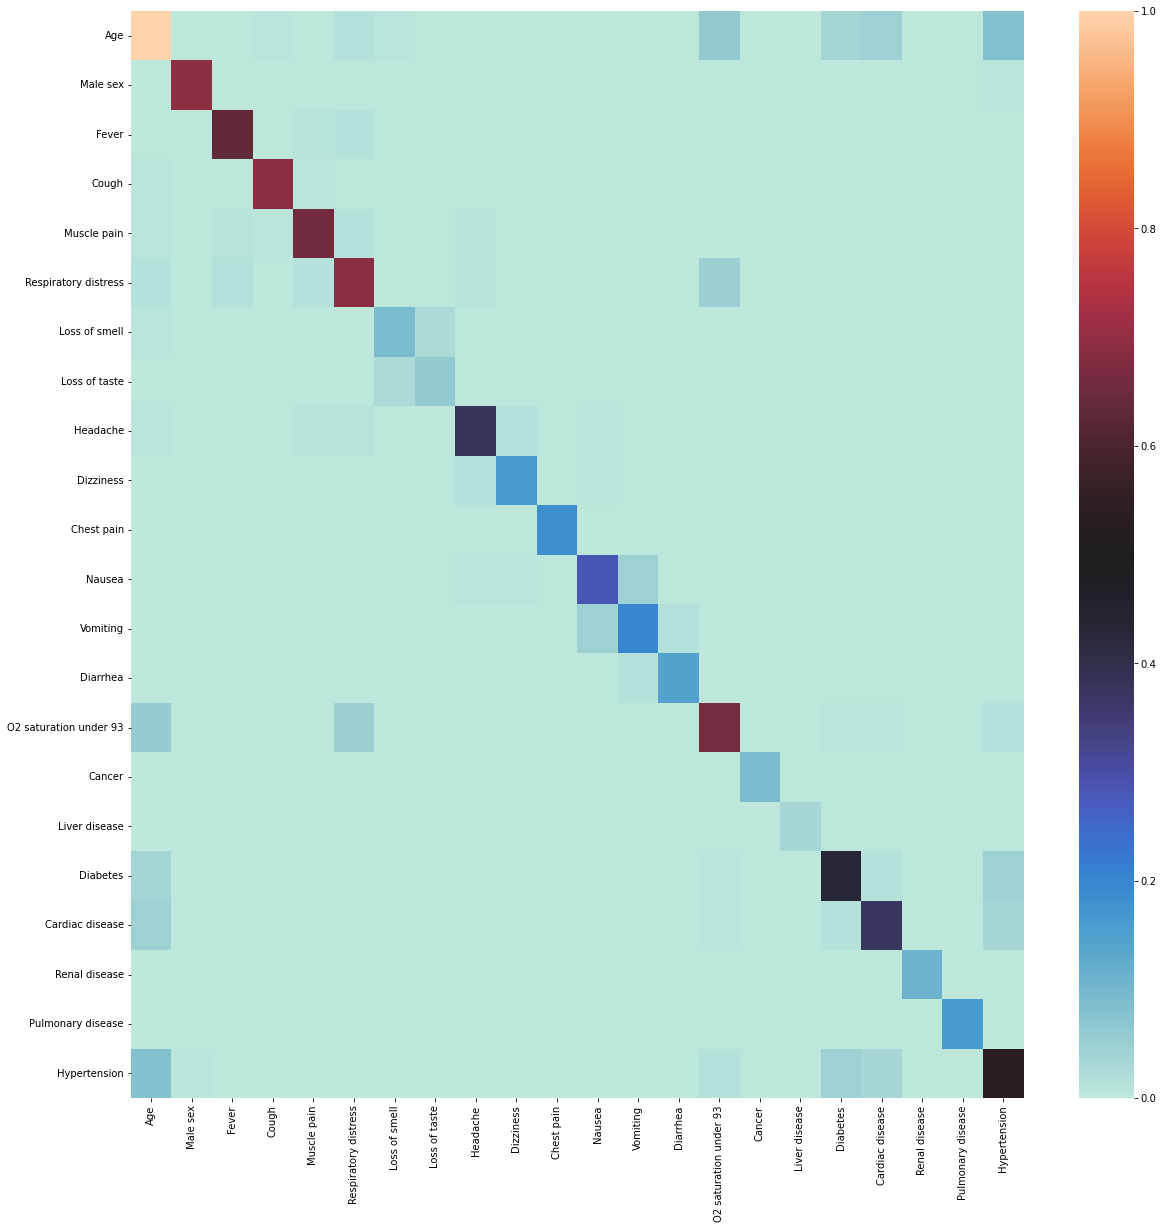

In [57]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_features,ax=ax,vmin=0.0,vmax=1.0,center=0.5)
plt.show()

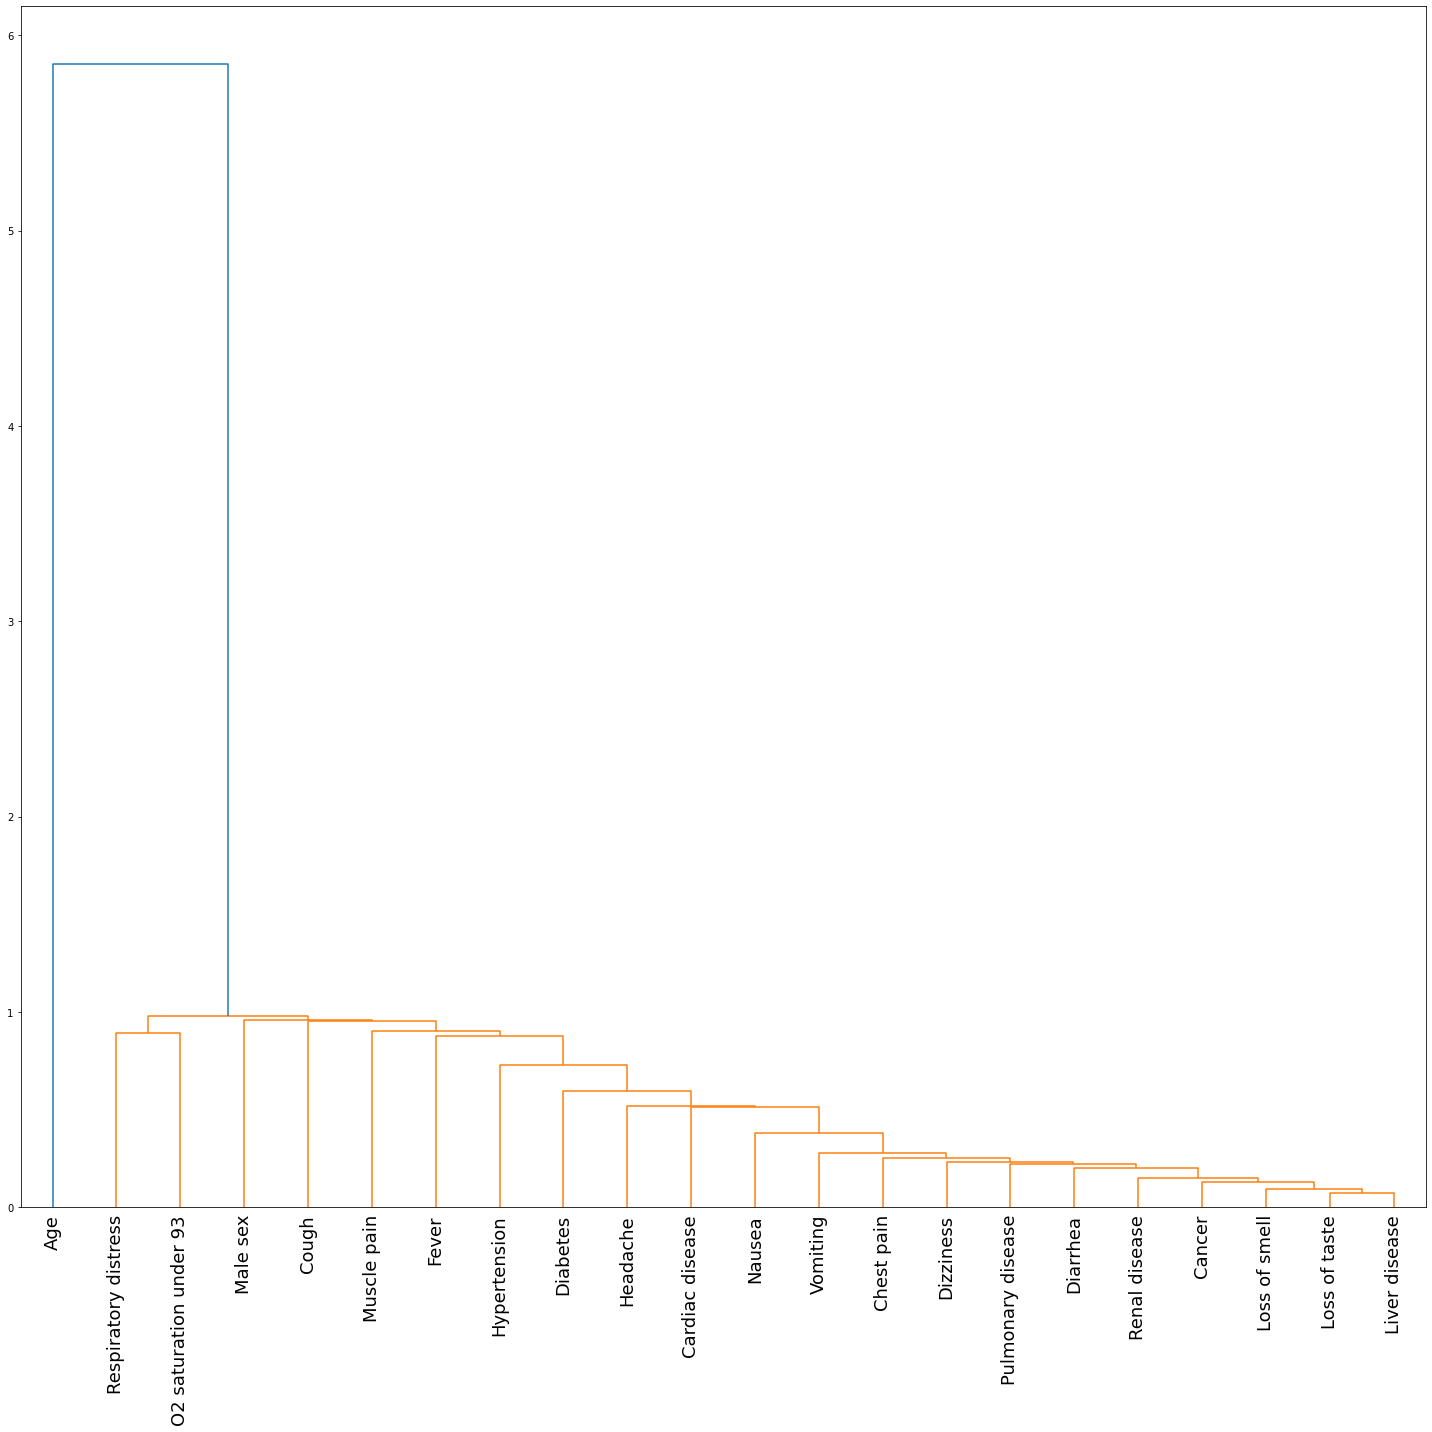

In [58]:

fig,ax1 = plt.subplots(figsize=(20, 20))


ax1.set_xticks(np.arange(0,array_features.shape[1]))

corr_linkage = hierarchy.ward(array_features)


dendro = hierarchy.dendrogram(
    corr_linkage, labels=df_features.columns.to_list(), ax=ax1, leaf_rotation=90)



ax1.set_xticklabels(dendro['ivl'],fontsize=18)

fig.tight_layout()

plt.show()

In [59]:
df_features.columns.array

<PandasArray>
[                   'Age',               'Male sex',                  'Fever',
                  'Cough',            'Muscle pain',   'Respiratory distress',
          'Loss of smell',          'Loss of taste',               'Headache',
              'Dizziness',             'Chest pain',                 'Nausea',
               'Vomiting',               'Diarrhea', 'O2 saturation under 93',
                 'Cancer',          'Liver disease',               'Diabetes',
        'Cardiac disease',          'Renal disease',      'Pulmonary disease',
           'Hypertension']
Length: 22, dtype: object

In [60]:
cluster_ids = hierarchy.fcluster(corr_linkage,0.95, criterion='distance')
cluster_ids

array([5, 4, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [61]:
feature_mi=mutual_info_classif(x_train_f,y_train, discrete_features=mask_discrete,random_state=42)

sorted_features=np.argsort(feature_mi)[::-1]

print(df_features.columns.array[sorted_features],'\n',feature_mi[sorted_features])

<PandasArray>
[                   'Age', 'O2 saturation under 93',   'Respiratory distress',
           'Hypertension',        'Cardiac disease',               'Diabetes',
            'Muscle pain',                  'Cough',               'Headache',
                  'Fever',          'Renal disease',                 'Cancer',
                 'Nausea',          'Loss of smell',              'Dizziness',
               'Male sex',          'Liver disease',               'Diarrhea',
               'Vomiting',      'Pulmonary disease',          'Loss of taste',
             'Chest pain']
Length: 22, dtype: object 
 [0.03580337 0.02167167 0.01159172 0.00779894 0.0052752  0.00401607
 0.00308949 0.0029198  0.00285786 0.00173517 0.00123591 0.00108461
 0.00079674 0.00063919 0.00055235 0.00055074 0.00051787 0.00050113
 0.00021596 0.00018742 0.00012623 0.00012074]


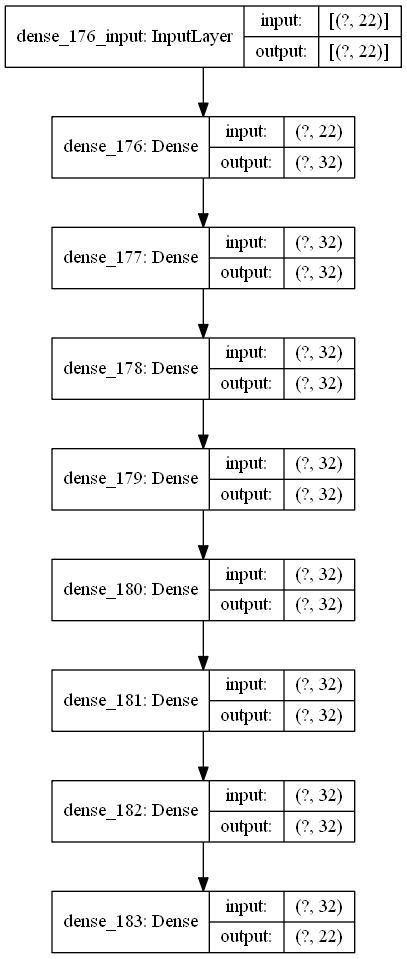

In [165]:
#Autoencoder for outlier detection with all features(35) and for dimensionality reduction (26)

def create_model():
    model=tf.keras.Sequential([layers.Dense(32,activation='relu',input_shape=(22,)),

                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(32,activation='relu'),
                            
                               layers.Dense(22,activation='sigmoid')])
    model.compile('adam',loss='mean_squared_logarithmic_error',metrics=['mse'])
    return model
model=create_model()
tf.keras.utils.plot_model(model,show_shapes=True)

In [166]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 32)                736       
_________________________________________________________________
dense_177 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_178 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_179 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_180 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_181 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_182 (Dense)            (None, 32)              

In [167]:
def x_generator(x,batch_size,shuffle=True):
    batch_index=0
    n=x.shape[0]
    while True:
        if batch_index==0:
            index_array=np.arange(n)
            if shuffle:
                index_array = np.random.permutation(n)
        current_index=(batch_index*batch_size)%n
        
        if n>=current_index+batch_size:
            current_batch_size=batch_size
            
        else:
            current_batch_size=n-current_index
            batch_index=0
            
        batch_x=x[index_array[current_index:current_index+current_batch_size]]
        
        yield batch_x
        
        

def mixed_generator(x,batch_size,swaprate=0.3,shuffle=True):
    num_value=x.shape[1]
    num_swap=int(num_value*swaprate)
    
    gen1=x_generator(x,batch_size,shuffle)
    gen2=x_generator(x,batch_size,shuffle)
    
    while True:
        batch1=next(gen1)
        batch2=next(gen2)
        new_batch=batch1.copy()
        
        for i in range(batch1.shape[0]):
            swap_idx=np.random.choice(num_value,num_swap,replace=False)
            
            new_batch[i,swap_idx]=batch2[i,swap_idx]
            
        yield(new_batch,batch1)

In [168]:
callback=EarlyStopping(monitor='val_loss',patience=17,restore_best_weights=True)

a=[]

for train_index, test_index in skf.split(x_train_f, y_train):
    
    print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_f, X_test_f = x_train_f[train_index], x_train_f[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    
    x_train_auto=column_transfromer_f.fit_transform(X_train_f)
    x_test_auto=column_transfromer_f.transform(X_test_f)
    
    gen_train=mixed_generator(x_train_auto,batch_size=128)
    
    model= create_model()
    
    history=model.fit(gen_train,epochs=500,steps_per_epoch=np.ceil(x_train_f.shape[0]/128),
                  validation_data=(x_test_auto,x_test_auto),callbacks=[callback])
    
    x_pred=model.predict(x_test_auto)
    errors=tf.keras.losses.msle(x_pred,x_test_auto)
    
    mean_loss=np.mean(errors.numpy())
    
    a.append(mean_loss)

print(a)

TRAIN: [    0     1     2 ... 22013 22014 22016] TEST: [   18    23    39 ... 22003 22004 22015]
Epoch 1/500
173/173 [==============================] - 1s 5ms/step - loss: 0.0703 - mse: 0.1358 - val_loss: 0.0391 - val_mse: 0.0832
Epoch 2/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0376 - mse: 0.0800 - val_loss: 0.0223 - val_mse: 0.0477
Epoch 3/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0325 - mse: 0.0688 - val_loss: 0.0196 - val_mse: 0.0428
Epoch 4/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0312 - mse: 0.0660 - val_loss: 0.0164 - val_mse: 0.0358
Epoch 5/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0302 - mse: 0.0636 - val_loss: 0.0148 - val_mse: 0.0325
Epoch 6/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0289 - mse: 0.0610 - val_loss: 0.0139 - val_mse: 0.0322 - loss: 0.0290 - mse: 0.0
Epoch 7/500
173/173 [==============================] - 1s 4ms/step - loss: 0.02

Epoch 60/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0054 - val_mse: 0.0123
Epoch 61/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0052 - val_mse: 0.0127
Epoch 62/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0056 - val_mse: 0.0127
Epoch 63/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0515 - val_loss: 0.0055 - val_mse: 0.0138
Epoch 64/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0515 - val_loss: 0.0060 - val_mse: 0.0160
Epoch 65/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0053 - val_mse: 0.0135
Epoch 66/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0518 - val_loss: 0.0060 - val_mse: 0.0144
Epoch 67/500
173/173 [==============================] - 1s 4ms

Epoch 14/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0275 - mse: 0.0579 - val_loss: 0.0108 - val_mse: 0.0246
Epoch 15/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0273 - mse: 0.0575 - val_loss: 0.0108 - val_mse: 0.0239
Epoch 16/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0271 - mse: 0.0571 - val_loss: 0.0099 - val_mse: 0.0223
Epoch 17/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0269 - mse: 0.0568 - val_loss: 0.0098 - val_mse: 0.0223
Epoch 18/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0268 - mse: 0.0565 - val_loss: 0.0090 - val_mse: 0.0199
Epoch 19/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0266 - mse: 0.0561 - val_loss: 0.0086 - val_mse: 0.0196
Epoch 20/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0266 - mse: 0.0561 - val_loss: 0.0092 - val_mse: 0.0218
Epoch 21/500
173/173 [==============================] - 1s 4ms

Epoch 75/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0240 - mse: 0.0505 - val_loss: 0.0053 - val_mse: 0.0135
Epoch 76/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0512 - val_loss: 0.0052 - val_mse: 0.0127
Epoch 77/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0509 - val_loss: 0.0054 - val_mse: 0.0137
Epoch 78/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0513 - val_loss: 0.0056 - val_mse: 0.0138
Epoch 79/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0507 - val_loss: 0.0049 - val_mse: 0.0110
Epoch 80/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0240 - mse: 0.0505 - val_loss: 0.0055 - val_mse: 0.0132
Epoch 81/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0509 - val_loss: 0.0047 - val_mse: 0.0112
Epoch 82/500
173/173 [==============================] - 1s 4ms

173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0049 - val_mse: 0.0116
Epoch 82/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0515 - val_loss: 0.0053 - val_mse: 0.0132
Epoch 83/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0048 - val_mse: 0.0116
Epoch 84/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0508 - val_loss: 0.0050 - val_mse: 0.0122
Epoch 85/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0512 - val_loss: 0.0048 - val_mse: 0.0111
Epoch 86/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0513 - val_loss: 0.0047 - val_mse: 0.0115
Epoch 87/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0240 - mse: 0.0505 - val_loss: 0.0050 - val_mse: 0.0124
Epoch 88/500
173/173 [==============================] - 1s 4ms/step - loss:

173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0518 - val_loss: 0.0053 - val_mse: 0.0132
Epoch 92/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0519 - val_loss: 0.0053 - val_mse: 0.0133
Epoch 93/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0515 - val_loss: 0.0051 - val_mse: 0.0121
Epoch 94/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0521 - val_loss: 0.0050 - val_mse: 0.0119
Epoch 95/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0520 - val_loss: 0.0051 - val_mse: 0.0124
Epoch 96/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0521 - val_loss: 0.0053 - val_mse: 0.0136
Epoch 97/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0052 - val_mse: 0.0135
Epoch 98/500
173/173 [==============================] - 1s 4ms/step - loss:

Epoch 96/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0515 - val_loss: 0.0054 - val_mse: 0.0131
Epoch 97/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0248 - mse: 0.0522 - val_loss: 0.0056 - val_mse: 0.0130
Epoch 98/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0248 - mse: 0.0522 - val_loss: 0.0052 - val_mse: 0.0115
Epoch 99/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0248 - mse: 0.0523 - val_loss: 0.0051 - val_mse: 0.0118
Epoch 100/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0248 - mse: 0.0522 - val_loss: 0.0055 - val_mse: 0.0133
Epoch 101/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0053 - val_mse: 0.0115
Epoch 102/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0515 - val_loss: 0.0055 - val_mse: 0.0124
Epoch 103/500
173/173 [==============================] - 1s

Epoch 156/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0511 - val_loss: 0.0047 - val_mse: 0.0109
Epoch 157/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0511 - val_loss: 0.0054 - val_mse: 0.0140
Epoch 158/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0511 - val_loss: 0.0050 - val_mse: 0.0113
Epoch 159/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0512 - val_loss: 0.0049 - val_mse: 0.0106
Epoch 160/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0513 - val_loss: 0.0050 - val_mse: 0.0118
Epoch 161/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0512 - val_loss: 0.0050 - val_mse: 0.0117
Epoch 162/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0513 - val_loss: 0.0047 - val_mse: 0.0104
Epoch 163/500
173/173 [==============================] 

173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0048 - val_mse: 0.0113
Epoch 107/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0050 - val_mse: 0.0118
Epoch 108/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0048 - val_mse: 0.0111
Epoch 109/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0053 - val_mse: 0.0128
Epoch 110/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0054 - val_mse: 0.0123
Epoch 111/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0047 - val_mse: 0.0117
Epoch 112/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0052 - val_mse: 0.0118
Epoch 113/500
173/173 [==============================] - 1s 4ms/step 

173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0521 - val_loss: 0.0054 - val_mse: 0.0124
Epoch 68/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0056 - val_mse: 0.0141
Epoch 69/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0517 - val_loss: 0.0054 - val_mse: 0.0122
Epoch 70/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0520 - val_loss: 0.0054 - val_mse: 0.0133
Epoch 71/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0519 - val_loss: 0.0053 - val_mse: 0.0125
Epoch 72/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0517 - val_loss: 0.0053 - val_mse: 0.0127
Epoch 73/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0518 - val_loss: 0.0054 - val_mse: 0.0126
Epoch 74/500
173/173 [==============================] - 1s 4ms/step - loss:

173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0055 - val_mse: 0.0141
Epoch 129/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0509 - val_loss: 0.0052 - val_mse: 0.0130
Epoch 130/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0511 - val_loss: 0.0051 - val_mse: 0.0122
Epoch 131/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0520 - val_loss: 0.0049 - val_mse: 0.0110
Epoch 132/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0511 - val_loss: 0.0050 - val_mse: 0.0118
Epoch 133/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0511 - val_loss: 0.0054 - val_mse: 0.0140
Epoch 134/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0050 - val_mse: 0.0118
Epoch 135/500
173/173 [==============================] - 1s 4ms/step 

173/173 [==============================] - 1s 4ms/step - loss: 0.0388 - mse: 0.0822 - val_loss: 0.0255 - val_mse: 0.0551
Epoch 3/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0343 - mse: 0.0726 - val_loss: 0.0205 - val_mse: 0.0434
Epoch 4/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0319 - mse: 0.0675 - val_loss: 0.0170 - val_mse: 0.0359
Epoch 5/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0307 - mse: 0.0648 - val_loss: 0.0149 - val_mse: 0.0326
Epoch 6/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0297 - mse: 0.0627 - val_loss: 0.0135 - val_mse: 0.0300
Epoch 7/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0290 - mse: 0.0612 - val_loss: 0.0121 - val_mse: 0.0270
Epoch 8/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0282 - mse: 0.0594 - val_loss: 0.0116 - val_mse: 0.0245
Epoch 9/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0279

173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0519 - val_loss: 0.0053 - val_mse: 0.0132
Epoch 64/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0055 - val_mse: 0.0128
Epoch 65/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0511 - val_loss: 0.0052 - val_mse: 0.0126
Epoch 66/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0519 - val_loss: 0.0055 - val_mse: 0.0131
Epoch 67/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0050 - val_mse: 0.0125
Epoch 68/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0518 - val_loss: 0.0048 - val_mse: 0.0113
Epoch 69/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0053 - val_mse: 0.0127
Epoch 70/500
173/173 [==============================] - 1s 4ms/step - loss:

173/173 [==============================] - 1s 4ms/step - loss: 0.0275 - mse: 0.0580 - val_loss: 0.0106 - val_mse: 0.0242
Epoch 17/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0272 - mse: 0.0573 - val_loss: 0.0101 - val_mse: 0.0226: 0s - loss: 0.0272 - mse: 0.
Epoch 18/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0269 - mse: 0.0567 - val_loss: 0.0095 - val_mse: 0.0208
Epoch 19/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0268 - mse: 0.0565 - val_loss: 0.0096 - val_mse: 0.0218
Epoch 20/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0267 - mse: 0.0562 - val_loss: 0.0097 - val_mse: 0.0226
Epoch 21/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0265 - mse: 0.0558 - val_loss: 0.0092 - val_mse: 0.0202
Epoch 22/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0268 - mse: 0.0565 - val_loss: 0.0091 - val_mse: 0.0214
Epoch 23/500
173/173 [========================

Epoch 77/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0059 - val_mse: 0.0143
Epoch 78/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0515 - val_loss: 0.0055 - val_mse: 0.0133
Epoch 79/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0054 - val_mse: 0.0122
Epoch 80/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0517 - val_loss: 0.0055 - val_mse: 0.0123
Epoch 81/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0243 - mse: 0.0513 - val_loss: 0.0053 - val_mse: 0.0125
Epoch 82/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0050 - val_mse: 0.0113
Epoch 83/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0053 - val_mse: 0.0124
Epoch 84/500
173/173 [==============================] - 1s 4ms

173/173 [==============================] - 1s 4ms/step - loss: 0.0366 - mse: 0.0772 - val_loss: 0.0219 - val_mse: 0.0476
Epoch 4/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0328 - mse: 0.0691 - val_loss: 0.0179 - val_mse: 0.0397
Epoch 5/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0318 - mse: 0.0670 - val_loss: 0.0164 - val_mse: 0.0344
Epoch 6/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0305 - mse: 0.0643 - val_loss: 0.0154 - val_mse: 0.0340
Epoch 7/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0306 - mse: 0.0644 - val_loss: 0.0151 - val_mse: 0.0318
Epoch 8/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0303 - mse: 0.0638 - val_loss: 0.0143 - val_mse: 0.0315
Epoch 9/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0296 - mse: 0.0623 - val_loss: 0.0131 - val_mse: 0.0288
Epoch 10/500
173/173 [==============================] - 1s 4ms/step - loss: 0.029

Epoch 64/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0247 - mse: 0.0521 - val_loss: 0.0056 - val_mse: 0.0136
Epoch 65/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0248 - mse: 0.0523 - val_loss: 0.0055 - val_mse: 0.0128
Epoch 66/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0054 - val_mse: 0.0130
Epoch 67/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0517 - val_loss: 0.0053 - val_mse: 0.0124
Epoch 68/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0246 - mse: 0.0518 - val_loss: 0.0056 - val_mse: 0.0129
Epoch 69/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0245 - mse: 0.0516 - val_loss: 0.0054 - val_mse: 0.0136
Epoch 70/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0244 - mse: 0.0514 - val_loss: 0.0049 - val_mse: 0.0120
Epoch 71/500
173/173 [==============================] - 1s 4ms

Epoch 125/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0510 - val_loss: 0.0046 - val_mse: 0.0116
Epoch 126/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0240 - mse: 0.0505 - val_loss: 0.0045 - val_mse: 0.0114
Epoch 127/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0241 - mse: 0.0508 - val_loss: 0.0051 - val_mse: 0.0127
Epoch 128/500
173/173 [==============================] - 1s 4ms/step - loss: 0.0242 - mse: 0.0511 - val_loss: 0.0045 - val_mse: 0.0106
[0.00463961819571771, 0.004593912159715902, 0.004389566275783193, 0.004841575153807181, 0.004563018853964174, 0.004478896203971419, 0.004570816640126292, 0.004169812255424115, 0.0045072038760155374, 0.004320856945330364]


In [169]:
loss_array=np.array(a)
mean_epochs_loss=np.mean(loss_array)
std_epochs=np.std(loss_array)
print(mean_epochs_loss,std_epochs)

0.0045075276559855895 0.0001752755232852178


In [170]:
model.save('auto_encoder.h5')

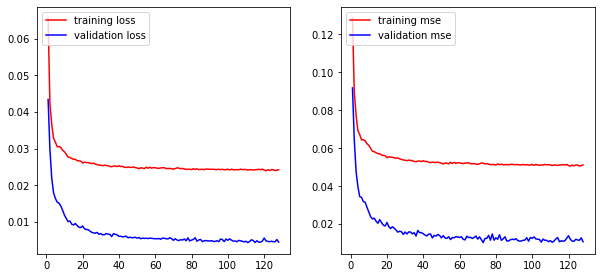

In [171]:
train_loss=history.history['loss']
epochs=np.arange(1,len(train_loss)+1)
val_loss=history.history['val_loss']

train_mse=history.history['mse']
val_mse=history.history['val_mse']

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(epochs,train_loss,'r',label='training loss')
plt.plot(epochs,val_loss,'b',label='validation loss')
plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt.plot(epochs,train_mse,'r',label='training mse')
plt.plot(epochs,val_mse,'b',label='validation mse')
plt.legend(loc='upper left')
plt.show()

In [23]:
model=load_model('auto_encoder.h5')

In [24]:
x_train_x=column_transfromer_f.fit_transform(x_train_f)
x_test_x=column_transfromer_f.transform(x_test_f)

In [147]:
with open('column_preprocessing.sav','wb') as f:
    pickle.dump(column_transfromer_f,f)

#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [25]:
class denoising:
    
    def __init__(self,model):
        self.model=model
        
    def fit(self,X,y=None):
        return self


 
    def transform(self,X,y=None):
        predicts=self.model.predict(X)
        X=predicts
        return X

In [26]:
x_train_auto=denoising(model).transform(x_train_x)
x_test_auto=denoising(model).transform(x_test_x)

In [29]:
clf=RandomForestClassifier()

In [30]:
#feature analysis



n_estimators=np.arange(100,3000)
criterion=['gini','entropy']
max_depth=np.arange(100,2000)
min_samples_split=np.linspace(0.001,1,100)
min_samples_leaf=np.linspace(0.001,0.5,100)
max_features=['auto','sqrt','log2']
bootstrap=[True,False]
class_weight=['balanced','balanced_subsample',None]
 
forest_param=[{
            'n_estimators':n_estimators,
              'criterion':criterion,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
              'max_features':max_features,
              'bootstrap':bootstrap,
              'class_weight':class_weight}]

randomized=RandomizedSearchCV(estimator=clf,  param_distributions=forest_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=9,random_state=42,verbose=2)

In [31]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=140, n_jobs=9,
                   param_distributions=[{'bootstrap': [True, False],
                                         'class_weight': ['balanced',
                                                          'balanced_subsample',
                                                          None],
                                         'criterion': ['gini', 'entropy'],
                                         'max_depth': array([ 100,  101,  102, ..., 1997, 1998, 1999]),
                                         'max_features': ['auto', 'sqrt',
                                                          '...
       0.75781818, 0.76790909, 0.778     , 0.78809091, 0.79818182,
       0.80827273, 0.81836364, 0.82845455, 0.83854545, 0.84863636,
       0.85872727, 0.86881818, 0.87890909, 0.889     , 0.89909091,
       0.90918182, 0.91927273, 0.92936364, 0.93945455, 0.94954545,
       0.95963636, 0.96972727, 0.97981818, 0.98990909, 1.        ]),
                                         'n_estimators': array([ 100,  101,  102, ..., 2997, 2998, 2999])}],
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [32]:
randomized.best_params_

{'n_estimators': 2829,
 'min_samples_split': 0.05145454545454546,
 'min_samples_leaf': 0.036282828282828285,
 'max_features': 'sqrt',
 'max_depth': 1832,
 'criterion': 'gini',
 'class_weight': 'balanced_subsample',
 'bootstrap': True}

In [33]:
df_randomised_result=pd.DataFrame(randomized.cv_results_)

In [34]:
df_randomised_result.to_csv('param.csv')

In [35]:
print(df_randomised_result,'\n\n',randomized.best_params_)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        13.711193      2.751850         0.264877        0.044142   
1        25.306134      3.967452         0.403061        0.078418   
2        12.255235      2.610285         0.149849        0.027400   
3         5.840969      0.996287         0.306927        0.054756   
4        23.695572      4.660086         0.316747        0.056627   
..             ...           ...              ...             ...   
135       1.081968      0.242303         0.061061        0.011980   
136       6.731868      1.166944         0.115762        0.020816   
137      20.362873      4.196993         0.451807        0.092100   
138       3.702797      0.741565         0.209114        0.039762   
139       6.923698      0.998161         0.091307        0.002522   

    param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                 1859                0.656909               0.202616   
1                 2122   

In [249]:
clf_random=RandomForestClassifier(n_estimators=2829,min_samples_split=0.051,
                                                                min_samples_leaf=0.036,
                                                               max_features='sqrt',
                                                               max_depth=1832,
                                                               criterion='gini',
                                                               class_weight='balanced_subsample',
                                                               bootstrap=True)


In [250]:
random_balanced_test=[]
random_precision_test=[]
random_recall_test=[]
random_auc_test=[]

for train_index, test_index in skf.split(x_train_auto, y_train):
    clf_random.fit(x_train_auto[train_index],y_train[train_index])
    pred=clf_random.predict_proba(x_test_auto)
    
    random_balanced=balanced_accuracy_score(y_test,np.where(pred[:,1]>0.5,1,0))
    random_balanced_test.append(random_balanced)
    
    random_precision=precision_score(y_test,np.where(pred[:,1]>0.5,1,0))
    random_precision_test.append(random_precision)
    
    random_recall=recall_score(y_test,np.where(pred[:,1]>0.5,1,0))
    random_recall_test.append(random_recall)
    
    random_auc=roc_auc_score(y_test,pred[:,1])
    random_auc_test.append(random_auc)

random_balanced_test=np.array(random_balanced_test)
random_precision_test=np.array(random_precision_test)
random_recall_test=np.array(random_recall_test)
random_auc_test=np.array(random_auc_test)

print(f'mean_balanced_test : {np.mean(random_balanced_test,axis=0)}+\-{np.std(random_balanced_test,axis=0)}\nmean_precision_test : {np.mean(random_precision_test,axis=0)}+\-{np.std(random_precision_test,axis=0)}\nmean_recall_test : {np.mean(random_recall_test,axis=0)}+\-{np.std(random_recall_test,axis=0)}\nmean_AUC_test : {np.mean(random_auc_test,axis=0)}+/-{np.std(random_auc_test,axis=0)}')

mean_balanced_test : 0.7345529147088611+\-0.0013389662282302216
mean_precision_test : 0.20891110136666172+\-0.0012272484895922493
mean_recall_test : 0.7896810506566604+\-0.0017699776983220708
mean_AUC_test : 0.8068760669505327+/-0.00032325743893650257


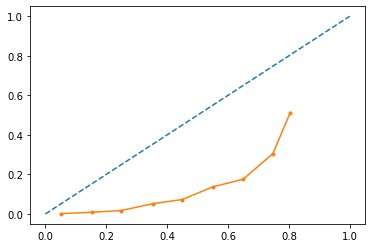

In [141]:
probs=clf_random.predict_proba(x_test_auto)
fop, mpv = calibration_curve(y_test, probs[:,1], n_bins=10, normalize=False)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(mpv, fop, marker='.')
plt.show()

In [38]:
clf=LogisticRegression(penalty='elasticnet',C=1,solver='lbfgs',class_weight='balanced',l1_ratio=0.6,max_iter=500)

In [39]:
penalty=['elasticnet']
C=np.linspace(0.1,10,100)
solver=['saga']
l1_ratio=np.linspace(0.1,1,100)
max_iter=[700,800,900]

forest_param=[{
            'penalty':penalty,
            'C':C,
              'solver':solver,
               'l1_ratio':l1_ratio,
                'max_iter':max_iter}]

randomized=RandomizedSearchCV(estimator=clf,  param_distributions=forest_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=-1,random_state=42,verbose=4)

In [40]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=LogisticRegression(C=1, class_weight='balanced',
                                                l1_ratio=0.6, max_iter=500,
                                                penalty='elasticnet'),
                   n_iter=140, n_jobs=-1,
                   param_distributions=[{'C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2...
       0.78181818, 0.79090909, 0.8       , 0.80909091, 0.81818182,
       0.82727273, 0.83636364, 0.84545455, 0.85454545, 0.86363636,
       0.87272727, 0.88181818, 0.89090909, 0.9       , 0.90909091,
       0.91818182, 0.92727273, 0.93636364, 0.94545455, 0.95454545,
       0.96363636, 0.97272727, 0.98181818, 0.99090909, 1.        ]),
                                         'max_iter': [700, 800, 900],
                                         'penalty': ['elasticnet'],
                                         'solver': ['saga']}],
                   random_state=42, scoring='balanced_accuracy', verbose=4)

In [41]:
randomized.best_params_

{'solver': 'saga',
 'penalty': 'elasticnet',
 'max_iter': 900,
 'l1_ratio': 0.8636363636363635,
 'C': 7.9}

In [251]:
clf_log=LogisticRegression(penalty='elasticnet',C=7.9,solver='saga',class_weight='balanced',l1_ratio=0.864,max_iter=900)


log_balanced_test=[]
log_precision_test=[]
log_recall_test=[]
log_auc_test=[]

for train_index, test_index in skf.split(x_train_auto, y_train):
    clf_log.fit(x_train_auto[train_index],y_train[train_index])
    pred=clf_log.predict_proba(x_test_auto)
    
    log_balanced=balanced_accuracy_score(y_test,np.where(pred[:,1]>0.5,1,0))
    log_balanced_test.append(log_balanced)
    
    log_precision=precision_score(y_test,np.where(pred[:,1]>0.5,1,0))
    log_precision_test.append(log_precision)
    
    log_recall=recall_score(y_test,np.where(pred[:,1]>0.5,1,0))
    log_recall_test.append(log_recall)
    
    log_auc=roc_auc_score(y_test,pred[:,1])
    log_auc_test.append(log_auc)

log_balanced_test=np.array(log_balanced_test)
log_precision_test=np.array(log_precision_test)
log_recall_test=np.array(log_recall_test)
log_auc_test=np.array(log_auc_test)

print(f'mean_balanced_test : {np.mean(log_balanced_test,axis=0)}+\-{np.std(log_balanced_test,axis=0)}\nmean_precision_test : {np.mean(log_precision_test,axis=0)}+\-{np.std(log_precision_test,axis=0)}\nmean_recall_test : {np.mean(log_recall_test,axis=0)}+\-{np.std(log_recall_test,axis=0)}\nmean_AUC_test : {np.mean(log_auc_test,axis=0)}+/-{np.std(log_auc_test,axis=0)}')

mean_balanced_test : 0.7274821363613723+\-0.002239305169211306
mean_precision_test : 0.20414512197808882+\-0.0008964091172107327
mean_recall_test : 0.7816135084427767+\-0.0050482641827668566
mean_AUC_test : 0.8068797838250678+/-0.00044009788784582835


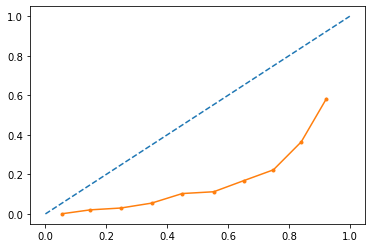

In [179]:
probs=clf_log.predict_proba(x_test_auto)
fop, mpv = calibration_curve(y_test, probs[:,1], n_bins=10, normalize=False)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(mpv, fop, marker='.')
plt.show()

In [31]:
svc=svm.SVC(C=5,kernel='rbf',degree=3,gamma=0.1,coef0=2,shrinking=True,class_weight='balanced')

In [32]:
C=np.linspace(0.01,10,20)
kernel=['rbf','linear']
gamma=np.linspace(0,0.5,20)
coef0=np.linspace(0,7,20)

forest_param=[{
            'C':C,
              'kernel':kernel,
               'gamma':gamma,
                 'coef0':coef0}]

randomized=RandomizedSearchCV(estimator=svc,  param_distributions=forest_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=10,random_state=42,verbose=4)

In [33]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=SVC(C=5, class_weight='balanced', coef0=2,
                                 gamma=0.1),
                   n_iter=140, n_jobs=10,
                   param_distributions=[{'C': array([ 0.01      ,  0.53578947,  1.06157895,  1.58736842,  2.11315789,
        2.63894737,  3.16473684,  3.69052632,  4.21631579,  4.74210526,
        5.26789474,  5.79368421,  6.31947368,  6.84526316,  7.37105...
       5.52631579, 5.89473684, 6.26315789, 6.63157895, 7.        ]),
                                         'gamma': array([0.        , 0.02631579, 0.05263158, 0.07894737, 0.10526316,
       0.13157895, 0.15789474, 0.18421053, 0.21052632, 0.23684211,
       0.26315789, 0.28947368, 0.31578947, 0.34210526, 0.36842105,
       0.39473684, 0.42105263, 0.44736842, 0.47368421, 0.5       ]),
                                         'kernel': ['rbf', 'linear']}],
                   random_state=42, scoring='balanced_accuracy', verbose=4)

In [34]:
randomized.best_params_

{'kernel': 'linear',
 'gamma': 0.3421052631578947,
 'coef0': 4.052631578947368,
 'C': 0.5357894736842106}

In [35]:
df_randomised_result=pd.DataFrame(randomized.cv_results_)

In [36]:
df_randomised_result.to_csv('param_svm.csv')

In [37]:
print(df_randomised_result,'\n\n',randomized.best_params_)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        35.265728      3.015460         2.626481        0.366850   
1        34.769231      4.680662         1.355005        0.344271   
2        38.425925      3.277250         2.927864        0.365078   
3        34.981318      2.693171         2.494891        0.531433   
4        34.513273      5.274192         2.515769        0.639189   
..             ...           ...              ...             ...   
135      36.063940      3.170908         2.816920        0.513204   
136      37.984684      4.477219         2.798985        0.639871   
137      28.844407      4.629078         1.286917        0.468517   
138      33.757737      4.572744         4.005704        0.817000   
139      28.473844      4.739865         0.925877        0.358952   

    param_kernel param_gamma param_coef0   param_C  \
0            rbf    0.394737    0.368421  4.742105   
1         linear    0.447368    5.157895      10.0   
2        

In [285]:
svc=svm.SVC(C=0.536,kernel='linear',degree=3,gamma=0.34,coef0=4.05,shrinking=True,class_weight='balanced',probability=True)

In [287]:
svc_balanced_test=[]
svc_precision_test=[]
svc_recall_test=[]
svc_auc_test=[]

for train_index, test_index in skf.split(x_train_auto, y_train):
    svc.fit(x_train_auto[train_index],y_train[train_index])
    
    
    pred=svc.predict_proba(x_test_auto)
    
    svc_balanced=balanced_accuracy_score(y_test,np.where(pred[:,1]>0.5,1,0))
    svc_balanced_test.append(svc_balanced)
    
    svc_precision=precision_score(y_test,np.where(pred[:,1]>0.5,1,0))
    svc_precision_test.append(svc_precision)
    
    svc_recall=recall_score(y_test,np.where(pred[:,1]>0.5,1,0))
    svc_recall_test.append(svc_recall)
    
    svc_auc=roc_auc_score(y_test,pred[:,1])
    svc_auc_test.append(svc_auc)

svc_balanced_test=np.array(svc_balanced_test)
svc_precision_test=np.array(svc_precision_test)
svc_recall_test=np.array(svc_recall_test)
svc_auc_test=np.array(svc_auc_test)

print(f'mean_balanced_test : {np.mean(svc_balanced_test,axis=0)}+\-{np.std(svc_balanced_test,axis=0)}\nmean_precision_test : {np.mean(svc_precision_test,axis=0)}+\-{np.std(svc_precision_test,axis=0)}\nmean_recall_test : {np.mean(svc_recall_test,axis=0)}+\-{np.std(svc_recall_test,axis=0)}\nmean_AUC_test : {np.mean(svc_auc_test,axis=0)}+/-{np.std(svc_auc_test,axis=0)}')

mean_balanced_test : 0.5081711052815089+\-0.0011377830254117693
mean_precision_test : 0.6277380952380953+\-0.049593157718751966
mean_recall_test : 0.017448405253283304+\-0.0022278315360296274
mean_AUC_test : 0.8060735239291251+/-0.00043075517969184913


In [283]:
pred=svc.decision_function(x_test_auto)

In [269]:
np.max(pred)

2.720961089861737

(array([  11.,  367.,  600.,  664.,  852.,  962., 1039.,  784.,  214.,
          12.]),
 array([-3.82340949, -3.16897244, -2.51453538, -1.86009832, -1.20566126,
        -0.5512242 ,  0.10321286,  0.75764991,  1.41208697,  2.06652403,
         2.72096109]),
 <BarContainer object of 10 artists>)

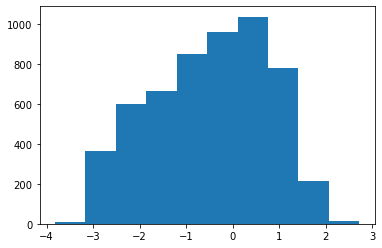

In [284]:
plt.hist(pred)

In [258]:
np.argmax(np.array([[1,2],[2,3],[1,3]]),axis=1)

array([1, 1, 1], dtype=int64)

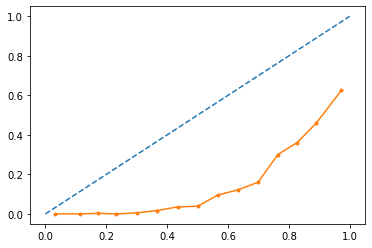

In [280]:
probs=svc.decision_function(x_test_auto)
fop, mpv = calibration_curve(y_test, probs, n_bins=15, normalize=True)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(mpv, fop, marker='.')
plt.show()

In [32]:


auc_lgbm=[]
recall_lgbm=[]
precision_lgbm=[]
balanced_accu_lgbm=[]

auc_lgbm_test=[]
recall_lgbm_test=[]
precision_lgbm_test=[]
balanced_accu_lgbm_test=[]

for train_index, test_index in skf.split(x_train_auto, y_train):
    
    print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_f, X_test_f = x_train_auto[train_index], x_train_auto[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    
    clf_lgbm=lgb.LGBMClassifier(boosting_type='gbdt',num_leaves=11000,max_depth=1000,learning_rate=0.001,
                       
                       n_estimators=7000,subsample_for_bin=5000,min_split_gain=0.01,min_child_samples=700,
                       colsample_bytree=0.9,
                       reg_alpha=0.01,reg_lambda=0.01,
                       
                       objective='binary',subsample=0.9,
                       
                       subsample_freq=100,class_weight='balanced',
                       random_state=42)
    
    

    clf_lgbm.fit(X_train_f,Y_train,eval_set=(X_test_f,Y_test),eval_names=['validation'],
        eval_metric=['logloss'],early_stopping_rounds=20,categorical_feature='auto')
    
    preds_proba=clf_lgbm.predict_proba(X_test_f)
    
    auc_scoree=roc_auc_score(Y_test,preds_proba[:,1])
    auc_lgbm.append(auc_scoree)
    
    recall_scoree=recall_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    recall_lgbm.append(recall_scoree)
    
    precision_scoree=precision_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    precision_lgbm.append(precision_scoree)
    
    score=balanced_accuracy_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    balanced_accu_lgbm.append(score)
    
    
    preds_proba_test=clf_lgbm.predict_proba(x_test_auto)
    
    auc_scoree_test=roc_auc_score(y_test,preds_proba_test[:,1])
    auc_lgbm_test.append(auc_scoree_test)
    
    recall_scoree_test=recall_score(y_test,np.where(preds_proba_test[:,1]>0.5,1,0))
    recall_lgbm_test.append(recall_scoree_test)
    
    precision_scoree_test=precision_score(y_test,np.where(preds_proba_test[:,1]>0.5,1,0))
    precision_lgbm_test.append(precision_scoree_test)
    
    score_test=balanced_accuracy_score(y_test,np.where(preds_proba_test[:,1]>0.5,1,0))
    balanced_accu_lgbm_test.append(score_test)
    
balanced_accu_array=np.array(balanced_accu_lgbm)
auc_array=np.array(auc_lgbm)
precision_array=np.array(precision_lgbm)
recall_array=np.array(recall_lgbm)

balanced_accu_array_test=np.array(balanced_accu_lgbm_test)
auc_array_test=np.array(auc_lgbm_test)
precision_array_test=np.array(precision_lgbm_test)
recall_array_test=np.array(recall_lgbm_test)

print(f'balanced_accuracy:{np.mean(balanced_accu_array,axis=0)}+\-{np.std(balanced_accu_array,axis=0)}\nAUC:{np.mean(auc_array,axis=0)}+\-{np.std(auc_array,axis=0)}\nPrecision:{np.mean(precision_array,axis=0)}+\-{np.std(precision_array,axis=0)}\nRecall:{np.mean(recall_array,axis=0)}+\-{np.std(recall_array,axis=0)}')

print(f'balanced_accuracy_test:{np.mean(balanced_accu_array_test,axis=0)}+\-{np.std(balanced_accu_array_test,axis=0)}\nAUC_test:{np.mean(auc_array_test,axis=0)}+\-{np.std(auc_array_test,axis=0)}\nPrecision_test:{np.mean(precision_array_test,axis=0)}+\-{np.std(precision_array_test,axis=0)}\nRecall_test:{np.mean(recall_array_test,axis=0)}+\-{np.std(recall_array_test,axis=0)}')




TRAIN: [    0     1     2 ... 22013 22014 22016] TEST: [   18    23    39 ... 22003 22004 22015]
[1]	validation's binary_logloss: 0.692847
Training until validation scores don't improve for 20 rounds
[2]	validation's binary_logloss: 0.692549
[3]	validation's binary_logloss: 0.692278
[4]	validation's binary_logloss: 0.692002
[5]	validation's binary_logloss: 0.691707
[6]	validation's binary_logloss: 0.691412
[7]	validation's binary_logloss: 0.69112
[8]	validation's binary_logloss: 0.690826
[9]	validation's binary_logloss: 0.690531
[10]	validation's binary_logloss: 0.690238
[11]	validation's binary_logloss: 0.689949
[12]	validation's binary_logloss: 0.689678
[13]	validation's binary_logloss: 0.689387
[14]	validation's binary_logloss: 0.689093
[15]	validation's binary_logloss: 0.688801
[16]	validation's binary_logloss: 0.688511
[17]	validation's binary_logloss: 0.688222
[18]	validation's binary_logloss: 0.687934
[19]	validation's binary_logloss: 0.687644
[20]	validation's binary_logloss: 0

[223]	validation's binary_logloss: 0.639628
[224]	validation's binary_logloss: 0.639429
[225]	validation's binary_logloss: 0.639229
[226]	validation's binary_logloss: 0.639029
[227]	validation's binary_logloss: 0.63883
[228]	validation's binary_logloss: 0.638631
[229]	validation's binary_logloss: 0.638433
[230]	validation's binary_logloss: 0.638239
[231]	validation's binary_logloss: 0.638044
[232]	validation's binary_logloss: 0.637847
[233]	validation's binary_logloss: 0.63765
[234]	validation's binary_logloss: 0.637454
[235]	validation's binary_logloss: 0.637261
[236]	validation's binary_logloss: 0.637066
[237]	validation's binary_logloss: 0.636871
[238]	validation's binary_logloss: 0.636683
[239]	validation's binary_logloss: 0.636495
[240]	validation's binary_logloss: 0.636301
[241]	validation's binary_logloss: 0.636106
[242]	validation's binary_logloss: 0.635913
[243]	validation's binary_logloss: 0.635721
[244]	validation's binary_logloss: 0.635535
[245]	validation's binary_logloss:

[477]	validation's binary_logloss: 0.599754
[478]	validation's binary_logloss: 0.599631
[479]	validation's binary_logloss: 0.599509
[480]	validation's binary_logloss: 0.599389
[481]	validation's binary_logloss: 0.599272
[482]	validation's binary_logloss: 0.599149
[483]	validation's binary_logloss: 0.599031
[484]	validation's binary_logloss: 0.59891
[485]	validation's binary_logloss: 0.598788
[486]	validation's binary_logloss: 0.59867
[487]	validation's binary_logloss: 0.598548
[488]	validation's binary_logloss: 0.598427
[489]	validation's binary_logloss: 0.598304
[490]	validation's binary_logloss: 0.598184
[491]	validation's binary_logloss: 0.598064
[492]	validation's binary_logloss: 0.597944
[493]	validation's binary_logloss: 0.597828
[494]	validation's binary_logloss: 0.597712
[495]	validation's binary_logloss: 0.597593
[496]	validation's binary_logloss: 0.597478
[497]	validation's binary_logloss: 0.597357
[498]	validation's binary_logloss: 0.597243
[499]	validation's binary_logloss:

[723]	validation's binary_logloss: 0.575205
[724]	validation's binary_logloss: 0.575125
[725]	validation's binary_logloss: 0.575042
[726]	validation's binary_logloss: 0.57496
[727]	validation's binary_logloss: 0.57488
[728]	validation's binary_logloss: 0.574796
[729]	validation's binary_logloss: 0.574716
[730]	validation's binary_logloss: 0.574634
[731]	validation's binary_logloss: 0.574551
[732]	validation's binary_logloss: 0.574472
[733]	validation's binary_logloss: 0.574389
[734]	validation's binary_logloss: 0.574308
[735]	validation's binary_logloss: 0.574226
[736]	validation's binary_logloss: 0.574145
[737]	validation's binary_logloss: 0.574066
[738]	validation's binary_logloss: 0.573987
[739]	validation's binary_logloss: 0.573908
[740]	validation's binary_logloss: 0.573832
[741]	validation's binary_logloss: 0.57375
[742]	validation's binary_logloss: 0.573671
[743]	validation's binary_logloss: 0.573593
[744]	validation's binary_logloss: 0.573513
[745]	validation's binary_logloss: 

[976]	validation's binary_logloss: 0.556761
[977]	validation's binary_logloss: 0.556703
[978]	validation's binary_logloss: 0.556642
[979]	validation's binary_logloss: 0.556581
[980]	validation's binary_logloss: 0.55652
[981]	validation's binary_logloss: 0.55646
[982]	validation's binary_logloss: 0.5564
[983]	validation's binary_logloss: 0.55634
[984]	validation's binary_logloss: 0.55628
[985]	validation's binary_logloss: 0.55622
[986]	validation's binary_logloss: 0.556163
[987]	validation's binary_logloss: 0.556106
[988]	validation's binary_logloss: 0.556046
[989]	validation's binary_logloss: 0.555989
[990]	validation's binary_logloss: 0.555933
[991]	validation's binary_logloss: 0.555873
[992]	validation's binary_logloss: 0.555816
[993]	validation's binary_logloss: 0.55576
[994]	validation's binary_logloss: 0.5557
[995]	validation's binary_logloss: 0.555643
[996]	validation's binary_logloss: 0.555585
[997]	validation's binary_logloss: 0.555527
[998]	validation's binary_logloss: 0.55547

[1210]	validation's binary_logloss: 0.544355
[1211]	validation's binary_logloss: 0.544314
[1212]	validation's binary_logloss: 0.544264
[1213]	validation's binary_logloss: 0.544219
[1214]	validation's binary_logloss: 0.544172
[1215]	validation's binary_logloss: 0.544126
[1216]	validation's binary_logloss: 0.54408
[1217]	validation's binary_logloss: 0.544035
[1218]	validation's binary_logloss: 0.543989
[1219]	validation's binary_logloss: 0.543945
[1220]	validation's binary_logloss: 0.543899
[1221]	validation's binary_logloss: 0.543854
[1222]	validation's binary_logloss: 0.543807
[1223]	validation's binary_logloss: 0.543759
[1224]	validation's binary_logloss: 0.54371
[1225]	validation's binary_logloss: 0.543665
[1226]	validation's binary_logloss: 0.54362
[1227]	validation's binary_logloss: 0.543575
[1228]	validation's binary_logloss: 0.543527
[1229]	validation's binary_logloss: 0.543484
[1230]	validation's binary_logloss: 0.543439
[1231]	validation's binary_logloss: 0.543394
[1232]	valida

[1440]	validation's binary_logloss: 0.536267
[1441]	validation's binary_logloss: 0.536238
[1442]	validation's binary_logloss: 0.536213
[1443]	validation's binary_logloss: 0.536186
[1444]	validation's binary_logloss: 0.536161
[1445]	validation's binary_logloss: 0.536133
[1446]	validation's binary_logloss: 0.536104
[1447]	validation's binary_logloss: 0.536079
[1448]	validation's binary_logloss: 0.536053
[1449]	validation's binary_logloss: 0.536028
[1450]	validation's binary_logloss: 0.536002
[1451]	validation's binary_logloss: 0.535976
[1452]	validation's binary_logloss: 0.53595
[1453]	validation's binary_logloss: 0.535922
[1454]	validation's binary_logloss: 0.535898
[1455]	validation's binary_logloss: 0.535869
[1456]	validation's binary_logloss: 0.53584
[1457]	validation's binary_logloss: 0.535815
[1458]	validation's binary_logloss: 0.535788
[1459]	validation's binary_logloss: 0.535761
[1460]	validation's binary_logloss: 0.535737
[1461]	validation's binary_logloss: 0.535707
[1462]	valid

[1685]	validation's binary_logloss: 0.530251
[1686]	validation's binary_logloss: 0.530229
[1687]	validation's binary_logloss: 0.530208
[1688]	validation's binary_logloss: 0.530186
[1689]	validation's binary_logloss: 0.530164
[1690]	validation's binary_logloss: 0.530144
[1691]	validation's binary_logloss: 0.530123
[1692]	validation's binary_logloss: 0.530104
[1693]	validation's binary_logloss: 0.530084
[1694]	validation's binary_logloss: 0.530063
[1695]	validation's binary_logloss: 0.530041
[1696]	validation's binary_logloss: 0.53002
[1697]	validation's binary_logloss: 0.529998
[1698]	validation's binary_logloss: 0.529977
[1699]	validation's binary_logloss: 0.529957
[1700]	validation's binary_logloss: 0.529936
[1701]	validation's binary_logloss: 0.529914
[1702]	validation's binary_logloss: 0.529894
[1703]	validation's binary_logloss: 0.529875
[1704]	validation's binary_logloss: 0.529855
[1705]	validation's binary_logloss: 0.529835
[1706]	validation's binary_logloss: 0.529815
[1707]	vali

[1941]	validation's binary_logloss: 0.525046
[1942]	validation's binary_logloss: 0.525024
[1943]	validation's binary_logloss: 0.525002
[1944]	validation's binary_logloss: 0.524982
[1945]	validation's binary_logloss: 0.524959
[1946]	validation's binary_logloss: 0.524938
[1947]	validation's binary_logloss: 0.524921
[1948]	validation's binary_logloss: 0.524901
[1949]	validation's binary_logloss: 0.524882
[1950]	validation's binary_logloss: 0.524863
[1951]	validation's binary_logloss: 0.524845
[1952]	validation's binary_logloss: 0.524825
[1953]	validation's binary_logloss: 0.524805
[1954]	validation's binary_logloss: 0.524783
[1955]	validation's binary_logloss: 0.524762
[1956]	validation's binary_logloss: 0.524741
[1957]	validation's binary_logloss: 0.52472
[1958]	validation's binary_logloss: 0.524704
[1959]	validation's binary_logloss: 0.524683
[1960]	validation's binary_logloss: 0.524663
[1961]	validation's binary_logloss: 0.524642
[1962]	validation's binary_logloss: 0.524621
[1963]	vali

[2130]	validation's binary_logloss: 0.522024
[2131]	validation's binary_logloss: 0.522006
[2132]	validation's binary_logloss: 0.521989
[2133]	validation's binary_logloss: 0.52197
[2134]	validation's binary_logloss: 0.521956
[2135]	validation's binary_logloss: 0.521937
[2136]	validation's binary_logloss: 0.521919
[2137]	validation's binary_logloss: 0.521903
[2138]	validation's binary_logloss: 0.521885
[2139]	validation's binary_logloss: 0.52187
[2140]	validation's binary_logloss: 0.521854
[2141]	validation's binary_logloss: 0.521838
[2142]	validation's binary_logloss: 0.521821
[2143]	validation's binary_logloss: 0.521806
[2144]	validation's binary_logloss: 0.521789
[2145]	validation's binary_logloss: 0.52177
[2146]	validation's binary_logloss: 0.521754
[2147]	validation's binary_logloss: 0.521738
[2148]	validation's binary_logloss: 0.52172
[2149]	validation's binary_logloss: 0.521703
[2150]	validation's binary_logloss: 0.521686
[2151]	validation's binary_logloss: 0.521671
[2152]	validat

[2323]	validation's binary_logloss: 0.519865
[2324]	validation's binary_logloss: 0.51985
[2325]	validation's binary_logloss: 0.519834
[2326]	validation's binary_logloss: 0.51982
[2327]	validation's binary_logloss: 0.519804
[2328]	validation's binary_logloss: 0.519789
[2329]	validation's binary_logloss: 0.519775
[2330]	validation's binary_logloss: 0.519761
[2331]	validation's binary_logloss: 0.519747
[2332]	validation's binary_logloss: 0.519732
[2333]	validation's binary_logloss: 0.519719
[2334]	validation's binary_logloss: 0.519704
[2335]	validation's binary_logloss: 0.519691
[2336]	validation's binary_logloss: 0.519678
[2337]	validation's binary_logloss: 0.519663
[2338]	validation's binary_logloss: 0.519652
[2339]	validation's binary_logloss: 0.519641
[2340]	validation's binary_logloss: 0.519628
[2341]	validation's binary_logloss: 0.519614
[2342]	validation's binary_logloss: 0.5196
[2343]	validation's binary_logloss: 0.519585
[2344]	validation's binary_logloss: 0.519568
[2345]	validat

[2551]	validation's binary_logloss: 0.51773
[2552]	validation's binary_logloss: 0.517722
[2553]	validation's binary_logloss: 0.517718
[2554]	validation's binary_logloss: 0.517712
[2555]	validation's binary_logloss: 0.517705
[2556]	validation's binary_logloss: 0.5177
[2557]	validation's binary_logloss: 0.517696
[2558]	validation's binary_logloss: 0.517689
[2559]	validation's binary_logloss: 0.517685
[2560]	validation's binary_logloss: 0.517679
[2561]	validation's binary_logloss: 0.517675
[2562]	validation's binary_logloss: 0.517668
[2563]	validation's binary_logloss: 0.517665
[2564]	validation's binary_logloss: 0.517663
[2565]	validation's binary_logloss: 0.517661
[2566]	validation's binary_logloss: 0.517657
[2567]	validation's binary_logloss: 0.517648
[2568]	validation's binary_logloss: 0.517645
[2569]	validation's binary_logloss: 0.517644
[2570]	validation's binary_logloss: 0.517639
[2571]	validation's binary_logloss: 0.517638
[2572]	validation's binary_logloss: 0.517633
[2573]	valida

[2793]	validation's binary_logloss: 0.516207
[2794]	validation's binary_logloss: 0.516199
[2795]	validation's binary_logloss: 0.516195
[2796]	validation's binary_logloss: 0.516191
[2797]	validation's binary_logloss: 0.516187
[2798]	validation's binary_logloss: 0.51618
[2799]	validation's binary_logloss: 0.516174
[2800]	validation's binary_logloss: 0.516171
[2801]	validation's binary_logloss: 0.516164
[2802]	validation's binary_logloss: 0.516158
[2803]	validation's binary_logloss: 0.516152
[2804]	validation's binary_logloss: 0.516145
[2805]	validation's binary_logloss: 0.516138
[2806]	validation's binary_logloss: 0.516131
[2807]	validation's binary_logloss: 0.516125
[2808]	validation's binary_logloss: 0.516119
[2809]	validation's binary_logloss: 0.516112
[2810]	validation's binary_logloss: 0.516105
[2811]	validation's binary_logloss: 0.516097
[2812]	validation's binary_logloss: 0.516091
[2813]	validation's binary_logloss: 0.516084
[2814]	validation's binary_logloss: 0.516077
[2815]	vali

[3047]	validation's binary_logloss: 0.514799
[3048]	validation's binary_logloss: 0.514797
[3049]	validation's binary_logloss: 0.514798
[3050]	validation's binary_logloss: 0.514794
[3051]	validation's binary_logloss: 0.514791
[3052]	validation's binary_logloss: 0.514788
[3053]	validation's binary_logloss: 0.514788
[3054]	validation's binary_logloss: 0.514785
[3055]	validation's binary_logloss: 0.514781
[3056]	validation's binary_logloss: 0.514777
[3057]	validation's binary_logloss: 0.514773
[3058]	validation's binary_logloss: 0.514772
[3059]	validation's binary_logloss: 0.514767
[3060]	validation's binary_logloss: 0.514765
[3061]	validation's binary_logloss: 0.514761
[3062]	validation's binary_logloss: 0.514757
[3063]	validation's binary_logloss: 0.514754
[3064]	validation's binary_logloss: 0.514752
[3065]	validation's binary_logloss: 0.51475
[3066]	validation's binary_logloss: 0.514747
[3067]	validation's binary_logloss: 0.514745
[3068]	validation's binary_logloss: 0.514742
[3069]	vali

[129]	validation's binary_logloss: 0.660874
[130]	validation's binary_logloss: 0.660657
[131]	validation's binary_logloss: 0.660437
[132]	validation's binary_logloss: 0.66022
[133]	validation's binary_logloss: 0.660004
[134]	validation's binary_logloss: 0.659797
[135]	validation's binary_logloss: 0.659583
[136]	validation's binary_logloss: 0.659368
[137]	validation's binary_logloss: 0.659155
[138]	validation's binary_logloss: 0.65895
[139]	validation's binary_logloss: 0.658735
[140]	validation's binary_logloss: 0.65853
[141]	validation's binary_logloss: 0.658329
[142]	validation's binary_logloss: 0.658119
[143]	validation's binary_logloss: 0.657908
[144]	validation's binary_logloss: 0.657696
[145]	validation's binary_logloss: 0.657486
[146]	validation's binary_logloss: 0.657276
[147]	validation's binary_logloss: 0.657065
[148]	validation's binary_logloss: 0.656863
[149]	validation's binary_logloss: 0.656655
[150]	validation's binary_logloss: 0.656454
[151]	validation's binary_logloss: 

[371]	validation's binary_logloss: 0.618716
[372]	validation's binary_logloss: 0.618582
[373]	validation's binary_logloss: 0.618447
[374]	validation's binary_logloss: 0.618314
[375]	validation's binary_logloss: 0.618181
[376]	validation's binary_logloss: 0.618048
[377]	validation's binary_logloss: 0.617914
[378]	validation's binary_logloss: 0.617781
[379]	validation's binary_logloss: 0.617648
[380]	validation's binary_logloss: 0.617517
[381]	validation's binary_logloss: 0.617384
[382]	validation's binary_logloss: 0.617251
[383]	validation's binary_logloss: 0.61712
[384]	validation's binary_logloss: 0.616987
[385]	validation's binary_logloss: 0.616856
[386]	validation's binary_logloss: 0.616718
[387]	validation's binary_logloss: 0.616583
[388]	validation's binary_logloss: 0.616449
[389]	validation's binary_logloss: 0.616319
[390]	validation's binary_logloss: 0.616183
[391]	validation's binary_logloss: 0.61605
[392]	validation's binary_logloss: 0.615915
[393]	validation's binary_logloss:

[593]	validation's binary_logloss: 0.593403
[594]	validation's binary_logloss: 0.593309
[595]	validation's binary_logloss: 0.593212
[596]	validation's binary_logloss: 0.593111
[597]	validation's binary_logloss: 0.593018
[598]	validation's binary_logloss: 0.59292
[599]	validation's binary_logloss: 0.592827
[600]	validation's binary_logloss: 0.592731
[601]	validation's binary_logloss: 0.592635
[602]	validation's binary_logloss: 0.592543
[603]	validation's binary_logloss: 0.592447
[604]	validation's binary_logloss: 0.592352
[605]	validation's binary_logloss: 0.592258
[606]	validation's binary_logloss: 0.592166
[607]	validation's binary_logloss: 0.592071
[608]	validation's binary_logloss: 0.591976
[609]	validation's binary_logloss: 0.591881
[610]	validation's binary_logloss: 0.591787
[611]	validation's binary_logloss: 0.591693
[612]	validation's binary_logloss: 0.591599
[613]	validation's binary_logloss: 0.591505
[614]	validation's binary_logloss: 0.591412
[615]	validation's binary_logloss

[845]	validation's binary_logloss: 0.573986
[846]	validation's binary_logloss: 0.573924
[847]	validation's binary_logloss: 0.57386
[848]	validation's binary_logloss: 0.573796
[849]	validation's binary_logloss: 0.573732
[850]	validation's binary_logloss: 0.573666
[851]	validation's binary_logloss: 0.5736
[852]	validation's binary_logloss: 0.573539
[853]	validation's binary_logloss: 0.573476
[854]	validation's binary_logloss: 0.573417
[855]	validation's binary_logloss: 0.573354
[856]	validation's binary_logloss: 0.573293
[857]	validation's binary_logloss: 0.573233
[858]	validation's binary_logloss: 0.573172
[859]	validation's binary_logloss: 0.573108
[860]	validation's binary_logloss: 0.573047
[861]	validation's binary_logloss: 0.572985
[862]	validation's binary_logloss: 0.572925
[863]	validation's binary_logloss: 0.572863
[864]	validation's binary_logloss: 0.572798
[865]	validation's binary_logloss: 0.572736
[866]	validation's binary_logloss: 0.572674
[867]	validation's binary_logloss: 

[1055]	validation's binary_logloss: 0.561882
[1056]	validation's binary_logloss: 0.561832
[1057]	validation's binary_logloss: 0.561776
[1058]	validation's binary_logloss: 0.561725
[1059]	validation's binary_logloss: 0.56167
[1060]	validation's binary_logloss: 0.561616
[1061]	validation's binary_logloss: 0.561564
[1062]	validation's binary_logloss: 0.56151
[1063]	validation's binary_logloss: 0.561454
[1064]	validation's binary_logloss: 0.561403
[1065]	validation's binary_logloss: 0.561348
[1066]	validation's binary_logloss: 0.561294
[1067]	validation's binary_logloss: 0.561243
[1068]	validation's binary_logloss: 0.561188
[1069]	validation's binary_logloss: 0.561134
[1070]	validation's binary_logloss: 0.561084
[1071]	validation's binary_logloss: 0.561033
[1072]	validation's binary_logloss: 0.560979
[1073]	validation's binary_logloss: 0.560925
[1074]	validation's binary_logloss: 0.560876
[1075]	validation's binary_logloss: 0.560823
[1076]	validation's binary_logloss: 0.560769
[1077]	valid

[1318]	validation's binary_logloss: 0.551459
[1319]	validation's binary_logloss: 0.551425
[1320]	validation's binary_logloss: 0.551395
[1321]	validation's binary_logloss: 0.551363
[1322]	validation's binary_logloss: 0.551331
[1323]	validation's binary_logloss: 0.551302
[1324]	validation's binary_logloss: 0.55127
[1325]	validation's binary_logloss: 0.551241
[1326]	validation's binary_logloss: 0.551213
[1327]	validation's binary_logloss: 0.551181
[1328]	validation's binary_logloss: 0.55115
[1329]	validation's binary_logloss: 0.551121
[1330]	validation's binary_logloss: 0.55109
[1331]	validation's binary_logloss: 0.551062
[1332]	validation's binary_logloss: 0.551034
[1333]	validation's binary_logloss: 0.551002
[1334]	validation's binary_logloss: 0.550973
[1335]	validation's binary_logloss: 0.550942
[1336]	validation's binary_logloss: 0.550909
[1337]	validation's binary_logloss: 0.55088
[1338]	validation's binary_logloss: 0.55085
[1339]	validation's binary_logloss: 0.550819
[1340]	validati

[1517]	validation's binary_logloss: 0.545547
[1518]	validation's binary_logloss: 0.545524
[1519]	validation's binary_logloss: 0.545503
[1520]	validation's binary_logloss: 0.545482
[1521]	validation's binary_logloss: 0.545461
[1522]	validation's binary_logloss: 0.545441
[1523]	validation's binary_logloss: 0.545421
[1524]	validation's binary_logloss: 0.545399
[1525]	validation's binary_logloss: 0.545378
[1526]	validation's binary_logloss: 0.545355
[1527]	validation's binary_logloss: 0.545333
[1528]	validation's binary_logloss: 0.545313
[1529]	validation's binary_logloss: 0.545294
[1530]	validation's binary_logloss: 0.545274
[1531]	validation's binary_logloss: 0.545252
[1532]	validation's binary_logloss: 0.545232
[1533]	validation's binary_logloss: 0.545207
[1534]	validation's binary_logloss: 0.545187
[1535]	validation's binary_logloss: 0.545164
[1536]	validation's binary_logloss: 0.545142
[1537]	validation's binary_logloss: 0.545122
[1538]	validation's binary_logloss: 0.545102
[1539]	val

[1732]	validation's binary_logloss: 0.541131
[1733]	validation's binary_logloss: 0.541109
[1734]	validation's binary_logloss: 0.541087
[1735]	validation's binary_logloss: 0.541066
[1736]	validation's binary_logloss: 0.541044
[1737]	validation's binary_logloss: 0.541023
[1738]	validation's binary_logloss: 0.541003
[1739]	validation's binary_logloss: 0.540982
[1740]	validation's binary_logloss: 0.540962
[1741]	validation's binary_logloss: 0.540941
[1742]	validation's binary_logloss: 0.540921
[1743]	validation's binary_logloss: 0.540898
[1744]	validation's binary_logloss: 0.54088
[1745]	validation's binary_logloss: 0.540859
[1746]	validation's binary_logloss: 0.540838
[1747]	validation's binary_logloss: 0.540819
[1748]	validation's binary_logloss: 0.540801
[1749]	validation's binary_logloss: 0.540779
[1750]	validation's binary_logloss: 0.540759
[1751]	validation's binary_logloss: 0.540739
[1752]	validation's binary_logloss: 0.540719
[1753]	validation's binary_logloss: 0.540699
[1754]	vali

[1971]	validation's binary_logloss: 0.537551
[1972]	validation's binary_logloss: 0.537537
[1973]	validation's binary_logloss: 0.537524
[1974]	validation's binary_logloss: 0.537511
[1975]	validation's binary_logloss: 0.537496
[1976]	validation's binary_logloss: 0.537484
[1977]	validation's binary_logloss: 0.537472
[1978]	validation's binary_logloss: 0.537459
[1979]	validation's binary_logloss: 0.537445
[1980]	validation's binary_logloss: 0.537431
[1981]	validation's binary_logloss: 0.537418
[1982]	validation's binary_logloss: 0.537405
[1983]	validation's binary_logloss: 0.537393
[1984]	validation's binary_logloss: 0.537381
[1985]	validation's binary_logloss: 0.537368
[1986]	validation's binary_logloss: 0.537355
[1987]	validation's binary_logloss: 0.537342
[1988]	validation's binary_logloss: 0.537329
[1989]	validation's binary_logloss: 0.537316
[1990]	validation's binary_logloss: 0.537303
[1991]	validation's binary_logloss: 0.53729
[1992]	validation's binary_logloss: 0.537277
[1993]	vali

[2201]	validation's binary_logloss: 0.534564
[2202]	validation's binary_logloss: 0.53455
[2203]	validation's binary_logloss: 0.534532
[2204]	validation's binary_logloss: 0.534521
[2205]	validation's binary_logloss: 0.534503
[2206]	validation's binary_logloss: 0.534491
[2207]	validation's binary_logloss: 0.534478
[2208]	validation's binary_logloss: 0.534461
[2209]	validation's binary_logloss: 0.534449
[2210]	validation's binary_logloss: 0.534436
[2211]	validation's binary_logloss: 0.534422
[2212]	validation's binary_logloss: 0.53441
[2213]	validation's binary_logloss: 0.534394
[2214]	validation's binary_logloss: 0.534383
[2215]	validation's binary_logloss: 0.534366
[2216]	validation's binary_logloss: 0.534354
[2217]	validation's binary_logloss: 0.534342
[2218]	validation's binary_logloss: 0.534331
[2219]	validation's binary_logloss: 0.534316
[2220]	validation's binary_logloss: 0.534302
[2221]	validation's binary_logloss: 0.534288
[2222]	validation's binary_logloss: 0.534273
[2223]	valid

[2422]	validation's binary_logloss: 0.531739
[2423]	validation's binary_logloss: 0.531727
[2424]	validation's binary_logloss: 0.531713
[2425]	validation's binary_logloss: 0.531703
[2426]	validation's binary_logloss: 0.531693
[2427]	validation's binary_logloss: 0.531682
[2428]	validation's binary_logloss: 0.531671
[2429]	validation's binary_logloss: 0.531659
[2430]	validation's binary_logloss: 0.531648
[2431]	validation's binary_logloss: 0.531636
[2432]	validation's binary_logloss: 0.531621
[2433]	validation's binary_logloss: 0.531613
[2434]	validation's binary_logloss: 0.531602
[2435]	validation's binary_logloss: 0.531587
[2436]	validation's binary_logloss: 0.53158
[2437]	validation's binary_logloss: 0.53157
[2438]	validation's binary_logloss: 0.531561
[2439]	validation's binary_logloss: 0.531551
[2440]	validation's binary_logloss: 0.53154
[2441]	validation's binary_logloss: 0.53153
[2442]	validation's binary_logloss: 0.531519
[2443]	validation's binary_logloss: 0.531509
[2444]	validat

[2609]	validation's binary_logloss: 0.529344
[2610]	validation's binary_logloss: 0.529343
[2611]	validation's binary_logloss: 0.529338
[2612]	validation's binary_logloss: 0.529335
[2613]	validation's binary_logloss: 0.529329
[2614]	validation's binary_logloss: 0.529325
[2615]	validation's binary_logloss: 0.529319
[2616]	validation's binary_logloss: 0.529313
[2617]	validation's binary_logloss: 0.529311
[2618]	validation's binary_logloss: 0.52931
[2619]	validation's binary_logloss: 0.529309
[2620]	validation's binary_logloss: 0.529305
[2621]	validation's binary_logloss: 0.529303
[2622]	validation's binary_logloss: 0.529298
[2623]	validation's binary_logloss: 0.529291
[2624]	validation's binary_logloss: 0.529289
[2625]	validation's binary_logloss: 0.529286
[2626]	validation's binary_logloss: 0.529283
[2627]	validation's binary_logloss: 0.529281
[2628]	validation's binary_logloss: 0.529279
[2629]	validation's binary_logloss: 0.529278
[2630]	validation's binary_logloss: 0.529275
[2631]	vali

[2802]	validation's binary_logloss: 0.528607
[2803]	validation's binary_logloss: 0.528599
[2804]	validation's binary_logloss: 0.528591
[2805]	validation's binary_logloss: 0.528585
[2806]	validation's binary_logloss: 0.52858
[2807]	validation's binary_logloss: 0.528574
[2808]	validation's binary_logloss: 0.528568
[2809]	validation's binary_logloss: 0.528563
[2810]	validation's binary_logloss: 0.528554
[2811]	validation's binary_logloss: 0.528547
[2812]	validation's binary_logloss: 0.52854
[2813]	validation's binary_logloss: 0.528535
[2814]	validation's binary_logloss: 0.528526
[2815]	validation's binary_logloss: 0.528518
[2816]	validation's binary_logloss: 0.528513
[2817]	validation's binary_logloss: 0.528508
[2818]	validation's binary_logloss: 0.528504
[2819]	validation's binary_logloss: 0.528499
[2820]	validation's binary_logloss: 0.528494
[2821]	validation's binary_logloss: 0.528489
[2822]	validation's binary_logloss: 0.528482
[2823]	validation's binary_logloss: 0.528475
[2824]	valid

[2994]	validation's binary_logloss: 0.527596
[2995]	validation's binary_logloss: 0.52759
[2996]	validation's binary_logloss: 0.527589
[2997]	validation's binary_logloss: 0.527583
[2998]	validation's binary_logloss: 0.527577
[2999]	validation's binary_logloss: 0.527576
[3000]	validation's binary_logloss: 0.527569
[3001]	validation's binary_logloss: 0.527564
[3002]	validation's binary_logloss: 0.527559
[3003]	validation's binary_logloss: 0.527551
[3004]	validation's binary_logloss: 0.527546
[3005]	validation's binary_logloss: 0.52754
[3006]	validation's binary_logloss: 0.527535
[3007]	validation's binary_logloss: 0.527529
[3008]	validation's binary_logloss: 0.527523
[3009]	validation's binary_logloss: 0.527515
[3010]	validation's binary_logloss: 0.527509
[3011]	validation's binary_logloss: 0.527502
[3012]	validation's binary_logloss: 0.527497
[3013]	validation's binary_logloss: 0.527493
[3014]	validation's binary_logloss: 0.52749
[3015]	validation's binary_logloss: 0.527484
[3016]	valida

[3240]	validation's binary_logloss: 0.525625
[3241]	validation's binary_logloss: 0.525616
[3242]	validation's binary_logloss: 0.525608
[3243]	validation's binary_logloss: 0.525603
[3244]	validation's binary_logloss: 0.525598
[3245]	validation's binary_logloss: 0.525589
[3246]	validation's binary_logloss: 0.525584
[3247]	validation's binary_logloss: 0.525576
[3248]	validation's binary_logloss: 0.525565
[3249]	validation's binary_logloss: 0.525557
[3250]	validation's binary_logloss: 0.525552
[3251]	validation's binary_logloss: 0.52554
[3252]	validation's binary_logloss: 0.52553
[3253]	validation's binary_logloss: 0.525522
[3254]	validation's binary_logloss: 0.525515
[3255]	validation's binary_logloss: 0.525505
[3256]	validation's binary_logloss: 0.525496
[3257]	validation's binary_logloss: 0.525487
[3258]	validation's binary_logloss: 0.525474
[3259]	validation's binary_logloss: 0.525462
[3260]	validation's binary_logloss: 0.525452
[3261]	validation's binary_logloss: 0.525442
[3262]	valid

[3480]	validation's binary_logloss: 0.524299
[3481]	validation's binary_logloss: 0.52429
[3482]	validation's binary_logloss: 0.524289
[3483]	validation's binary_logloss: 0.524281
[3484]	validation's binary_logloss: 0.52428
[3485]	validation's binary_logloss: 0.524275
[3486]	validation's binary_logloss: 0.524268
[3487]	validation's binary_logloss: 0.524266
[3488]	validation's binary_logloss: 0.524259
[3489]	validation's binary_logloss: 0.524257
[3490]	validation's binary_logloss: 0.524254
[3491]	validation's binary_logloss: 0.524246
[3492]	validation's binary_logloss: 0.524244
[3493]	validation's binary_logloss: 0.524244
[3494]	validation's binary_logloss: 0.524239
[3495]	validation's binary_logloss: 0.524236
[3496]	validation's binary_logloss: 0.524228
[3497]	validation's binary_logloss: 0.524225
[3498]	validation's binary_logloss: 0.524224
[3499]	validation's binary_logloss: 0.524222
[3500]	validation's binary_logloss: 0.52422
[3501]	validation's binary_logloss: 0.524213
[3502]	valida

[3723]	validation's binary_logloss: 0.523214
[3724]	validation's binary_logloss: 0.523213
[3725]	validation's binary_logloss: 0.52321
[3726]	validation's binary_logloss: 0.52321
[3727]	validation's binary_logloss: 0.523206
[3728]	validation's binary_logloss: 0.523206
[3729]	validation's binary_logloss: 0.523206
[3730]	validation's binary_logloss: 0.523204
[3731]	validation's binary_logloss: 0.523201
[3732]	validation's binary_logloss: 0.523198
[3733]	validation's binary_logloss: 0.523198
[3734]	validation's binary_logloss: 0.523197
[3735]	validation's binary_logloss: 0.523194
[3736]	validation's binary_logloss: 0.523192
[3737]	validation's binary_logloss: 0.52319
[3738]	validation's binary_logloss: 0.523187
[3739]	validation's binary_logloss: 0.523187
[3740]	validation's binary_logloss: 0.523183
[3741]	validation's binary_logloss: 0.523179
[3742]	validation's binary_logloss: 0.523176
[3743]	validation's binary_logloss: 0.523173
[3744]	validation's binary_logloss: 0.523171
[3745]	valida

[3960]	validation's binary_logloss: 0.521933
[3961]	validation's binary_logloss: 0.521919
[3962]	validation's binary_logloss: 0.521907
[3963]	validation's binary_logloss: 0.521901
[3964]	validation's binary_logloss: 0.521892
[3965]	validation's binary_logloss: 0.521882
[3966]	validation's binary_logloss: 0.521873
[3967]	validation's binary_logloss: 0.521867
[3968]	validation's binary_logloss: 0.521854
[3969]	validation's binary_logloss: 0.521844
[3970]	validation's binary_logloss: 0.521831
[3971]	validation's binary_logloss: 0.521819
[3972]	validation's binary_logloss: 0.521811
[3973]	validation's binary_logloss: 0.521804
[3974]	validation's binary_logloss: 0.521794
[3975]	validation's binary_logloss: 0.521789
[3976]	validation's binary_logloss: 0.521777
[3977]	validation's binary_logloss: 0.521771
[3978]	validation's binary_logloss: 0.521764
[3979]	validation's binary_logloss: 0.521754
[3980]	validation's binary_logloss: 0.521747
[3981]	validation's binary_logloss: 0.521738
[3982]	val

[4163]	validation's binary_logloss: 0.520823
[4164]	validation's binary_logloss: 0.520818
[4165]	validation's binary_logloss: 0.520812
[4166]	validation's binary_logloss: 0.520805
[4167]	validation's binary_logloss: 0.520799
[4168]	validation's binary_logloss: 0.520793
[4169]	validation's binary_logloss: 0.520786
[4170]	validation's binary_logloss: 0.520781
[4171]	validation's binary_logloss: 0.520775
[4172]	validation's binary_logloss: 0.520769
[4173]	validation's binary_logloss: 0.52076
[4174]	validation's binary_logloss: 0.520754
[4175]	validation's binary_logloss: 0.520748
[4176]	validation's binary_logloss: 0.520742
[4177]	validation's binary_logloss: 0.520736
[4178]	validation's binary_logloss: 0.520731
[4179]	validation's binary_logloss: 0.520726
[4180]	validation's binary_logloss: 0.520721
[4181]	validation's binary_logloss: 0.520715
[4182]	validation's binary_logloss: 0.520708
[4183]	validation's binary_logloss: 0.520703
[4184]	validation's binary_logloss: 0.520699
[4185]	vali

[4384]	validation's binary_logloss: 0.51942
[4385]	validation's binary_logloss: 0.519413
[4386]	validation's binary_logloss: 0.519408
[4387]	validation's binary_logloss: 0.519404
[4388]	validation's binary_logloss: 0.519397
[4389]	validation's binary_logloss: 0.519392
[4390]	validation's binary_logloss: 0.519389
[4391]	validation's binary_logloss: 0.519384
[4392]	validation's binary_logloss: 0.519379
[4393]	validation's binary_logloss: 0.519374
[4394]	validation's binary_logloss: 0.519368
[4395]	validation's binary_logloss: 0.519362
[4396]	validation's binary_logloss: 0.519355
[4397]	validation's binary_logloss: 0.519347
[4398]	validation's binary_logloss: 0.519341
[4399]	validation's binary_logloss: 0.519336
[4400]	validation's binary_logloss: 0.519331
[4401]	validation's binary_logloss: 0.519325
[4402]	validation's binary_logloss: 0.519321
[4403]	validation's binary_logloss: 0.519315
[4404]	validation's binary_logloss: 0.519312
[4405]	validation's binary_logloss: 0.519306
[4406]	vali

[4601]	validation's binary_logloss: 0.518589
[4602]	validation's binary_logloss: 0.518588
[4603]	validation's binary_logloss: 0.518578
[4604]	validation's binary_logloss: 0.518579
[4605]	validation's binary_logloss: 0.518578
[4606]	validation's binary_logloss: 0.518577
[4607]	validation's binary_logloss: 0.518575
[4608]	validation's binary_logloss: 0.51857
[4609]	validation's binary_logloss: 0.518566
[4610]	validation's binary_logloss: 0.518565
[4611]	validation's binary_logloss: 0.518564
[4612]	validation's binary_logloss: 0.518566
[4613]	validation's binary_logloss: 0.518564
[4614]	validation's binary_logloss: 0.51856
[4615]	validation's binary_logloss: 0.518559
[4616]	validation's binary_logloss: 0.51856
[4617]	validation's binary_logloss: 0.518558
[4618]	validation's binary_logloss: 0.518559
[4619]	validation's binary_logloss: 0.518558
[4620]	validation's binary_logloss: 0.518557
[4621]	validation's binary_logloss: 0.518553
[4622]	validation's binary_logloss: 0.518548
[4623]	valida

[4811]	validation's binary_logloss: 0.517873
[4812]	validation's binary_logloss: 0.517867
[4813]	validation's binary_logloss: 0.517862
[4814]	validation's binary_logloss: 0.517856
[4815]	validation's binary_logloss: 0.517851
[4816]	validation's binary_logloss: 0.517847
[4817]	validation's binary_logloss: 0.517842
[4818]	validation's binary_logloss: 0.517837
[4819]	validation's binary_logloss: 0.517832
[4820]	validation's binary_logloss: 0.517828
[4821]	validation's binary_logloss: 0.517823
[4822]	validation's binary_logloss: 0.517813
[4823]	validation's binary_logloss: 0.517808
[4824]	validation's binary_logloss: 0.517801
[4825]	validation's binary_logloss: 0.517796
[4826]	validation's binary_logloss: 0.517786
[4827]	validation's binary_logloss: 0.517782
[4828]	validation's binary_logloss: 0.517776
[4829]	validation's binary_logloss: 0.517766
[4830]	validation's binary_logloss: 0.517761
[4831]	validation's binary_logloss: 0.51775
[4832]	validation's binary_logloss: 0.517743
[4833]	vali

[5058]	validation's binary_logloss: 0.516901
[5059]	validation's binary_logloss: 0.516898
[5060]	validation's binary_logloss: 0.516894
[5061]	validation's binary_logloss: 0.516891
[5062]	validation's binary_logloss: 0.516887
[5063]	validation's binary_logloss: 0.516886
[5064]	validation's binary_logloss: 0.516885
[5065]	validation's binary_logloss: 0.516882
[5066]	validation's binary_logloss: 0.516878
[5067]	validation's binary_logloss: 0.516876
[5068]	validation's binary_logloss: 0.516872
[5069]	validation's binary_logloss: 0.51687
[5070]	validation's binary_logloss: 0.516867
[5071]	validation's binary_logloss: 0.516862
[5072]	validation's binary_logloss: 0.516858
[5073]	validation's binary_logloss: 0.516856
[5074]	validation's binary_logloss: 0.516854
[5075]	validation's binary_logloss: 0.516853
[5076]	validation's binary_logloss: 0.51685
[5077]	validation's binary_logloss: 0.516842
[5078]	validation's binary_logloss: 0.516837
[5079]	validation's binary_logloss: 0.516835
[5080]	valid

[5302]	validation's binary_logloss: 0.515838
[5303]	validation's binary_logloss: 0.515834
[5304]	validation's binary_logloss: 0.515828
[5305]	validation's binary_logloss: 0.515825
[5306]	validation's binary_logloss: 0.515819
[5307]	validation's binary_logloss: 0.515813
[5308]	validation's binary_logloss: 0.515808
[5309]	validation's binary_logloss: 0.515804
[5310]	validation's binary_logloss: 0.515799
[5311]	validation's binary_logloss: 0.515794
[5312]	validation's binary_logloss: 0.51579
[5313]	validation's binary_logloss: 0.515785
[5314]	validation's binary_logloss: 0.515779
[5315]	validation's binary_logloss: 0.515774
[5316]	validation's binary_logloss: 0.515768
[5317]	validation's binary_logloss: 0.515763
[5318]	validation's binary_logloss: 0.515755
[5319]	validation's binary_logloss: 0.515748
[5320]	validation's binary_logloss: 0.515743
[5321]	validation's binary_logloss: 0.515738
[5322]	validation's binary_logloss: 0.515733
[5323]	validation's binary_logloss: 0.515726
[5324]	vali

[5522]	validation's binary_logloss: 0.514725
[5523]	validation's binary_logloss: 0.514719
[5524]	validation's binary_logloss: 0.514712
[5525]	validation's binary_logloss: 0.514708
[5526]	validation's binary_logloss: 0.514704
[5527]	validation's binary_logloss: 0.514701
[5528]	validation's binary_logloss: 0.514693
[5529]	validation's binary_logloss: 0.514685
[5530]	validation's binary_logloss: 0.514676
[5531]	validation's binary_logloss: 0.514665
[5532]	validation's binary_logloss: 0.514657
[5533]	validation's binary_logloss: 0.514648
[5534]	validation's binary_logloss: 0.514646
[5535]	validation's binary_logloss: 0.514634
[5536]	validation's binary_logloss: 0.514625
[5537]	validation's binary_logloss: 0.514617
[5538]	validation's binary_logloss: 0.514606
[5539]	validation's binary_logloss: 0.514603
[5540]	validation's binary_logloss: 0.514595
[5541]	validation's binary_logloss: 0.514588
[5542]	validation's binary_logloss: 0.514581
[5543]	validation's binary_logloss: 0.514573
[5544]	val

[5731]	validation's binary_logloss: 0.51318
[5732]	validation's binary_logloss: 0.513172
[5733]	validation's binary_logloss: 0.513161
[5734]	validation's binary_logloss: 0.513151
[5735]	validation's binary_logloss: 0.513141
[5736]	validation's binary_logloss: 0.513131
[5737]	validation's binary_logloss: 0.513123
[5738]	validation's binary_logloss: 0.513114
[5739]	validation's binary_logloss: 0.513107
[5740]	validation's binary_logloss: 0.513097
[5741]	validation's binary_logloss: 0.51309
[5742]	validation's binary_logloss: 0.513081
[5743]	validation's binary_logloss: 0.513074
[5744]	validation's binary_logloss: 0.513065
[5745]	validation's binary_logloss: 0.513057
[5746]	validation's binary_logloss: 0.513046
[5747]	validation's binary_logloss: 0.513037
[5748]	validation's binary_logloss: 0.513029
[5749]	validation's binary_logloss: 0.513022
[5750]	validation's binary_logloss: 0.513013
[5751]	validation's binary_logloss: 0.513005
[5752]	validation's binary_logloss: 0.512996
[5753]	valid

[5921]	validation's binary_logloss: 0.511542
[5922]	validation's binary_logloss: 0.511539
[5923]	validation's binary_logloss: 0.511538
[5924]	validation's binary_logloss: 0.511534
[5925]	validation's binary_logloss: 0.511531
[5926]	validation's binary_logloss: 0.511528
[5927]	validation's binary_logloss: 0.511525
[5928]	validation's binary_logloss: 0.511524
[5929]	validation's binary_logloss: 0.511521
[5930]	validation's binary_logloss: 0.511519
[5931]	validation's binary_logloss: 0.511517
[5932]	validation's binary_logloss: 0.51151
[5933]	validation's binary_logloss: 0.511507
[5934]	validation's binary_logloss: 0.511505
[5935]	validation's binary_logloss: 0.511496
[5936]	validation's binary_logloss: 0.511494
[5937]	validation's binary_logloss: 0.511487
[5938]	validation's binary_logloss: 0.511484
[5939]	validation's binary_logloss: 0.511477
[5940]	validation's binary_logloss: 0.511475
[5941]	validation's binary_logloss: 0.511473
[5942]	validation's binary_logloss: 0.511471
[5943]	vali

[6154]	validation's binary_logloss: 0.510763
[6155]	validation's binary_logloss: 0.51076
[6156]	validation's binary_logloss: 0.51076
[6157]	validation's binary_logloss: 0.510758
[6158]	validation's binary_logloss: 0.510756
[6159]	validation's binary_logloss: 0.510756
[6160]	validation's binary_logloss: 0.510754
[6161]	validation's binary_logloss: 0.51075
[6162]	validation's binary_logloss: 0.51075
[6163]	validation's binary_logloss: 0.510748
[6164]	validation's binary_logloss: 0.510746
[6165]	validation's binary_logloss: 0.510741
[6166]	validation's binary_logloss: 0.510739
[6167]	validation's binary_logloss: 0.510737
[6168]	validation's binary_logloss: 0.510735
[6169]	validation's binary_logloss: 0.510732
[6170]	validation's binary_logloss: 0.51073
[6171]	validation's binary_logloss: 0.510726
[6172]	validation's binary_logloss: 0.510725
[6173]	validation's binary_logloss: 0.510725
[6174]	validation's binary_logloss: 0.510724
[6175]	validation's binary_logloss: 0.510721
[6176]	validati

[96]	validation's binary_logloss: 0.670169
[97]	validation's binary_logloss: 0.669951
[98]	validation's binary_logloss: 0.669735
[99]	validation's binary_logloss: 0.66952
[100]	validation's binary_logloss: 0.669303
[101]	validation's binary_logloss: 0.669088
[102]	validation's binary_logloss: 0.668874
[103]	validation's binary_logloss: 0.668661
[104]	validation's binary_logloss: 0.668449
[105]	validation's binary_logloss: 0.668236
[106]	validation's binary_logloss: 0.668024
[107]	validation's binary_logloss: 0.667814
[108]	validation's binary_logloss: 0.667602
[109]	validation's binary_logloss: 0.667394
[110]	validation's binary_logloss: 0.667183
[111]	validation's binary_logloss: 0.666973
[112]	validation's binary_logloss: 0.666763
[113]	validation's binary_logloss: 0.666555
[114]	validation's binary_logloss: 0.666343
[115]	validation's binary_logloss: 0.666135
[116]	validation's binary_logloss: 0.665926
[117]	validation's binary_logloss: 0.665718
[118]	validation's binary_logloss: 0.

[379]	validation's binary_logloss: 0.623456
[380]	validation's binary_logloss: 0.623333
[381]	validation's binary_logloss: 0.62321
[382]	validation's binary_logloss: 0.623086
[383]	validation's binary_logloss: 0.622964
[384]	validation's binary_logloss: 0.622838
[385]	validation's binary_logloss: 0.622716
[386]	validation's binary_logloss: 0.622594
[387]	validation's binary_logloss: 0.622472
[388]	validation's binary_logloss: 0.622351
[389]	validation's binary_logloss: 0.62223
[390]	validation's binary_logloss: 0.622109
[391]	validation's binary_logloss: 0.621991
[392]	validation's binary_logloss: 0.621872
[393]	validation's binary_logloss: 0.621753
[394]	validation's binary_logloss: 0.62163
[395]	validation's binary_logloss: 0.621507
[396]	validation's binary_logloss: 0.621389
[397]	validation's binary_logloss: 0.621271
[398]	validation's binary_logloss: 0.621154
[399]	validation's binary_logloss: 0.621037
[400]	validation's binary_logloss: 0.620919
[401]	validation's binary_logloss: 

[585]	validation's binary_logloss: 0.600974
[586]	validation's binary_logloss: 0.600878
[587]	validation's binary_logloss: 0.600784
[588]	validation's binary_logloss: 0.600696
[589]	validation's binary_logloss: 0.600608
[590]	validation's binary_logloss: 0.60052
[591]	validation's binary_logloss: 0.600433
[592]	validation's binary_logloss: 0.600336
[593]	validation's binary_logloss: 0.600241
[594]	validation's binary_logloss: 0.600154
[595]	validation's binary_logloss: 0.600058
[596]	validation's binary_logloss: 0.599964
[597]	validation's binary_logloss: 0.599868
[598]	validation's binary_logloss: 0.599773
[599]	validation's binary_logloss: 0.599683
[600]	validation's binary_logloss: 0.599587
[601]	validation's binary_logloss: 0.599488
[602]	validation's binary_logloss: 0.599395
[603]	validation's binary_logloss: 0.5993
[604]	validation's binary_logloss: 0.599205
[605]	validation's binary_logloss: 0.599111
[606]	validation's binary_logloss: 0.599019
[607]	validation's binary_logloss: 

[794]	validation's binary_logloss: 0.584801
[795]	validation's binary_logloss: 0.58474
[796]	validation's binary_logloss: 0.584678
[797]	validation's binary_logloss: 0.584617
[798]	validation's binary_logloss: 0.584555
[799]	validation's binary_logloss: 0.584494
[800]	validation's binary_logloss: 0.584433
[801]	validation's binary_logloss: 0.584371
[802]	validation's binary_logloss: 0.58431
[803]	validation's binary_logloss: 0.584248
[804]	validation's binary_logloss: 0.584187
[805]	validation's binary_logloss: 0.584126
[806]	validation's binary_logloss: 0.584065
[807]	validation's binary_logloss: 0.584005
[808]	validation's binary_logloss: 0.583948
[809]	validation's binary_logloss: 0.583887
[810]	validation's binary_logloss: 0.583827
[811]	validation's binary_logloss: 0.583767
[812]	validation's binary_logloss: 0.583701
[813]	validation's binary_logloss: 0.58364
[814]	validation's binary_logloss: 0.58358
[815]	validation's binary_logloss: 0.58352
[816]	validation's binary_logloss: 0.

[1007]	validation's binary_logloss: 0.57446
[1008]	validation's binary_logloss: 0.574414
[1009]	validation's binary_logloss: 0.574365
[1010]	validation's binary_logloss: 0.574319
[1011]	validation's binary_logloss: 0.574273
[1012]	validation's binary_logloss: 0.574229
[1013]	validation's binary_logloss: 0.574185
[1014]	validation's binary_logloss: 0.574139
[1015]	validation's binary_logloss: 0.574094
[1016]	validation's binary_logloss: 0.574049
[1017]	validation's binary_logloss: 0.574003
[1018]	validation's binary_logloss: 0.573957
[1019]	validation's binary_logloss: 0.573912
[1020]	validation's binary_logloss: 0.573867
[1021]	validation's binary_logloss: 0.573822
[1022]	validation's binary_logloss: 0.573781
[1023]	validation's binary_logloss: 0.573736
[1024]	validation's binary_logloss: 0.573691
[1025]	validation's binary_logloss: 0.573647
[1026]	validation's binary_logloss: 0.573602
[1027]	validation's binary_logloss: 0.573558
[1028]	validation's binary_logloss: 0.573514
[1029]	vali

[1222]	validation's binary_logloss: 0.565815
[1223]	validation's binary_logloss: 0.565788
[1224]	validation's binary_logloss: 0.565765
[1225]	validation's binary_logloss: 0.565737
[1226]	validation's binary_logloss: 0.565716
[1227]	validation's binary_logloss: 0.565696
[1228]	validation's binary_logloss: 0.565674
[1229]	validation's binary_logloss: 0.565653
[1230]	validation's binary_logloss: 0.565632
[1231]	validation's binary_logloss: 0.565612
[1232]	validation's binary_logloss: 0.565592
[1233]	validation's binary_logloss: 0.565571
[1234]	validation's binary_logloss: 0.565544
[1235]	validation's binary_logloss: 0.565524
[1236]	validation's binary_logloss: 0.565503
[1237]	validation's binary_logloss: 0.565474
[1238]	validation's binary_logloss: 0.565454
[1239]	validation's binary_logloss: 0.565432
[1240]	validation's binary_logloss: 0.565411
[1241]	validation's binary_logloss: 0.565384
[1242]	validation's binary_logloss: 0.565364
[1243]	validation's binary_logloss: 0.565342
[1244]	val

[1446]	validation's binary_logloss: 0.560191
[1447]	validation's binary_logloss: 0.56017
[1448]	validation's binary_logloss: 0.56015
[1449]	validation's binary_logloss: 0.560132
[1450]	validation's binary_logloss: 0.560112
[1451]	validation's binary_logloss: 0.560086
[1452]	validation's binary_logloss: 0.560066
[1453]	validation's binary_logloss: 0.560045
[1454]	validation's binary_logloss: 0.560022
[1455]	validation's binary_logloss: 0.560003
[1456]	validation's binary_logloss: 0.55998
[1457]	validation's binary_logloss: 0.55996
[1458]	validation's binary_logloss: 0.55994
[1459]	validation's binary_logloss: 0.559921
[1460]	validation's binary_logloss: 0.559898
[1461]	validation's binary_logloss: 0.559878
[1462]	validation's binary_logloss: 0.55986
[1463]	validation's binary_logloss: 0.559842
[1464]	validation's binary_logloss: 0.559822
[1465]	validation's binary_logloss: 0.559801
[1466]	validation's binary_logloss: 0.559781
[1467]	validation's binary_logloss: 0.559762
[1468]	validatio

[1659]	validation's binary_logloss: 0.555483
[1660]	validation's binary_logloss: 0.555464
[1661]	validation's binary_logloss: 0.555444
[1662]	validation's binary_logloss: 0.555425
[1663]	validation's binary_logloss: 0.555403
[1664]	validation's binary_logloss: 0.555381
[1665]	validation's binary_logloss: 0.555363
[1666]	validation's binary_logloss: 0.555343
[1667]	validation's binary_logloss: 0.555322
[1668]	validation's binary_logloss: 0.555299
[1669]	validation's binary_logloss: 0.555282
[1670]	validation's binary_logloss: 0.555265
[1671]	validation's binary_logloss: 0.555243
[1672]	validation's binary_logloss: 0.555226
[1673]	validation's binary_logloss: 0.555208
[1674]	validation's binary_logloss: 0.555189
[1675]	validation's binary_logloss: 0.555171
[1676]	validation's binary_logloss: 0.555155
[1677]	validation's binary_logloss: 0.555136
[1678]	validation's binary_logloss: 0.555116
[1679]	validation's binary_logloss: 0.555095
[1680]	validation's binary_logloss: 0.555077
[1681]	val

[1883]	validation's binary_logloss: 0.551969
[1884]	validation's binary_logloss: 0.551953
[1885]	validation's binary_logloss: 0.551937
[1886]	validation's binary_logloss: 0.55192
[1887]	validation's binary_logloss: 0.551903
[1888]	validation's binary_logloss: 0.551886
[1889]	validation's binary_logloss: 0.551869
[1890]	validation's binary_logloss: 0.551852
[1891]	validation's binary_logloss: 0.551835
[1892]	validation's binary_logloss: 0.551818
[1893]	validation's binary_logloss: 0.551803
[1894]	validation's binary_logloss: 0.551785
[1895]	validation's binary_logloss: 0.551769
[1896]	validation's binary_logloss: 0.551756
[1897]	validation's binary_logloss: 0.551739
[1898]	validation's binary_logloss: 0.551722
[1899]	validation's binary_logloss: 0.551705
[1900]	validation's binary_logloss: 0.551688
[1901]	validation's binary_logloss: 0.551675
[1902]	validation's binary_logloss: 0.551661
[1903]	validation's binary_logloss: 0.551647
[1904]	validation's binary_logloss: 0.551631
[1905]	vali

[2105]	validation's binary_logloss: 0.548604
[2106]	validation's binary_logloss: 0.548599
[2107]	validation's binary_logloss: 0.548588
[2108]	validation's binary_logloss: 0.548581
[2109]	validation's binary_logloss: 0.548575
[2110]	validation's binary_logloss: 0.548569
[2111]	validation's binary_logloss: 0.548559
[2112]	validation's binary_logloss: 0.548553
[2113]	validation's binary_logloss: 0.548546
[2114]	validation's binary_logloss: 0.548541
[2115]	validation's binary_logloss: 0.548532
[2116]	validation's binary_logloss: 0.548525
[2117]	validation's binary_logloss: 0.548513
[2118]	validation's binary_logloss: 0.548508
[2119]	validation's binary_logloss: 0.5485
[2120]	validation's binary_logloss: 0.548494
[2121]	validation's binary_logloss: 0.548491
[2122]	validation's binary_logloss: 0.54848
[2123]	validation's binary_logloss: 0.548473
[2124]	validation's binary_logloss: 0.548462
[2125]	validation's binary_logloss: 0.548457
[2126]	validation's binary_logloss: 0.548448
[2127]	valida

[2326]	validation's binary_logloss: 0.547012
[2327]	validation's binary_logloss: 0.547006
[2328]	validation's binary_logloss: 0.547
[2329]	validation's binary_logloss: 0.546994
[2330]	validation's binary_logloss: 0.546988
[2331]	validation's binary_logloss: 0.546982
[2332]	validation's binary_logloss: 0.546977
[2333]	validation's binary_logloss: 0.54697
[2334]	validation's binary_logloss: 0.546965
[2335]	validation's binary_logloss: 0.546961
[2336]	validation's binary_logloss: 0.546954
[2337]	validation's binary_logloss: 0.546948
[2338]	validation's binary_logloss: 0.546942
[2339]	validation's binary_logloss: 0.546936
[2340]	validation's binary_logloss: 0.546932
[2341]	validation's binary_logloss: 0.546926
[2342]	validation's binary_logloss: 0.54692
[2343]	validation's binary_logloss: 0.546915
[2344]	validation's binary_logloss: 0.546911
[2345]	validation's binary_logloss: 0.546905
[2346]	validation's binary_logloss: 0.546897
[2347]	validation's binary_logloss: 0.546891
[2348]	validati

[2556]	validation's binary_logloss: 0.544932
[2557]	validation's binary_logloss: 0.544924
[2558]	validation's binary_logloss: 0.544916
[2559]	validation's binary_logloss: 0.544907
[2560]	validation's binary_logloss: 0.5449
[2561]	validation's binary_logloss: 0.544893
[2562]	validation's binary_logloss: 0.544884
[2563]	validation's binary_logloss: 0.544877
[2564]	validation's binary_logloss: 0.544868
[2565]	validation's binary_logloss: 0.544858
[2566]	validation's binary_logloss: 0.54485
[2567]	validation's binary_logloss: 0.544842
[2568]	validation's binary_logloss: 0.544831
[2569]	validation's binary_logloss: 0.544823
[2570]	validation's binary_logloss: 0.544808
[2571]	validation's binary_logloss: 0.544801
[2572]	validation's binary_logloss: 0.544789
[2573]	validation's binary_logloss: 0.544781
[2574]	validation's binary_logloss: 0.544773
[2575]	validation's binary_logloss: 0.544766
[2576]	validation's binary_logloss: 0.544758
[2577]	validation's binary_logloss: 0.544746
[2578]	valida

[2784]	validation's binary_logloss: 0.543737
[2785]	validation's binary_logloss: 0.543735
[2786]	validation's binary_logloss: 0.543723
[2787]	validation's binary_logloss: 0.54372
[2788]	validation's binary_logloss: 0.543712
[2789]	validation's binary_logloss: 0.543708
[2790]	validation's binary_logloss: 0.5437
[2791]	validation's binary_logloss: 0.543692
[2792]	validation's binary_logloss: 0.543685
[2793]	validation's binary_logloss: 0.543678
[2794]	validation's binary_logloss: 0.543672
[2795]	validation's binary_logloss: 0.543662
[2796]	validation's binary_logloss: 0.543654
[2797]	validation's binary_logloss: 0.543647
[2798]	validation's binary_logloss: 0.54364
[2799]	validation's binary_logloss: 0.543633
[2800]	validation's binary_logloss: 0.54363
[2801]	validation's binary_logloss: 0.543624
[2802]	validation's binary_logloss: 0.543611
[2803]	validation's binary_logloss: 0.543603
[2804]	validation's binary_logloss: 0.543596
[2805]	validation's binary_logloss: 0.543589
[2806]	validati

[3027]	validation's binary_logloss: 0.541125
[3028]	validation's binary_logloss: 0.541117
[3029]	validation's binary_logloss: 0.54111
[3030]	validation's binary_logloss: 0.541102
[3031]	validation's binary_logloss: 0.541094
[3032]	validation's binary_logloss: 0.541091
[3033]	validation's binary_logloss: 0.541082
[3034]	validation's binary_logloss: 0.541077
[3035]	validation's binary_logloss: 0.541069
[3036]	validation's binary_logloss: 0.541063
[3037]	validation's binary_logloss: 0.541057
[3038]	validation's binary_logloss: 0.541051
[3039]	validation's binary_logloss: 0.541042
[3040]	validation's binary_logloss: 0.541036
[3041]	validation's binary_logloss: 0.541031
[3042]	validation's binary_logloss: 0.541023
[3043]	validation's binary_logloss: 0.541017
[3044]	validation's binary_logloss: 0.541009
[3045]	validation's binary_logloss: 0.541006
[3046]	validation's binary_logloss: 0.541004
[3047]	validation's binary_logloss: 0.540998
[3048]	validation's binary_logloss: 0.54099
[3049]	valid

[3271]	validation's binary_logloss: 0.539246
[3272]	validation's binary_logloss: 0.539243
[3273]	validation's binary_logloss: 0.53924
[3274]	validation's binary_logloss: 0.53924
[3275]	validation's binary_logloss: 0.539239
[3276]	validation's binary_logloss: 0.539233
[3277]	validation's binary_logloss: 0.539231
[3278]	validation's binary_logloss: 0.539229
[3279]	validation's binary_logloss: 0.539227
[3280]	validation's binary_logloss: 0.539225
[3281]	validation's binary_logloss: 0.539224
[3282]	validation's binary_logloss: 0.539225
[3283]	validation's binary_logloss: 0.539223
[3284]	validation's binary_logloss: 0.53922
[3285]	validation's binary_logloss: 0.539214
[3286]	validation's binary_logloss: 0.539213
[3287]	validation's binary_logloss: 0.539213
[3288]	validation's binary_logloss: 0.539211
[3289]	validation's binary_logloss: 0.539211
[3290]	validation's binary_logloss: 0.539209
[3291]	validation's binary_logloss: 0.539207
[3292]	validation's binary_logloss: 0.539198
[3293]	valida

[3506]	validation's binary_logloss: 0.538452
[3507]	validation's binary_logloss: 0.538438
[3508]	validation's binary_logloss: 0.538423
[3509]	validation's binary_logloss: 0.538412
[3510]	validation's binary_logloss: 0.538399
[3511]	validation's binary_logloss: 0.538389
[3512]	validation's binary_logloss: 0.538375
[3513]	validation's binary_logloss: 0.538361
[3514]	validation's binary_logloss: 0.538348
[3515]	validation's binary_logloss: 0.53834
[3516]	validation's binary_logloss: 0.538326
[3517]	validation's binary_logloss: 0.538316
[3518]	validation's binary_logloss: 0.538304
[3519]	validation's binary_logloss: 0.538291
[3520]	validation's binary_logloss: 0.538277
[3521]	validation's binary_logloss: 0.538268
[3522]	validation's binary_logloss: 0.538254
[3523]	validation's binary_logloss: 0.538242
[3524]	validation's binary_logloss: 0.538233
[3525]	validation's binary_logloss: 0.538219
[3526]	validation's binary_logloss: 0.538209
[3527]	validation's binary_logloss: 0.538195
[3528]	vali

[3727]	validation's binary_logloss: 0.536604
[3728]	validation's binary_logloss: 0.536598
[3729]	validation's binary_logloss: 0.536595
[3730]	validation's binary_logloss: 0.536593
[3731]	validation's binary_logloss: 0.536588
[3732]	validation's binary_logloss: 0.536585
[3733]	validation's binary_logloss: 0.536582
[3734]	validation's binary_logloss: 0.536577
[3735]	validation's binary_logloss: 0.536573
[3736]	validation's binary_logloss: 0.536569
[3737]	validation's binary_logloss: 0.536564
[3738]	validation's binary_logloss: 0.536559
[3739]	validation's binary_logloss: 0.536555
[3740]	validation's binary_logloss: 0.536553
[3741]	validation's binary_logloss: 0.536553
[3742]	validation's binary_logloss: 0.536551
[3743]	validation's binary_logloss: 0.536552
[3744]	validation's binary_logloss: 0.536548
[3745]	validation's binary_logloss: 0.536545
[3746]	validation's binary_logloss: 0.536542
[3747]	validation's binary_logloss: 0.536537
[3748]	validation's binary_logloss: 0.536534
[3749]	val

[111]	validation's binary_logloss: 0.665264
[112]	validation's binary_logloss: 0.665033
[113]	validation's binary_logloss: 0.664801
[114]	validation's binary_logloss: 0.664581
[115]	validation's binary_logloss: 0.66435
[116]	validation's binary_logloss: 0.664116
[117]	validation's binary_logloss: 0.663886
[118]	validation's binary_logloss: 0.663669
[119]	validation's binary_logloss: 0.663438
[120]	validation's binary_logloss: 0.663209
[121]	validation's binary_logloss: 0.662979
[122]	validation's binary_logloss: 0.662751
[123]	validation's binary_logloss: 0.662523
[124]	validation's binary_logloss: 0.662298
[125]	validation's binary_logloss: 0.66207
[126]	validation's binary_logloss: 0.661844
[127]	validation's binary_logloss: 0.661618
[128]	validation's binary_logloss: 0.661394
[129]	validation's binary_logloss: 0.661168
[130]	validation's binary_logloss: 0.660943
[131]	validation's binary_logloss: 0.66072
[132]	validation's binary_logloss: 0.660496
[133]	validation's binary_logloss: 

[353]	validation's binary_logloss: 0.621188
[354]	validation's binary_logloss: 0.621038
[355]	validation's binary_logloss: 0.620888
[356]	validation's binary_logloss: 0.620738
[357]	validation's binary_logloss: 0.620594
[358]	validation's binary_logloss: 0.620443
[359]	validation's binary_logloss: 0.620297
[360]	validation's binary_logloss: 0.620149
[361]	validation's binary_logloss: 0.62
[362]	validation's binary_logloss: 0.619852
[363]	validation's binary_logloss: 0.619708
[364]	validation's binary_logloss: 0.619562
[365]	validation's binary_logloss: 0.619412
[366]	validation's binary_logloss: 0.619269
[367]	validation's binary_logloss: 0.619124
[368]	validation's binary_logloss: 0.618978
[369]	validation's binary_logloss: 0.618835
[370]	validation's binary_logloss: 0.618685
[371]	validation's binary_logloss: 0.618542
[372]	validation's binary_logloss: 0.618398
[373]	validation's binary_logloss: 0.618253
[374]	validation's binary_logloss: 0.618109
[375]	validation's binary_logloss: 0

[595]	validation's binary_logloss: 0.592305
[596]	validation's binary_logloss: 0.592202
[597]	validation's binary_logloss: 0.592103
[598]	validation's binary_logloss: 0.592005
[599]	validation's binary_logloss: 0.591907
[600]	validation's binary_logloss: 0.59181
[601]	validation's binary_logloss: 0.591715
[602]	validation's binary_logloss: 0.59162
[603]	validation's binary_logloss: 0.591526
[604]	validation's binary_logloss: 0.591432
[605]	validation's binary_logloss: 0.591339
[606]	validation's binary_logloss: 0.591247
[607]	validation's binary_logloss: 0.591148
[608]	validation's binary_logloss: 0.591055
[609]	validation's binary_logloss: 0.590962
[610]	validation's binary_logloss: 0.590869
[611]	validation's binary_logloss: 0.590777
[612]	validation's binary_logloss: 0.590685
[613]	validation's binary_logloss: 0.590592
[614]	validation's binary_logloss: 0.5905
[615]	validation's binary_logloss: 0.59041
[616]	validation's binary_logloss: 0.590319
[617]	validation's binary_logloss: 0.

[825]	validation's binary_logloss: 0.573667
[826]	validation's binary_logloss: 0.573597
[827]	validation's binary_logloss: 0.573524
[828]	validation's binary_logloss: 0.573456
[829]	validation's binary_logloss: 0.573389
[830]	validation's binary_logloss: 0.57332
[831]	validation's binary_logloss: 0.573249
[832]	validation's binary_logloss: 0.573181
[833]	validation's binary_logloss: 0.573112
[834]	validation's binary_logloss: 0.573041
[835]	validation's binary_logloss: 0.572976
[836]	validation's binary_logloss: 0.572905
[837]	validation's binary_logloss: 0.572838
[838]	validation's binary_logloss: 0.572775
[839]	validation's binary_logloss: 0.572708
[840]	validation's binary_logloss: 0.572638
[841]	validation's binary_logloss: 0.572575
[842]	validation's binary_logloss: 0.572505
[843]	validation's binary_logloss: 0.572437
[844]	validation's binary_logloss: 0.572371
[845]	validation's binary_logloss: 0.572305
[846]	validation's binary_logloss: 0.572241
[847]	validation's binary_logloss

[1067]	validation's binary_logloss: 0.560367
[1068]	validation's binary_logloss: 0.560322
[1069]	validation's binary_logloss: 0.560277
[1070]	validation's binary_logloss: 0.560231
[1071]	validation's binary_logloss: 0.560185
[1072]	validation's binary_logloss: 0.560138
[1073]	validation's binary_logloss: 0.560094
[1074]	validation's binary_logloss: 0.56005
[1075]	validation's binary_logloss: 0.560006
[1076]	validation's binary_logloss: 0.559961
[1077]	validation's binary_logloss: 0.559917
[1078]	validation's binary_logloss: 0.559872
[1079]	validation's binary_logloss: 0.559827
[1080]	validation's binary_logloss: 0.559782
[1081]	validation's binary_logloss: 0.559737
[1082]	validation's binary_logloss: 0.559693
[1083]	validation's binary_logloss: 0.559647
[1084]	validation's binary_logloss: 0.559602
[1085]	validation's binary_logloss: 0.559556
[1086]	validation's binary_logloss: 0.559512
[1087]	validation's binary_logloss: 0.559469
[1088]	validation's binary_logloss: 0.559425
[1089]	vali

[1283]	validation's binary_logloss: 0.551937
[1284]	validation's binary_logloss: 0.551902
[1285]	validation's binary_logloss: 0.551871
[1286]	validation's binary_logloss: 0.551834
[1287]	validation's binary_logloss: 0.551797
[1288]	validation's binary_logloss: 0.55176
[1289]	validation's binary_logloss: 0.551728
[1290]	validation's binary_logloss: 0.551697
[1291]	validation's binary_logloss: 0.551661
[1292]	validation's binary_logloss: 0.551628
[1293]	validation's binary_logloss: 0.551595
[1294]	validation's binary_logloss: 0.55156
[1295]	validation's binary_logloss: 0.551526
[1296]	validation's binary_logloss: 0.551491
[1297]	validation's binary_logloss: 0.55146
[1298]	validation's binary_logloss: 0.551427
[1299]	validation's binary_logloss: 0.551402
[1300]	validation's binary_logloss: 0.551375
[1301]	validation's binary_logloss: 0.551344
[1302]	validation's binary_logloss: 0.551317
[1303]	validation's binary_logloss: 0.551285
[1304]	validation's binary_logloss: 0.551259
[1305]	valida

[1512]	validation's binary_logloss: 0.545986
[1513]	validation's binary_logloss: 0.545959
[1514]	validation's binary_logloss: 0.545937
[1515]	validation's binary_logloss: 0.545915
[1516]	validation's binary_logloss: 0.545894
[1517]	validation's binary_logloss: 0.545872
[1518]	validation's binary_logloss: 0.54585
[1519]	validation's binary_logloss: 0.545829
[1520]	validation's binary_logloss: 0.545807
[1521]	validation's binary_logloss: 0.545787
[1522]	validation's binary_logloss: 0.545764
[1523]	validation's binary_logloss: 0.545742
[1524]	validation's binary_logloss: 0.54572
[1525]	validation's binary_logloss: 0.545699
[1526]	validation's binary_logloss: 0.545675
[1527]	validation's binary_logloss: 0.545654
[1528]	validation's binary_logloss: 0.545632
[1529]	validation's binary_logloss: 0.545611
[1530]	validation's binary_logloss: 0.54559
[1531]	validation's binary_logloss: 0.545568
[1532]	validation's binary_logloss: 0.545547
[1533]	validation's binary_logloss: 0.545524
[1534]	valida

[1751]	validation's binary_logloss: 0.540881
[1752]	validation's binary_logloss: 0.54086
[1753]	validation's binary_logloss: 0.540838
[1754]	validation's binary_logloss: 0.540819
[1755]	validation's binary_logloss: 0.5408
[1756]	validation's binary_logloss: 0.540784
[1757]	validation's binary_logloss: 0.540766
[1758]	validation's binary_logloss: 0.540749
[1759]	validation's binary_logloss: 0.540731
[1760]	validation's binary_logloss: 0.54071
[1761]	validation's binary_logloss: 0.540696
[1762]	validation's binary_logloss: 0.540684
[1763]	validation's binary_logloss: 0.54067
[1764]	validation's binary_logloss: 0.540653
[1765]	validation's binary_logloss: 0.54064
[1766]	validation's binary_logloss: 0.540621
[1767]	validation's binary_logloss: 0.540606
[1768]	validation's binary_logloss: 0.540592
[1769]	validation's binary_logloss: 0.540574
[1770]	validation's binary_logloss: 0.540559
[1771]	validation's binary_logloss: 0.540544
[1772]	validation's binary_logloss: 0.54053
[1773]	validation

[1980]	validation's binary_logloss: 0.537907
[1981]	validation's binary_logloss: 0.537894
[1982]	validation's binary_logloss: 0.537881
[1983]	validation's binary_logloss: 0.537871
[1984]	validation's binary_logloss: 0.537856
[1985]	validation's binary_logloss: 0.537844
[1986]	validation's binary_logloss: 0.537831
[1987]	validation's binary_logloss: 0.537818
[1988]	validation's binary_logloss: 0.537808
[1989]	validation's binary_logloss: 0.537795
[1990]	validation's binary_logloss: 0.537785
[1991]	validation's binary_logloss: 0.537776
[1992]	validation's binary_logloss: 0.537763
[1993]	validation's binary_logloss: 0.537753
[1994]	validation's binary_logloss: 0.53774
[1995]	validation's binary_logloss: 0.53773
[1996]	validation's binary_logloss: 0.537723
[1997]	validation's binary_logloss: 0.537711
[1998]	validation's binary_logloss: 0.537699
[1999]	validation's binary_logloss: 0.537688
[2000]	validation's binary_logloss: 0.537676
[2001]	validation's binary_logloss: 0.537659
[2002]	valid

[2217]	validation's binary_logloss: 0.534324
[2218]	validation's binary_logloss: 0.53432
[2219]	validation's binary_logloss: 0.534313
[2220]	validation's binary_logloss: 0.534305
[2221]	validation's binary_logloss: 0.534299
[2222]	validation's binary_logloss: 0.53429
[2223]	validation's binary_logloss: 0.534284
[2224]	validation's binary_logloss: 0.534278
[2225]	validation's binary_logloss: 0.534272
[2226]	validation's binary_logloss: 0.534263
[2227]	validation's binary_logloss: 0.534253
[2228]	validation's binary_logloss: 0.534247
[2229]	validation's binary_logloss: 0.534239
[2230]	validation's binary_logloss: 0.534233
[2231]	validation's binary_logloss: 0.534227
[2232]	validation's binary_logloss: 0.534221
[2233]	validation's binary_logloss: 0.534213
[2234]	validation's binary_logloss: 0.534205
[2235]	validation's binary_logloss: 0.534199
[2236]	validation's binary_logloss: 0.534195
[2237]	validation's binary_logloss: 0.534188
[2238]	validation's binary_logloss: 0.534182
[2239]	valid

[2447]	validation's binary_logloss: 0.532072
[2448]	validation's binary_logloss: 0.532059
[2449]	validation's binary_logloss: 0.532048
[2450]	validation's binary_logloss: 0.532037
[2451]	validation's binary_logloss: 0.532023
[2452]	validation's binary_logloss: 0.53201
[2453]	validation's binary_logloss: 0.531997
[2454]	validation's binary_logloss: 0.531987
[2455]	validation's binary_logloss: 0.531974
[2456]	validation's binary_logloss: 0.531961
[2457]	validation's binary_logloss: 0.531951
[2458]	validation's binary_logloss: 0.531937
[2459]	validation's binary_logloss: 0.531931
[2460]	validation's binary_logloss: 0.53192
[2461]	validation's binary_logloss: 0.531908
[2462]	validation's binary_logloss: 0.531896
[2463]	validation's binary_logloss: 0.531883
[2464]	validation's binary_logloss: 0.531878
[2465]	validation's binary_logloss: 0.531872
[2466]	validation's binary_logloss: 0.53186
[2467]	validation's binary_logloss: 0.531849
[2468]	validation's binary_logloss: 0.531838
[2469]	valida

[2673]	validation's binary_logloss: 0.529888
[2674]	validation's binary_logloss: 0.529877
[2675]	validation's binary_logloss: 0.529867
[2676]	validation's binary_logloss: 0.529857
[2677]	validation's binary_logloss: 0.529848
[2678]	validation's binary_logloss: 0.529836
[2679]	validation's binary_logloss: 0.529826
[2680]	validation's binary_logloss: 0.529816
[2681]	validation's binary_logloss: 0.529808
[2682]	validation's binary_logloss: 0.529798
[2683]	validation's binary_logloss: 0.529789
[2684]	validation's binary_logloss: 0.529777
[2685]	validation's binary_logloss: 0.529768
[2686]	validation's binary_logloss: 0.529761
[2687]	validation's binary_logloss: 0.529752
[2688]	validation's binary_logloss: 0.529744
[2689]	validation's binary_logloss: 0.529735
[2690]	validation's binary_logloss: 0.529725
[2691]	validation's binary_logloss: 0.529717
[2692]	validation's binary_logloss: 0.529708
[2693]	validation's binary_logloss: 0.529696
[2694]	validation's binary_logloss: 0.529687
[2695]	val

[2910]	validation's binary_logloss: 0.528415
[2911]	validation's binary_logloss: 0.528406
[2912]	validation's binary_logloss: 0.528396
[2913]	validation's binary_logloss: 0.52839
[2914]	validation's binary_logloss: 0.528383
[2915]	validation's binary_logloss: 0.528376
[2916]	validation's binary_logloss: 0.528369
[2917]	validation's binary_logloss: 0.528363
[2918]	validation's binary_logloss: 0.528355
[2919]	validation's binary_logloss: 0.528345
[2920]	validation's binary_logloss: 0.528339
[2921]	validation's binary_logloss: 0.528333
[2922]	validation's binary_logloss: 0.528329
[2923]	validation's binary_logloss: 0.528321
[2924]	validation's binary_logloss: 0.528313
[2925]	validation's binary_logloss: 0.528304
[2926]	validation's binary_logloss: 0.528297
[2927]	validation's binary_logloss: 0.528288
[2928]	validation's binary_logloss: 0.52828
[2929]	validation's binary_logloss: 0.528274
[2930]	validation's binary_logloss: 0.528267
[2931]	validation's binary_logloss: 0.52826
[2932]	valida

TRAIN: [    0     1     2 ... 22014 22015 22016] TEST: [   34    44    73 ... 21980 21995 22005]
[1]	validation's binary_logloss: 0.692862
Training until validation scores don't improve for 20 rounds
[2]	validation's binary_logloss: 0.692577
[3]	validation's binary_logloss: 0.692303
[4]	validation's binary_logloss: 0.692027
[5]	validation's binary_logloss: 0.691744
[6]	validation's binary_logloss: 0.691462
[7]	validation's binary_logloss: 0.691181
[8]	validation's binary_logloss: 0.6909
[9]	validation's binary_logloss: 0.690619
[10]	validation's binary_logloss: 0.690339
[11]	validation's binary_logloss: 0.690058
[12]	validation's binary_logloss: 0.689785
[13]	validation's binary_logloss: 0.689507
[14]	validation's binary_logloss: 0.68923
[15]	validation's binary_logloss: 0.688952
[16]	validation's binary_logloss: 0.688676
[17]	validation's binary_logloss: 0.688398
[18]	validation's binary_logloss: 0.688123
[19]	validation's binary_logloss: 0.68784
[20]	validation's binary_logloss: 0.68

[235]	validation's binary_logloss: 0.639994
[236]	validation's binary_logloss: 0.63982
[237]	validation's binary_logloss: 0.63964
[238]	validation's binary_logloss: 0.639462
[239]	validation's binary_logloss: 0.639285
[240]	validation's binary_logloss: 0.639108
[241]	validation's binary_logloss: 0.638931
[242]	validation's binary_logloss: 0.638755
[243]	validation's binary_logloss: 0.638578
[244]	validation's binary_logloss: 0.638402
[245]	validation's binary_logloss: 0.638226
[246]	validation's binary_logloss: 0.638049
[247]	validation's binary_logloss: 0.637876
[248]	validation's binary_logloss: 0.6377
[249]	validation's binary_logloss: 0.637525
[250]	validation's binary_logloss: 0.637353
[251]	validation's binary_logloss: 0.637178
[252]	validation's binary_logloss: 0.637007
[253]	validation's binary_logloss: 0.636833
[254]	validation's binary_logloss: 0.636659
[255]	validation's binary_logloss: 0.636489
[256]	validation's binary_logloss: 0.636316
[257]	validation's binary_logloss: 0

[427]	validation's binary_logloss: 0.61091
[428]	validation's binary_logloss: 0.610785
[429]	validation's binary_logloss: 0.610661
[430]	validation's binary_logloss: 0.610536
[431]	validation's binary_logloss: 0.610412
[432]	validation's binary_logloss: 0.610287
[433]	validation's binary_logloss: 0.610165
[434]	validation's binary_logloss: 0.610044
[435]	validation's binary_logloss: 0.609921
[436]	validation's binary_logloss: 0.609798
[437]	validation's binary_logloss: 0.609675
[438]	validation's binary_logloss: 0.609552
[439]	validation's binary_logloss: 0.609429
[440]	validation's binary_logloss: 0.609305
[441]	validation's binary_logloss: 0.609182
[442]	validation's binary_logloss: 0.609062
[443]	validation's binary_logloss: 0.608942
[444]	validation's binary_logloss: 0.608821
[445]	validation's binary_logloss: 0.608702
[446]	validation's binary_logloss: 0.60858
[447]	validation's binary_logloss: 0.608461
[448]	validation's binary_logloss: 0.60834
[449]	validation's binary_logloss: 

[705]	validation's binary_logloss: 0.583535
[706]	validation's binary_logloss: 0.583457
[707]	validation's binary_logloss: 0.583379
[708]	validation's binary_logloss: 0.583301
[709]	validation's binary_logloss: 0.58322
[710]	validation's binary_logloss: 0.583146
[711]	validation's binary_logloss: 0.583067
[712]	validation's binary_logloss: 0.58299
[713]	validation's binary_logloss: 0.582913
[714]	validation's binary_logloss: 0.582836
[715]	validation's binary_logloss: 0.582758
[716]	validation's binary_logloss: 0.582682
[717]	validation's binary_logloss: 0.582604
[718]	validation's binary_logloss: 0.582525
[719]	validation's binary_logloss: 0.582449
[720]	validation's binary_logloss: 0.582372
[721]	validation's binary_logloss: 0.582293
[722]	validation's binary_logloss: 0.582218
[723]	validation's binary_logloss: 0.582139
[724]	validation's binary_logloss: 0.582065
[725]	validation's binary_logloss: 0.581991
[726]	validation's binary_logloss: 0.581917
[727]	validation's binary_logloss:

[900]	validation's binary_logloss: 0.570363
[901]	validation's binary_logloss: 0.570308
[902]	validation's binary_logloss: 0.570254
[903]	validation's binary_logloss: 0.570201
[904]	validation's binary_logloss: 0.570147
[905]	validation's binary_logloss: 0.570092
[906]	validation's binary_logloss: 0.570036
[907]	validation's binary_logloss: 0.569983
[908]	validation's binary_logloss: 0.569927
[909]	validation's binary_logloss: 0.56987
[910]	validation's binary_logloss: 0.569817
[911]	validation's binary_logloss: 0.569763
[912]	validation's binary_logloss: 0.569711
[913]	validation's binary_logloss: 0.569656
[914]	validation's binary_logloss: 0.569603
[915]	validation's binary_logloss: 0.569551
[916]	validation's binary_logloss: 0.569496
[917]	validation's binary_logloss: 0.569443
[918]	validation's binary_logloss: 0.569391
[919]	validation's binary_logloss: 0.569341
[920]	validation's binary_logloss: 0.569288
[921]	validation's binary_logloss: 0.569234
[922]	validation's binary_logloss

[1087]	validation's binary_logloss: 0.561396
[1088]	validation's binary_logloss: 0.561349
[1089]	validation's binary_logloss: 0.561305
[1090]	validation's binary_logloss: 0.561258
[1091]	validation's binary_logloss: 0.561214
[1092]	validation's binary_logloss: 0.561168
[1093]	validation's binary_logloss: 0.561127
[1094]	validation's binary_logloss: 0.56108
[1095]	validation's binary_logloss: 0.561034
[1096]	validation's binary_logloss: 0.560994
[1097]	validation's binary_logloss: 0.560948
[1098]	validation's binary_logloss: 0.560909
[1099]	validation's binary_logloss: 0.560861
[1100]	validation's binary_logloss: 0.56082
[1101]	validation's binary_logloss: 0.560775
[1102]	validation's binary_logloss: 0.56073
[1103]	validation's binary_logloss: 0.560686
[1104]	validation's binary_logloss: 0.560641
[1105]	validation's binary_logloss: 0.560597
[1106]	validation's binary_logloss: 0.560552
[1107]	validation's binary_logloss: 0.560508
[1108]	validation's binary_logloss: 0.560464
[1109]	valida

[1274]	validation's binary_logloss: 0.553958
[1275]	validation's binary_logloss: 0.553921
[1276]	validation's binary_logloss: 0.553889
[1277]	validation's binary_logloss: 0.553856
[1278]	validation's binary_logloss: 0.553822
[1279]	validation's binary_logloss: 0.553789
[1280]	validation's binary_logloss: 0.553754
[1281]	validation's binary_logloss: 0.55372
[1282]	validation's binary_logloss: 0.553687
[1283]	validation's binary_logloss: 0.553655
[1284]	validation's binary_logloss: 0.553621
[1285]	validation's binary_logloss: 0.553584
[1286]	validation's binary_logloss: 0.553553
[1287]	validation's binary_logloss: 0.553518
[1288]	validation's binary_logloss: 0.553488
[1289]	validation's binary_logloss: 0.553454
[1290]	validation's binary_logloss: 0.553421
[1291]	validation's binary_logloss: 0.553388
[1292]	validation's binary_logloss: 0.553355
[1293]	validation's binary_logloss: 0.553322
[1294]	validation's binary_logloss: 0.553288
[1295]	validation's binary_logloss: 0.553258
[1296]	vali

[1461]	validation's binary_logloss: 0.548596
[1462]	validation's binary_logloss: 0.548572
[1463]	validation's binary_logloss: 0.548548
[1464]	validation's binary_logloss: 0.54852
[1465]	validation's binary_logloss: 0.548496
[1466]	validation's binary_logloss: 0.548472
[1467]	validation's binary_logloss: 0.548449
[1468]	validation's binary_logloss: 0.548424
[1469]	validation's binary_logloss: 0.5484
[1470]	validation's binary_logloss: 0.548376
[1471]	validation's binary_logloss: 0.54835
[1472]	validation's binary_logloss: 0.548326
[1473]	validation's binary_logloss: 0.548303
[1474]	validation's binary_logloss: 0.548279
[1475]	validation's binary_logloss: 0.548255
[1476]	validation's binary_logloss: 0.548235
[1477]	validation's binary_logloss: 0.54821
[1478]	validation's binary_logloss: 0.548183
[1479]	validation's binary_logloss: 0.548162
[1480]	validation's binary_logloss: 0.548139
[1481]	validation's binary_logloss: 0.548113
[1482]	validation's binary_logloss: 0.548089
[1483]	validati

[1644]	validation's binary_logloss: 0.544241
[1645]	validation's binary_logloss: 0.54422
[1646]	validation's binary_logloss: 0.544204
[1647]	validation's binary_logloss: 0.544187
[1648]	validation's binary_logloss: 0.544169
[1649]	validation's binary_logloss: 0.544149
[1650]	validation's binary_logloss: 0.544132
[1651]	validation's binary_logloss: 0.544114
[1652]	validation's binary_logloss: 0.544097
[1653]	validation's binary_logloss: 0.544075
[1654]	validation's binary_logloss: 0.544057
[1655]	validation's binary_logloss: 0.54404
[1656]	validation's binary_logloss: 0.544023
[1657]	validation's binary_logloss: 0.544005
[1658]	validation's binary_logloss: 0.543988
[1659]	validation's binary_logloss: 0.543973
[1660]	validation's binary_logloss: 0.543954
[1661]	validation's binary_logloss: 0.543936
[1662]	validation's binary_logloss: 0.543917
[1663]	validation's binary_logloss: 0.543901
[1664]	validation's binary_logloss: 0.543884
[1665]	validation's binary_logloss: 0.543866
[1666]	valid

[1831]	validation's binary_logloss: 0.540999
[1832]	validation's binary_logloss: 0.540981
[1833]	validation's binary_logloss: 0.54096
[1834]	validation's binary_logloss: 0.540945
[1835]	validation's binary_logloss: 0.540928
[1836]	validation's binary_logloss: 0.540911
[1837]	validation's binary_logloss: 0.54089
[1838]	validation's binary_logloss: 0.540869
[1839]	validation's binary_logloss: 0.540851
[1840]	validation's binary_logloss: 0.54083
[1841]	validation's binary_logloss: 0.54081
[1842]	validation's binary_logloss: 0.540793
[1843]	validation's binary_logloss: 0.540773
[1844]	validation's binary_logloss: 0.540753
[1845]	validation's binary_logloss: 0.540732
[1846]	validation's binary_logloss: 0.540714
[1847]	validation's binary_logloss: 0.540694
[1848]	validation's binary_logloss: 0.540674
[1849]	validation's binary_logloss: 0.540654
[1850]	validation's binary_logloss: 0.540637
[1851]	validation's binary_logloss: 0.540619
[1852]	validation's binary_logloss: 0.540602
[1853]	validat

[2097]	validation's binary_logloss: 0.537697
[2098]	validation's binary_logloss: 0.537686
[2099]	validation's binary_logloss: 0.537677
[2100]	validation's binary_logloss: 0.537668
[2101]	validation's binary_logloss: 0.537662
[2102]	validation's binary_logloss: 0.537654
[2103]	validation's binary_logloss: 0.537644
[2104]	validation's binary_logloss: 0.537638
[2105]	validation's binary_logloss: 0.537632
[2106]	validation's binary_logloss: 0.537623
[2107]	validation's binary_logloss: 0.537615
[2108]	validation's binary_logloss: 0.537609
[2109]	validation's binary_logloss: 0.537601
[2110]	validation's binary_logloss: 0.537595
[2111]	validation's binary_logloss: 0.537586
[2112]	validation's binary_logloss: 0.537575
[2113]	validation's binary_logloss: 0.537567
[2114]	validation's binary_logloss: 0.53756
[2115]	validation's binary_logloss: 0.537552
[2116]	validation's binary_logloss: 0.537542
[2117]	validation's binary_logloss: 0.537536
[2118]	validation's binary_logloss: 0.537527
[2119]	vali

[2284]	validation's binary_logloss: 0.536111
[2285]	validation's binary_logloss: 0.536103
[2286]	validation's binary_logloss: 0.536091
[2287]	validation's binary_logloss: 0.536078
[2288]	validation's binary_logloss: 0.536063
[2289]	validation's binary_logloss: 0.536051
[2290]	validation's binary_logloss: 0.536038
[2291]	validation's binary_logloss: 0.536027
[2292]	validation's binary_logloss: 0.536016
[2293]	validation's binary_logloss: 0.536003
[2294]	validation's binary_logloss: 0.535988
[2295]	validation's binary_logloss: 0.535978
[2296]	validation's binary_logloss: 0.535966
[2297]	validation's binary_logloss: 0.535955
[2298]	validation's binary_logloss: 0.535941
[2299]	validation's binary_logloss: 0.535927
[2300]	validation's binary_logloss: 0.53592
[2301]	validation's binary_logloss: 0.535914
[2302]	validation's binary_logloss: 0.535907
[2303]	validation's binary_logloss: 0.535898
[2304]	validation's binary_logloss: 0.53589
[2305]	validation's binary_logloss: 0.535881
[2306]	valid

[2468]	validation's binary_logloss: 0.534195
[2469]	validation's binary_logloss: 0.534184
[2470]	validation's binary_logloss: 0.534173
[2471]	validation's binary_logloss: 0.53416
[2472]	validation's binary_logloss: 0.534152
[2473]	validation's binary_logloss: 0.534144
[2474]	validation's binary_logloss: 0.534131
[2475]	validation's binary_logloss: 0.534122
[2476]	validation's binary_logloss: 0.53411
[2477]	validation's binary_logloss: 0.534097
[2478]	validation's binary_logloss: 0.534085
[2479]	validation's binary_logloss: 0.534074
[2480]	validation's binary_logloss: 0.534062
[2481]	validation's binary_logloss: 0.53405
[2482]	validation's binary_logloss: 0.534041
[2483]	validation's binary_logloss: 0.534029
[2484]	validation's binary_logloss: 0.534017
[2485]	validation's binary_logloss: 0.534008
[2486]	validation's binary_logloss: 0.533996
[2487]	validation's binary_logloss: 0.533982
[2488]	validation's binary_logloss: 0.533968
[2489]	validation's binary_logloss: 0.533957
[2490]	valida

[2744]	validation's binary_logloss: 0.532245
[2745]	validation's binary_logloss: 0.53224
[2746]	validation's binary_logloss: 0.532238
[2747]	validation's binary_logloss: 0.532232
[2748]	validation's binary_logloss: 0.532226
[2749]	validation's binary_logloss: 0.532223
[2750]	validation's binary_logloss: 0.53222
[2751]	validation's binary_logloss: 0.532216
[2752]	validation's binary_logloss: 0.532214
[2753]	validation's binary_logloss: 0.532208
[2754]	validation's binary_logloss: 0.532206
[2755]	validation's binary_logloss: 0.532202
[2756]	validation's binary_logloss: 0.532199
[2757]	validation's binary_logloss: 0.532192
[2758]	validation's binary_logloss: 0.532187
[2759]	validation's binary_logloss: 0.532185
[2760]	validation's binary_logloss: 0.532177
[2761]	validation's binary_logloss: 0.532174
[2762]	validation's binary_logloss: 0.532168
[2763]	validation's binary_logloss: 0.532164
[2764]	validation's binary_logloss: 0.53216
[2765]	validation's binary_logloss: 0.532158
[2766]	valida

[2929]	validation's binary_logloss: 0.531488
[2930]	validation's binary_logloss: 0.531481
[2931]	validation's binary_logloss: 0.531473
[2932]	validation's binary_logloss: 0.531461
[2933]	validation's binary_logloss: 0.531455
[2934]	validation's binary_logloss: 0.53145
[2935]	validation's binary_logloss: 0.531444
[2936]	validation's binary_logloss: 0.531436
[2937]	validation's binary_logloss: 0.53143
[2938]	validation's binary_logloss: 0.531419
[2939]	validation's binary_logloss: 0.531411
[2940]	validation's binary_logloss: 0.531404
[2941]	validation's binary_logloss: 0.531396
[2942]	validation's binary_logloss: 0.531388
[2943]	validation's binary_logloss: 0.531378
[2944]	validation's binary_logloss: 0.531371
[2945]	validation's binary_logloss: 0.531361
[2946]	validation's binary_logloss: 0.531354
[2947]	validation's binary_logloss: 0.531346
[2948]	validation's binary_logloss: 0.531339
[2949]	validation's binary_logloss: 0.531333
[2950]	validation's binary_logloss: 0.531325
[2951]	valid

[3203]	validation's binary_logloss: 0.530298
[3204]	validation's binary_logloss: 0.530286
[3205]	validation's binary_logloss: 0.530273
[3206]	validation's binary_logloss: 0.530261
[3207]	validation's binary_logloss: 0.530247
[3208]	validation's binary_logloss: 0.530235
[3209]	validation's binary_logloss: 0.53022
[3210]	validation's binary_logloss: 0.530206
[3211]	validation's binary_logloss: 0.530198
[3212]	validation's binary_logloss: 0.530184
[3213]	validation's binary_logloss: 0.530175
[3214]	validation's binary_logloss: 0.530163
[3215]	validation's binary_logloss: 0.530149
[3216]	validation's binary_logloss: 0.530138
[3217]	validation's binary_logloss: 0.530124
[3218]	validation's binary_logloss: 0.530115
[3219]	validation's binary_logloss: 0.530103
[3220]	validation's binary_logloss: 0.530092
[3221]	validation's binary_logloss: 0.530078
[3222]	validation's binary_logloss: 0.530061
[3223]	validation's binary_logloss: 0.530048
[3224]	validation's binary_logloss: 0.530037
[3225]	vali

[3386]	validation's binary_logloss: 0.528749
[3387]	validation's binary_logloss: 0.528745
[3388]	validation's binary_logloss: 0.528741
[3389]	validation's binary_logloss: 0.528735
[3390]	validation's binary_logloss: 0.528731
[3391]	validation's binary_logloss: 0.528727
[3392]	validation's binary_logloss: 0.528726
[3393]	validation's binary_logloss: 0.528721
[3394]	validation's binary_logloss: 0.528715
[3395]	validation's binary_logloss: 0.528711
[3396]	validation's binary_logloss: 0.528707
[3397]	validation's binary_logloss: 0.528705
[3398]	validation's binary_logloss: 0.5287
[3399]	validation's binary_logloss: 0.528697
[3400]	validation's binary_logloss: 0.528695
[3401]	validation's binary_logloss: 0.528683
[3402]	validation's binary_logloss: 0.528674
[3403]	validation's binary_logloss: 0.528668
[3404]	validation's binary_logloss: 0.528659
[3405]	validation's binary_logloss: 0.528653
[3406]	validation's binary_logloss: 0.528646
[3407]	validation's binary_logloss: 0.528639
[3408]	valid

[3571]	validation's binary_logloss: 0.527786
[3572]	validation's binary_logloss: 0.527784
[3573]	validation's binary_logloss: 0.527785
[3574]	validation's binary_logloss: 0.52778
[3575]	validation's binary_logloss: 0.527778
[3576]	validation's binary_logloss: 0.527778
[3577]	validation's binary_logloss: 0.527777
[3578]	validation's binary_logloss: 0.527777
[3579]	validation's binary_logloss: 0.527775
[3580]	validation's binary_logloss: 0.527775
[3581]	validation's binary_logloss: 0.527776
[3582]	validation's binary_logloss: 0.527774
[3583]	validation's binary_logloss: 0.527773
[3584]	validation's binary_logloss: 0.527772
[3585]	validation's binary_logloss: 0.527771
[3586]	validation's binary_logloss: 0.527769
[3587]	validation's binary_logloss: 0.527766
[3588]	validation's binary_logloss: 0.527765
[3589]	validation's binary_logloss: 0.527763
[3590]	validation's binary_logloss: 0.527762
[3591]	validation's binary_logloss: 0.527763
[3592]	validation's binary_logloss: 0.527763
[3593]	vali

[3755]	validation's binary_logloss: 0.526631
[3756]	validation's binary_logloss: 0.526628
[3757]	validation's binary_logloss: 0.526624
[3758]	validation's binary_logloss: 0.52662
[3759]	validation's binary_logloss: 0.526615
[3760]	validation's binary_logloss: 0.526611
[3761]	validation's binary_logloss: 0.526603
[3762]	validation's binary_logloss: 0.526599
[3763]	validation's binary_logloss: 0.526593
[3764]	validation's binary_logloss: 0.526589
[3765]	validation's binary_logloss: 0.526588
[3766]	validation's binary_logloss: 0.526583
[3767]	validation's binary_logloss: 0.526579
[3768]	validation's binary_logloss: 0.526572
[3769]	validation's binary_logloss: 0.52657
[3770]	validation's binary_logloss: 0.526565
[3771]	validation's binary_logloss: 0.526563
[3772]	validation's binary_logloss: 0.526557
[3773]	validation's binary_logloss: 0.526555
[3774]	validation's binary_logloss: 0.526551
[3775]	validation's binary_logloss: 0.526549
[3776]	validation's binary_logloss: 0.526545
[3777]	valid

[3939]	validation's binary_logloss: 0.525409
[3940]	validation's binary_logloss: 0.525402
[3941]	validation's binary_logloss: 0.525395
[3942]	validation's binary_logloss: 0.525392
[3943]	validation's binary_logloss: 0.525385
[3944]	validation's binary_logloss: 0.525379
[3945]	validation's binary_logloss: 0.525371
[3946]	validation's binary_logloss: 0.525365
[3947]	validation's binary_logloss: 0.525359
[3948]	validation's binary_logloss: 0.525351
[3949]	validation's binary_logloss: 0.525344
[3950]	validation's binary_logloss: 0.525337
[3951]	validation's binary_logloss: 0.525332
[3952]	validation's binary_logloss: 0.525325
[3953]	validation's binary_logloss: 0.525319
[3954]	validation's binary_logloss: 0.525317
[3955]	validation's binary_logloss: 0.52531
[3956]	validation's binary_logloss: 0.525303
[3957]	validation's binary_logloss: 0.525302
[3958]	validation's binary_logloss: 0.525296
[3959]	validation's binary_logloss: 0.525289
[3960]	validation's binary_logloss: 0.525283
[3961]	vali

[4207]	validation's binary_logloss: 0.523897
[4208]	validation's binary_logloss: 0.523893
[4209]	validation's binary_logloss: 0.523887
[4210]	validation's binary_logloss: 0.523882
[4211]	validation's binary_logloss: 0.52388
[4212]	validation's binary_logloss: 0.523876
[4213]	validation's binary_logloss: 0.523872
[4214]	validation's binary_logloss: 0.523869
[4215]	validation's binary_logloss: 0.523864
[4216]	validation's binary_logloss: 0.52386
[4217]	validation's binary_logloss: 0.523855
[4218]	validation's binary_logloss: 0.523852
[4219]	validation's binary_logloss: 0.523846
[4220]	validation's binary_logloss: 0.523843
[4221]	validation's binary_logloss: 0.523839
[4222]	validation's binary_logloss: 0.523833
[4223]	validation's binary_logloss: 0.523827
[4224]	validation's binary_logloss: 0.523821
[4225]	validation's binary_logloss: 0.523817
[4226]	validation's binary_logloss: 0.523813
[4227]	validation's binary_logloss: 0.523806
[4228]	validation's binary_logloss: 0.523803
[4229]	valid

[91]	validation's binary_logloss: 0.670387
[92]	validation's binary_logloss: 0.670161
[93]	validation's binary_logloss: 0.669937
[94]	validation's binary_logloss: 0.669713
[95]	validation's binary_logloss: 0.669487
[96]	validation's binary_logloss: 0.669265
[97]	validation's binary_logloss: 0.66904
[98]	validation's binary_logloss: 0.668819
[99]	validation's binary_logloss: 0.668592
[100]	validation's binary_logloss: 0.668366
[101]	validation's binary_logloss: 0.668144
[102]	validation's binary_logloss: 0.667922
[103]	validation's binary_logloss: 0.667701
[104]	validation's binary_logloss: 0.667481
[105]	validation's binary_logloss: 0.667257
[106]	validation's binary_logloss: 0.667037
[107]	validation's binary_logloss: 0.666818
[108]	validation's binary_logloss: 0.6666
[109]	validation's binary_logloss: 0.66638
[110]	validation's binary_logloss: 0.666161
[111]	validation's binary_logloss: 0.665941
[112]	validation's binary_logloss: 0.665722
[113]	validation's binary_logloss: 0.665505
[

[367]	validation's binary_logloss: 0.620379
[368]	validation's binary_logloss: 0.620237
[369]	validation's binary_logloss: 0.620097
[370]	validation's binary_logloss: 0.619954
[371]	validation's binary_logloss: 0.619811
[372]	validation's binary_logloss: 0.619669
[373]	validation's binary_logloss: 0.619527
[374]	validation's binary_logloss: 0.619388
[375]	validation's binary_logloss: 0.619246
[376]	validation's binary_logloss: 0.619109
[377]	validation's binary_logloss: 0.618968
[378]	validation's binary_logloss: 0.618828
[379]	validation's binary_logloss: 0.618688
[380]	validation's binary_logloss: 0.618548
[381]	validation's binary_logloss: 0.618408
[382]	validation's binary_logloss: 0.618269
[383]	validation's binary_logloss: 0.61813
[384]	validation's binary_logloss: 0.617991
[385]	validation's binary_logloss: 0.617852
[386]	validation's binary_logloss: 0.617713
[387]	validation's binary_logloss: 0.617577
[388]	validation's binary_logloss: 0.617439
[389]	validation's binary_logloss

[635]	validation's binary_logloss: 0.589321
[636]	validation's binary_logloss: 0.589228
[637]	validation's binary_logloss: 0.589135
[638]	validation's binary_logloss: 0.589043
[639]	validation's binary_logloss: 0.588946
[640]	validation's binary_logloss: 0.588854
[641]	validation's binary_logloss: 0.588763
[642]	validation's binary_logloss: 0.588671
[643]	validation's binary_logloss: 0.588584
[644]	validation's binary_logloss: 0.588491
[645]	validation's binary_logloss: 0.588406
[646]	validation's binary_logloss: 0.588315
[647]	validation's binary_logloss: 0.588224
[648]	validation's binary_logloss: 0.588134
[649]	validation's binary_logloss: 0.588038
[650]	validation's binary_logloss: 0.587947
[651]	validation's binary_logloss: 0.587861
[652]	validation's binary_logloss: 0.587775
[653]	validation's binary_logloss: 0.587686
[654]	validation's binary_logloss: 0.587597
[655]	validation's binary_logloss: 0.587507
[656]	validation's binary_logloss: 0.587418
[657]	validation's binary_loglos

[889]	validation's binary_logloss: 0.570674
[890]	validation's binary_logloss: 0.570616
[891]	validation's binary_logloss: 0.570559
[892]	validation's binary_logloss: 0.570499
[893]	validation's binary_logloss: 0.57043
[894]	validation's binary_logloss: 0.570364
[895]	validation's binary_logloss: 0.570299
[896]	validation's binary_logloss: 0.570241
[897]	validation's binary_logloss: 0.570176
[898]	validation's binary_logloss: 0.570119
[899]	validation's binary_logloss: 0.57006
[900]	validation's binary_logloss: 0.570002
[901]	validation's binary_logloss: 0.569939
[902]	validation's binary_logloss: 0.56987
[903]	validation's binary_logloss: 0.569807
[904]	validation's binary_logloss: 0.569745
[905]	validation's binary_logloss: 0.569681
[906]	validation's binary_logloss: 0.569613
[907]	validation's binary_logloss: 0.56955
[908]	validation's binary_logloss: 0.569488
[909]	validation's binary_logloss: 0.569425
[910]	validation's binary_logloss: 0.569362
[911]	validation's binary_logloss: 0

[1163]	validation's binary_logloss: 0.556668
[1164]	validation's binary_logloss: 0.556632
[1165]	validation's binary_logloss: 0.556593
[1166]	validation's binary_logloss: 0.556552
[1167]	validation's binary_logloss: 0.556512
[1168]	validation's binary_logloss: 0.556471
[1169]	validation's binary_logloss: 0.556434
[1170]	validation's binary_logloss: 0.556392
[1171]	validation's binary_logloss: 0.556351
[1172]	validation's binary_logloss: 0.556313
[1173]	validation's binary_logloss: 0.556274
[1174]	validation's binary_logloss: 0.556239
[1175]	validation's binary_logloss: 0.556199
[1176]	validation's binary_logloss: 0.556163
[1177]	validation's binary_logloss: 0.556121
[1178]	validation's binary_logloss: 0.556081
[1179]	validation's binary_logloss: 0.556041
[1180]	validation's binary_logloss: 0.556003
[1181]	validation's binary_logloss: 0.555965
[1182]	validation's binary_logloss: 0.555923
[1183]	validation's binary_logloss: 0.555882
[1184]	validation's binary_logloss: 0.555848
[1185]	val

[1428]	validation's binary_logloss: 0.547814
[1429]	validation's binary_logloss: 0.547785
[1430]	validation's binary_logloss: 0.547759
[1431]	validation's binary_logloss: 0.547726
[1432]	validation's binary_logloss: 0.547698
[1433]	validation's binary_logloss: 0.547671
[1434]	validation's binary_logloss: 0.547644
[1435]	validation's binary_logloss: 0.547616
[1436]	validation's binary_logloss: 0.547588
[1437]	validation's binary_logloss: 0.547559
[1438]	validation's binary_logloss: 0.547534
[1439]	validation's binary_logloss: 0.547508
[1440]	validation's binary_logloss: 0.547475
[1441]	validation's binary_logloss: 0.547446
[1442]	validation's binary_logloss: 0.547416
[1443]	validation's binary_logloss: 0.547391
[1444]	validation's binary_logloss: 0.547362
[1445]	validation's binary_logloss: 0.547334
[1446]	validation's binary_logloss: 0.547303
[1447]	validation's binary_logloss: 0.547276
[1448]	validation's binary_logloss: 0.547245
[1449]	validation's binary_logloss: 0.547218
[1450]	val

[1695]	validation's binary_logloss: 0.541536
[1696]	validation's binary_logloss: 0.541515
[1697]	validation's binary_logloss: 0.541494
[1698]	validation's binary_logloss: 0.541473
[1699]	validation's binary_logloss: 0.541447
[1700]	validation's binary_logloss: 0.541426
[1701]	validation's binary_logloss: 0.541403
[1702]	validation's binary_logloss: 0.541378
[1703]	validation's binary_logloss: 0.541357
[1704]	validation's binary_logloss: 0.541334
[1705]	validation's binary_logloss: 0.54131
[1706]	validation's binary_logloss: 0.541288
[1707]	validation's binary_logloss: 0.541266
[1708]	validation's binary_logloss: 0.541245
[1709]	validation's binary_logloss: 0.541223
[1710]	validation's binary_logloss: 0.541201
[1711]	validation's binary_logloss: 0.541179
[1712]	validation's binary_logloss: 0.541157
[1713]	validation's binary_logloss: 0.541135
[1714]	validation's binary_logloss: 0.541114
[1715]	validation's binary_logloss: 0.541093
[1716]	validation's binary_logloss: 0.541069
[1717]	vali

[1954]	validation's binary_logloss: 0.536902
[1955]	validation's binary_logloss: 0.536886
[1956]	validation's binary_logloss: 0.536872
[1957]	validation's binary_logloss: 0.536857
[1958]	validation's binary_logloss: 0.536846
[1959]	validation's binary_logloss: 0.53683
[1960]	validation's binary_logloss: 0.536819
[1961]	validation's binary_logloss: 0.536804
[1962]	validation's binary_logloss: 0.536791
[1963]	validation's binary_logloss: 0.536777
[1964]	validation's binary_logloss: 0.536766
[1965]	validation's binary_logloss: 0.536753
[1966]	validation's binary_logloss: 0.536738
[1967]	validation's binary_logloss: 0.536724
[1968]	validation's binary_logloss: 0.53671
[1969]	validation's binary_logloss: 0.536699
[1970]	validation's binary_logloss: 0.536683
[1971]	validation's binary_logloss: 0.536672
[1972]	validation's binary_logloss: 0.536659
[1973]	validation's binary_logloss: 0.536645
[1974]	validation's binary_logloss: 0.53663
[1975]	validation's binary_logloss: 0.536619
[1976]	valida

[2217]	validation's binary_logloss: 0.533493
[2218]	validation's binary_logloss: 0.533478
[2219]	validation's binary_logloss: 0.533461
[2220]	validation's binary_logloss: 0.533449
[2221]	validation's binary_logloss: 0.533432
[2222]	validation's binary_logloss: 0.53342
[2223]	validation's binary_logloss: 0.533404
[2224]	validation's binary_logloss: 0.533389
[2225]	validation's binary_logloss: 0.533374
[2226]	validation's binary_logloss: 0.533362
[2227]	validation's binary_logloss: 0.53335
[2228]	validation's binary_logloss: 0.533335
[2229]	validation's binary_logloss: 0.533319
[2230]	validation's binary_logloss: 0.533306
[2231]	validation's binary_logloss: 0.533292
[2232]	validation's binary_logloss: 0.533274
[2233]	validation's binary_logloss: 0.533262
[2234]	validation's binary_logloss: 0.533247
[2235]	validation's binary_logloss: 0.533234
[2236]	validation's binary_logloss: 0.53322
[2237]	validation's binary_logloss: 0.533207
[2238]	validation's binary_logloss: 0.533192
[2239]	valida

[2480]	validation's binary_logloss: 0.530573
[2481]	validation's binary_logloss: 0.530566
[2482]	validation's binary_logloss: 0.530559
[2483]	validation's binary_logloss: 0.530553
[2484]	validation's binary_logloss: 0.530547
[2485]	validation's binary_logloss: 0.53054
[2486]	validation's binary_logloss: 0.530532
[2487]	validation's binary_logloss: 0.530524
[2488]	validation's binary_logloss: 0.530517
[2489]	validation's binary_logloss: 0.530512
[2490]	validation's binary_logloss: 0.530506
[2491]	validation's binary_logloss: 0.530499
[2492]	validation's binary_logloss: 0.530494
[2493]	validation's binary_logloss: 0.530488
[2494]	validation's binary_logloss: 0.530481
[2495]	validation's binary_logloss: 0.530474
[2496]	validation's binary_logloss: 0.530468
[2497]	validation's binary_logloss: 0.53046
[2498]	validation's binary_logloss: 0.530453
[2499]	validation's binary_logloss: 0.530445
[2500]	validation's binary_logloss: 0.530439
[2501]	validation's binary_logloss: 0.530427
[2502]	valid

[2749]	validation's binary_logloss: 0.527668
[2750]	validation's binary_logloss: 0.52766
[2751]	validation's binary_logloss: 0.527651
[2752]	validation's binary_logloss: 0.527644
[2753]	validation's binary_logloss: 0.527633
[2754]	validation's binary_logloss: 0.527626
[2755]	validation's binary_logloss: 0.527618
[2756]	validation's binary_logloss: 0.527607
[2757]	validation's binary_logloss: 0.527599
[2758]	validation's binary_logloss: 0.527593
[2759]	validation's binary_logloss: 0.527586
[2760]	validation's binary_logloss: 0.527577
[2761]	validation's binary_logloss: 0.52757
[2762]	validation's binary_logloss: 0.527563
[2763]	validation's binary_logloss: 0.52755
[2764]	validation's binary_logloss: 0.527542
[2765]	validation's binary_logloss: 0.527531
[2766]	validation's binary_logloss: 0.527525
[2767]	validation's binary_logloss: 0.527517
[2768]	validation's binary_logloss: 0.527509
[2769]	validation's binary_logloss: 0.527502
[2770]	validation's binary_logloss: 0.52749
[2771]	validat

[2941]	validation's binary_logloss: 0.526368
[2942]	validation's binary_logloss: 0.526358
[2943]	validation's binary_logloss: 0.526344
[2944]	validation's binary_logloss: 0.526335
[2945]	validation's binary_logloss: 0.526325
[2946]	validation's binary_logloss: 0.526313
[2947]	validation's binary_logloss: 0.526304
[2948]	validation's binary_logloss: 0.526292
[2949]	validation's binary_logloss: 0.526279
[2950]	validation's binary_logloss: 0.526271
[2951]	validation's binary_logloss: 0.526262
[2952]	validation's binary_logloss: 0.526251
[2953]	validation's binary_logloss: 0.526238
[2954]	validation's binary_logloss: 0.526228
[2955]	validation's binary_logloss: 0.526218
[2956]	validation's binary_logloss: 0.526208
[2957]	validation's binary_logloss: 0.526198
[2958]	validation's binary_logloss: 0.526189
[2959]	validation's binary_logloss: 0.526179
[2960]	validation's binary_logloss: 0.526167
[2961]	validation's binary_logloss: 0.526157
[2962]	validation's binary_logloss: 0.526145
[2963]	val

[3152]	validation's binary_logloss: 0.525282
[3153]	validation's binary_logloss: 0.525279
[3154]	validation's binary_logloss: 0.525273
[3155]	validation's binary_logloss: 0.52527
[3156]	validation's binary_logloss: 0.525267
[3157]	validation's binary_logloss: 0.525261
[3158]	validation's binary_logloss: 0.525258
[3159]	validation's binary_logloss: 0.525252
[3160]	validation's binary_logloss: 0.525248
[3161]	validation's binary_logloss: 0.525245
[3162]	validation's binary_logloss: 0.525241
[3163]	validation's binary_logloss: 0.525238
[3164]	validation's binary_logloss: 0.525235
[3165]	validation's binary_logloss: 0.525232
[3166]	validation's binary_logloss: 0.525228
[3167]	validation's binary_logloss: 0.525224
[3168]	validation's binary_logloss: 0.525223
[3169]	validation's binary_logloss: 0.52522
[3170]	validation's binary_logloss: 0.525217
[3171]	validation's binary_logloss: 0.525214
[3172]	validation's binary_logloss: 0.525211
[3173]	validation's binary_logloss: 0.525207
[3174]	valid

[3354]	validation's binary_logloss: 0.524662
[3355]	validation's binary_logloss: 0.524664
[3356]	validation's binary_logloss: 0.524654
[3357]	validation's binary_logloss: 0.524648
[3358]	validation's binary_logloss: 0.524647
[3359]	validation's binary_logloss: 0.524647
[3360]	validation's binary_logloss: 0.524645
[3361]	validation's binary_logloss: 0.524639
[3362]	validation's binary_logloss: 0.524641
[3363]	validation's binary_logloss: 0.524637
[3364]	validation's binary_logloss: 0.524632
[3365]	validation's binary_logloss: 0.524631
[3366]	validation's binary_logloss: 0.524626
[3367]	validation's binary_logloss: 0.524624
[3368]	validation's binary_logloss: 0.52462
[3369]	validation's binary_logloss: 0.524617
[3370]	validation's binary_logloss: 0.524615
[3371]	validation's binary_logloss: 0.52461
[3372]	validation's binary_logloss: 0.5246
[3373]	validation's binary_logloss: 0.524598
[3374]	validation's binary_logloss: 0.524593
[3375]	validation's binary_logloss: 0.524592
[3376]	validat

[3562]	validation's binary_logloss: 0.52326
[3563]	validation's binary_logloss: 0.523253
[3564]	validation's binary_logloss: 0.523248
[3565]	validation's binary_logloss: 0.523242
[3566]	validation's binary_logloss: 0.523238
[3567]	validation's binary_logloss: 0.523232
[3568]	validation's binary_logloss: 0.523227
[3569]	validation's binary_logloss: 0.523221
[3570]	validation's binary_logloss: 0.523214
[3571]	validation's binary_logloss: 0.523208
[3572]	validation's binary_logloss: 0.5232
[3573]	validation's binary_logloss: 0.523195
[3574]	validation's binary_logloss: 0.52319
[3575]	validation's binary_logloss: 0.523185
[3576]	validation's binary_logloss: 0.523179
[3577]	validation's binary_logloss: 0.523174
[3578]	validation's binary_logloss: 0.523169
[3579]	validation's binary_logloss: 0.523163
[3580]	validation's binary_logloss: 0.523153
[3581]	validation's binary_logloss: 0.523148
[3582]	validation's binary_logloss: 0.523143
[3583]	validation's binary_logloss: 0.523137
[3584]	validat

[3772]	validation's binary_logloss: 0.52242
[3773]	validation's binary_logloss: 0.522419
[3774]	validation's binary_logloss: 0.522415
[3775]	validation's binary_logloss: 0.522416
[3776]	validation's binary_logloss: 0.522416
[3777]	validation's binary_logloss: 0.522412
[3778]	validation's binary_logloss: 0.522409
[3779]	validation's binary_logloss: 0.522407
[3780]	validation's binary_logloss: 0.522404
[3781]	validation's binary_logloss: 0.522402
[3782]	validation's binary_logloss: 0.5224
[3783]	validation's binary_logloss: 0.522398
[3784]	validation's binary_logloss: 0.522398
[3785]	validation's binary_logloss: 0.522395
[3786]	validation's binary_logloss: 0.522395
[3787]	validation's binary_logloss: 0.522391
[3788]	validation's binary_logloss: 0.522389
[3789]	validation's binary_logloss: 0.522388
[3790]	validation's binary_logloss: 0.522386
[3791]	validation's binary_logloss: 0.522386
[3792]	validation's binary_logloss: 0.522383
[3793]	validation's binary_logloss: 0.522381
[3794]	valida

[3975]	validation's binary_logloss: 0.521816
[3976]	validation's binary_logloss: 0.521814
[3977]	validation's binary_logloss: 0.52181
[3978]	validation's binary_logloss: 0.521806
[3979]	validation's binary_logloss: 0.521799
[3980]	validation's binary_logloss: 0.521796
[3981]	validation's binary_logloss: 0.521791
[3982]	validation's binary_logloss: 0.521789
[3983]	validation's binary_logloss: 0.521783
[3984]	validation's binary_logloss: 0.521779
[3985]	validation's binary_logloss: 0.521772
[3986]	validation's binary_logloss: 0.521766
[3987]	validation's binary_logloss: 0.521762
[3988]	validation's binary_logloss: 0.521756
[3989]	validation's binary_logloss: 0.521751
[3990]	validation's binary_logloss: 0.521745
[3991]	validation's binary_logloss: 0.52174
[3992]	validation's binary_logloss: 0.521737
[3993]	validation's binary_logloss: 0.521731
[3994]	validation's binary_logloss: 0.521726
[3995]	validation's binary_logloss: 0.521719
[3996]	validation's binary_logloss: 0.521709
[3997]	valid

[4187]	validation's binary_logloss: 0.520679
[4188]	validation's binary_logloss: 0.520677
[4189]	validation's binary_logloss: 0.520675
[4190]	validation's binary_logloss: 0.520672
[4191]	validation's binary_logloss: 0.520669
[4192]	validation's binary_logloss: 0.520665
[4193]	validation's binary_logloss: 0.520659
[4194]	validation's binary_logloss: 0.520657
[4195]	validation's binary_logloss: 0.520654
[4196]	validation's binary_logloss: 0.520645
[4197]	validation's binary_logloss: 0.520643
[4198]	validation's binary_logloss: 0.520639
[4199]	validation's binary_logloss: 0.520638
[4200]	validation's binary_logloss: 0.520634
[4201]	validation's binary_logloss: 0.520629
[4202]	validation's binary_logloss: 0.520623
[4203]	validation's binary_logloss: 0.520618
[4204]	validation's binary_logloss: 0.520615
[4205]	validation's binary_logloss: 0.52061
[4206]	validation's binary_logloss: 0.520604
[4207]	validation's binary_logloss: 0.5206
[4208]	validation's binary_logloss: 0.520594
[4209]	valida

[4386]	validation's binary_logloss: 0.519961
[4387]	validation's binary_logloss: 0.519961
[4388]	validation's binary_logloss: 0.519961
[4389]	validation's binary_logloss: 0.519961
[4390]	validation's binary_logloss: 0.51996
[4391]	validation's binary_logloss: 0.519958
[4392]	validation's binary_logloss: 0.519957
[4393]	validation's binary_logloss: 0.519955
[4394]	validation's binary_logloss: 0.519954
[4395]	validation's binary_logloss: 0.519952
[4396]	validation's binary_logloss: 0.519951
[4397]	validation's binary_logloss: 0.519948
[4398]	validation's binary_logloss: 0.519947
[4399]	validation's binary_logloss: 0.519943
[4400]	validation's binary_logloss: 0.519938
[4401]	validation's binary_logloss: 0.519931
[4402]	validation's binary_logloss: 0.519925
[4403]	validation's binary_logloss: 0.519919
[4404]	validation's binary_logloss: 0.519915
[4405]	validation's binary_logloss: 0.51991
[4406]	validation's binary_logloss: 0.519906
[4407]	validation's binary_logloss: 0.5199
[4408]	validat

[103]	validation's binary_logloss: 0.667721
[104]	validation's binary_logloss: 0.667501
[105]	validation's binary_logloss: 0.667282
[106]	validation's binary_logloss: 0.667052
[107]	validation's binary_logloss: 0.666826
[108]	validation's binary_logloss: 0.666597
[109]	validation's binary_logloss: 0.666387
[110]	validation's binary_logloss: 0.666165
[111]	validation's binary_logloss: 0.665937
[112]	validation's binary_logloss: 0.665709
[113]	validation's binary_logloss: 0.665482
[114]	validation's binary_logloss: 0.665266
[115]	validation's binary_logloss: 0.66504
[116]	validation's binary_logloss: 0.664826
[117]	validation's binary_logloss: 0.664601
[118]	validation's binary_logloss: 0.664385
[119]	validation's binary_logloss: 0.66416
[120]	validation's binary_logloss: 0.663937
[121]	validation's binary_logloss: 0.663713
[122]	validation's binary_logloss: 0.66349
[123]	validation's binary_logloss: 0.66327
[124]	validation's binary_logloss: 0.663052
[125]	validation's binary_logloss: 0

[292]	validation's binary_logloss: 0.631457
[293]	validation's binary_logloss: 0.631295
[294]	validation's binary_logloss: 0.631134
[295]	validation's binary_logloss: 0.630973
[296]	validation's binary_logloss: 0.630812
[297]	validation's binary_logloss: 0.630655
[298]	validation's binary_logloss: 0.630492
[299]	validation's binary_logloss: 0.630334
[300]	validation's binary_logloss: 0.630174
[301]	validation's binary_logloss: 0.630017
[302]	validation's binary_logloss: 0.629858
[303]	validation's binary_logloss: 0.629701
[304]	validation's binary_logloss: 0.629543
[305]	validation's binary_logloss: 0.629386
[306]	validation's binary_logloss: 0.629228
[307]	validation's binary_logloss: 0.62907
[308]	validation's binary_logloss: 0.628914
[309]	validation's binary_logloss: 0.628757
[310]	validation's binary_logloss: 0.628601
[311]	validation's binary_logloss: 0.628444
[312]	validation's binary_logloss: 0.628289
[313]	validation's binary_logloss: 0.628133
[314]	validation's binary_logloss

[503]	validation's binary_logloss: 0.603895
[504]	validation's binary_logloss: 0.603781
[505]	validation's binary_logloss: 0.603668
[506]	validation's binary_logloss: 0.603555
[507]	validation's binary_logloss: 0.603442
[508]	validation's binary_logloss: 0.603332
[509]	validation's binary_logloss: 0.60322
[510]	validation's binary_logloss: 0.603102
[511]	validation's binary_logloss: 0.602991
[512]	validation's binary_logloss: 0.602879
[513]	validation's binary_logloss: 0.60277
[514]	validation's binary_logloss: 0.602659
[515]	validation's binary_logloss: 0.602547
[516]	validation's binary_logloss: 0.602438
[517]	validation's binary_logloss: 0.602327
[518]	validation's binary_logloss: 0.602216
[519]	validation's binary_logloss: 0.602108
[520]	validation's binary_logloss: 0.602001
[521]	validation's binary_logloss: 0.601891
[522]	validation's binary_logloss: 0.60178
[523]	validation's binary_logloss: 0.60167
[524]	validation's binary_logloss: 0.60156
[525]	validation's binary_logloss: 0.

[723]	validation's binary_logloss: 0.583968
[724]	validation's binary_logloss: 0.583899
[725]	validation's binary_logloss: 0.583834
[726]	validation's binary_logloss: 0.583765
[727]	validation's binary_logloss: 0.583697
[728]	validation's binary_logloss: 0.583624
[729]	validation's binary_logloss: 0.583561
[730]	validation's binary_logloss: 0.583494
[731]	validation's binary_logloss: 0.583426
[732]	validation's binary_logloss: 0.583356
[733]	validation's binary_logloss: 0.583289
[734]	validation's binary_logloss: 0.583219
[735]	validation's binary_logloss: 0.583149
[736]	validation's binary_logloss: 0.583084
[737]	validation's binary_logloss: 0.583011
[738]	validation's binary_logloss: 0.582938
[739]	validation's binary_logloss: 0.582871
[740]	validation's binary_logloss: 0.5828
[741]	validation's binary_logloss: 0.582727
[742]	validation's binary_logloss: 0.582662
[743]	validation's binary_logloss: 0.582591
[744]	validation's binary_logloss: 0.582524
[745]	validation's binary_logloss:

[941]	validation's binary_logloss: 0.570453
[942]	validation's binary_logloss: 0.570396
[943]	validation's binary_logloss: 0.570344
[944]	validation's binary_logloss: 0.570292
[945]	validation's binary_logloss: 0.57024
[946]	validation's binary_logloss: 0.570186
[947]	validation's binary_logloss: 0.570131
[948]	validation's binary_logloss: 0.570075
[949]	validation's binary_logloss: 0.570023
[950]	validation's binary_logloss: 0.569972
[951]	validation's binary_logloss: 0.569921
[952]	validation's binary_logloss: 0.569869
[953]	validation's binary_logloss: 0.569817
[954]	validation's binary_logloss: 0.569766
[955]	validation's binary_logloss: 0.569714
[956]	validation's binary_logloss: 0.569663
[957]	validation's binary_logloss: 0.569611
[958]	validation's binary_logloss: 0.569556
[959]	validation's binary_logloss: 0.569503
[960]	validation's binary_logloss: 0.569451
[961]	validation's binary_logloss: 0.5694
[962]	validation's binary_logloss: 0.569349
[963]	validation's binary_logloss: 

[1146]	validation's binary_logloss: 0.561091
[1147]	validation's binary_logloss: 0.561052
[1148]	validation's binary_logloss: 0.561016
[1149]	validation's binary_logloss: 0.560978
[1150]	validation's binary_logloss: 0.560943
[1151]	validation's binary_logloss: 0.560905
[1152]	validation's binary_logloss: 0.56087
[1153]	validation's binary_logloss: 0.560834
[1154]	validation's binary_logloss: 0.560795
[1155]	validation's binary_logloss: 0.56076
[1156]	validation's binary_logloss: 0.560721
[1157]	validation's binary_logloss: 0.560684
[1158]	validation's binary_logloss: 0.560647
[1159]	validation's binary_logloss: 0.56061
[1160]	validation's binary_logloss: 0.560576
[1161]	validation's binary_logloss: 0.560537
[1162]	validation's binary_logloss: 0.560499
[1163]	validation's binary_logloss: 0.560462
[1164]	validation's binary_logloss: 0.560425
[1165]	validation's binary_logloss: 0.560391
[1166]	validation's binary_logloss: 0.560355
[1167]	validation's binary_logloss: 0.560318
[1168]	valida

[1345]	validation's binary_logloss: 0.554567
[1346]	validation's binary_logloss: 0.554541
[1347]	validation's binary_logloss: 0.554517
[1348]	validation's binary_logloss: 0.554491
[1349]	validation's binary_logloss: 0.554465
[1350]	validation's binary_logloss: 0.554434
[1351]	validation's binary_logloss: 0.554408
[1352]	validation's binary_logloss: 0.55438
[1353]	validation's binary_logloss: 0.554355
[1354]	validation's binary_logloss: 0.554332
[1355]	validation's binary_logloss: 0.554307
[1356]	validation's binary_logloss: 0.554278
[1357]	validation's binary_logloss: 0.554249
[1358]	validation's binary_logloss: 0.554224
[1359]	validation's binary_logloss: 0.55419
[1360]	validation's binary_logloss: 0.554167
[1361]	validation's binary_logloss: 0.554136
[1362]	validation's binary_logloss: 0.554106
[1363]	validation's binary_logloss: 0.554076
[1364]	validation's binary_logloss: 0.554046
[1365]	validation's binary_logloss: 0.554021
[1366]	validation's binary_logloss: 0.553997
[1367]	valid

[1545]	validation's binary_logloss: 0.549681
[1546]	validation's binary_logloss: 0.549666
[1547]	validation's binary_logloss: 0.549649
[1548]	validation's binary_logloss: 0.549634
[1549]	validation's binary_logloss: 0.549617
[1550]	validation's binary_logloss: 0.5496
[1551]	validation's binary_logloss: 0.549582
[1552]	validation's binary_logloss: 0.549564
[1553]	validation's binary_logloss: 0.549545
[1554]	validation's binary_logloss: 0.549529
[1555]	validation's binary_logloss: 0.549514
[1556]	validation's binary_logloss: 0.549499
[1557]	validation's binary_logloss: 0.549484
[1558]	validation's binary_logloss: 0.549466
[1559]	validation's binary_logloss: 0.54945
[1560]	validation's binary_logloss: 0.549432
[1561]	validation's binary_logloss: 0.549417
[1562]	validation's binary_logloss: 0.549401
[1563]	validation's binary_logloss: 0.549383
[1564]	validation's binary_logloss: 0.549367
[1565]	validation's binary_logloss: 0.549351
[1566]	validation's binary_logloss: 0.549335
[1567]	valida

[1754]	validation's binary_logloss: 0.545728
[1755]	validation's binary_logloss: 0.545708
[1756]	validation's binary_logloss: 0.545688
[1757]	validation's binary_logloss: 0.545667
[1758]	validation's binary_logloss: 0.545651
[1759]	validation's binary_logloss: 0.545635
[1760]	validation's binary_logloss: 0.54562
[1761]	validation's binary_logloss: 0.545605
[1762]	validation's binary_logloss: 0.545586
[1763]	validation's binary_logloss: 0.545569
[1764]	validation's binary_logloss: 0.545554
[1765]	validation's binary_logloss: 0.545538
[1766]	validation's binary_logloss: 0.545523
[1767]	validation's binary_logloss: 0.545508
[1768]	validation's binary_logloss: 0.545494
[1769]	validation's binary_logloss: 0.545477
[1770]	validation's binary_logloss: 0.54546
[1771]	validation's binary_logloss: 0.545444
[1772]	validation's binary_logloss: 0.54543
[1773]	validation's binary_logloss: 0.545416
[1774]	validation's binary_logloss: 0.545401
[1775]	validation's binary_logloss: 0.545384
[1776]	valida

[1959]	validation's binary_logloss: 0.542624
[1960]	validation's binary_logloss: 0.542609
[1961]	validation's binary_logloss: 0.542593
[1962]	validation's binary_logloss: 0.542575
[1963]	validation's binary_logloss: 0.542558
[1964]	validation's binary_logloss: 0.542542
[1965]	validation's binary_logloss: 0.542529
[1966]	validation's binary_logloss: 0.542515
[1967]	validation's binary_logloss: 0.542501
[1968]	validation's binary_logloss: 0.542484
[1969]	validation's binary_logloss: 0.542469
[1970]	validation's binary_logloss: 0.542452
[1971]	validation's binary_logloss: 0.542436
[1972]	validation's binary_logloss: 0.54242
[1973]	validation's binary_logloss: 0.542405
[1974]	validation's binary_logloss: 0.542391
[1975]	validation's binary_logloss: 0.542377
[1976]	validation's binary_logloss: 0.542363
[1977]	validation's binary_logloss: 0.542349
[1978]	validation's binary_logloss: 0.542334
[1979]	validation's binary_logloss: 0.542318
[1980]	validation's binary_logloss: 0.542305
[1981]	vali

[2159]	validation's binary_logloss: 0.539987
[2160]	validation's binary_logloss: 0.539972
[2161]	validation's binary_logloss: 0.539957
[2162]	validation's binary_logloss: 0.539944
[2163]	validation's binary_logloss: 0.539928
[2164]	validation's binary_logloss: 0.539912
[2165]	validation's binary_logloss: 0.539899
[2166]	validation's binary_logloss: 0.539883
[2167]	validation's binary_logloss: 0.539866
[2168]	validation's binary_logloss: 0.539853
[2169]	validation's binary_logloss: 0.539836
[2170]	validation's binary_logloss: 0.539824
[2171]	validation's binary_logloss: 0.539807
[2172]	validation's binary_logloss: 0.53979
[2173]	validation's binary_logloss: 0.539775
[2174]	validation's binary_logloss: 0.539762
[2175]	validation's binary_logloss: 0.539746
[2176]	validation's binary_logloss: 0.53973
[2177]	validation's binary_logloss: 0.539715
[2178]	validation's binary_logloss: 0.539699
[2179]	validation's binary_logloss: 0.539685
[2180]	validation's binary_logloss: 0.53967
[2181]	valida

[2361]	validation's binary_logloss: 0.537451
[2362]	validation's binary_logloss: 0.537439
[2363]	validation's binary_logloss: 0.53743
[2364]	validation's binary_logloss: 0.537418
[2365]	validation's binary_logloss: 0.537407
[2366]	validation's binary_logloss: 0.537398
[2367]	validation's binary_logloss: 0.537384
[2368]	validation's binary_logloss: 0.537371
[2369]	validation's binary_logloss: 0.53736
[2370]	validation's binary_logloss: 0.537348
[2371]	validation's binary_logloss: 0.537335
[2372]	validation's binary_logloss: 0.537324
[2373]	validation's binary_logloss: 0.537312
[2374]	validation's binary_logloss: 0.537305
[2375]	validation's binary_logloss: 0.537292
[2376]	validation's binary_logloss: 0.537284
[2377]	validation's binary_logloss: 0.537273
[2378]	validation's binary_logloss: 0.537263
[2379]	validation's binary_logloss: 0.537252
[2380]	validation's binary_logloss: 0.537241
[2381]	validation's binary_logloss: 0.537232
[2382]	validation's binary_logloss: 0.537223
[2383]	valid

[2558]	validation's binary_logloss: 0.535523
[2559]	validation's binary_logloss: 0.535513
[2560]	validation's binary_logloss: 0.535504
[2561]	validation's binary_logloss: 0.535494
[2562]	validation's binary_logloss: 0.535486
[2563]	validation's binary_logloss: 0.535476
[2564]	validation's binary_logloss: 0.535468
[2565]	validation's binary_logloss: 0.535457
[2566]	validation's binary_logloss: 0.535447
[2567]	validation's binary_logloss: 0.535436
[2568]	validation's binary_logloss: 0.535425
[2569]	validation's binary_logloss: 0.535415
[2570]	validation's binary_logloss: 0.535404
[2571]	validation's binary_logloss: 0.535393
[2572]	validation's binary_logloss: 0.535383
[2573]	validation's binary_logloss: 0.535372
[2574]	validation's binary_logloss: 0.535362
[2575]	validation's binary_logloss: 0.535353
[2576]	validation's binary_logloss: 0.535345
[2577]	validation's binary_logloss: 0.535335
[2578]	validation's binary_logloss: 0.535327
[2579]	validation's binary_logloss: 0.535317
[2580]	val

[2748]	validation's binary_logloss: 0.533696
[2749]	validation's binary_logloss: 0.533684
[2750]	validation's binary_logloss: 0.533673
[2751]	validation's binary_logloss: 0.533663
[2752]	validation's binary_logloss: 0.53365
[2753]	validation's binary_logloss: 0.533637
[2754]	validation's binary_logloss: 0.533626
[2755]	validation's binary_logloss: 0.533616
[2756]	validation's binary_logloss: 0.533604
[2757]	validation's binary_logloss: 0.533593
[2758]	validation's binary_logloss: 0.533581
[2759]	validation's binary_logloss: 0.533568
[2760]	validation's binary_logloss: 0.533556
[2761]	validation's binary_logloss: 0.533543
[2762]	validation's binary_logloss: 0.533531
[2763]	validation's binary_logloss: 0.533521
[2764]	validation's binary_logloss: 0.533508
[2765]	validation's binary_logloss: 0.533496
[2766]	validation's binary_logloss: 0.533485
[2767]	validation's binary_logloss: 0.533471
[2768]	validation's binary_logloss: 0.533459
[2769]	validation's binary_logloss: 0.533446
[2770]	vali

[2941]	validation's binary_logloss: 0.531658
[2942]	validation's binary_logloss: 0.531648
[2943]	validation's binary_logloss: 0.531635
[2944]	validation's binary_logloss: 0.531626
[2945]	validation's binary_logloss: 0.531615
[2946]	validation's binary_logloss: 0.531608
[2947]	validation's binary_logloss: 0.531597
[2948]	validation's binary_logloss: 0.531587
[2949]	validation's binary_logloss: 0.531581
[2950]	validation's binary_logloss: 0.53157
[2951]	validation's binary_logloss: 0.531564
[2952]	validation's binary_logloss: 0.531553
[2953]	validation's binary_logloss: 0.531544
[2954]	validation's binary_logloss: 0.531535
[2955]	validation's binary_logloss: 0.531524
[2956]	validation's binary_logloss: 0.531514
[2957]	validation's binary_logloss: 0.531508
[2958]	validation's binary_logloss: 0.531498
[2959]	validation's binary_logloss: 0.531488
[2960]	validation's binary_logloss: 0.531477
[2961]	validation's binary_logloss: 0.531467
[2962]	validation's binary_logloss: 0.531455
[2963]	vali

[3128]	validation's binary_logloss: 0.530718
[3129]	validation's binary_logloss: 0.530715
[3130]	validation's binary_logloss: 0.530713
[3131]	validation's binary_logloss: 0.530713
[3132]	validation's binary_logloss: 0.530711
[3133]	validation's binary_logloss: 0.530708
[3134]	validation's binary_logloss: 0.530708
[3135]	validation's binary_logloss: 0.530704
[3136]	validation's binary_logloss: 0.530701
[3137]	validation's binary_logloss: 0.530697
[3138]	validation's binary_logloss: 0.530694
[3139]	validation's binary_logloss: 0.530691
[3140]	validation's binary_logloss: 0.530691
[3141]	validation's binary_logloss: 0.530687
[3142]	validation's binary_logloss: 0.530685
[3143]	validation's binary_logloss: 0.530685
[3144]	validation's binary_logloss: 0.530683
[3145]	validation's binary_logloss: 0.530683
[3146]	validation's binary_logloss: 0.530683
[3147]	validation's binary_logloss: 0.530684
[3148]	validation's binary_logloss: 0.530684
[3149]	validation's binary_logloss: 0.53068
[3150]	vali

[3314]	validation's binary_logloss: 0.529546
[3315]	validation's binary_logloss: 0.52954
[3316]	validation's binary_logloss: 0.529535
[3317]	validation's binary_logloss: 0.529527
[3318]	validation's binary_logloss: 0.529523
[3319]	validation's binary_logloss: 0.529517
[3320]	validation's binary_logloss: 0.529512
[3321]	validation's binary_logloss: 0.529509
[3322]	validation's binary_logloss: 0.529503
[3323]	validation's binary_logloss: 0.529499
[3324]	validation's binary_logloss: 0.529494
[3325]	validation's binary_logloss: 0.529488
[3326]	validation's binary_logloss: 0.529483
[3327]	validation's binary_logloss: 0.529478
[3328]	validation's binary_logloss: 0.529473
[3329]	validation's binary_logloss: 0.529469
[3330]	validation's binary_logloss: 0.529463
[3331]	validation's binary_logloss: 0.529458
[3332]	validation's binary_logloss: 0.529454
[3333]	validation's binary_logloss: 0.529449
[3334]	validation's binary_logloss: 0.529444
[3335]	validation's binary_logloss: 0.529437
[3336]	vali

[3508]	validation's binary_logloss: 0.528373
[3509]	validation's binary_logloss: 0.528365
[3510]	validation's binary_logloss: 0.528358
[3511]	validation's binary_logloss: 0.528357
[3512]	validation's binary_logloss: 0.528354
[3513]	validation's binary_logloss: 0.528349
[3514]	validation's binary_logloss: 0.528345
[3515]	validation's binary_logloss: 0.528338
[3516]	validation's binary_logloss: 0.528332
[3517]	validation's binary_logloss: 0.52833
[3518]	validation's binary_logloss: 0.528326
[3519]	validation's binary_logloss: 0.528322
[3520]	validation's binary_logloss: 0.528317
[3521]	validation's binary_logloss: 0.528313
[3522]	validation's binary_logloss: 0.528309
[3523]	validation's binary_logloss: 0.528308
[3524]	validation's binary_logloss: 0.528303
[3525]	validation's binary_logloss: 0.528302
[3526]	validation's binary_logloss: 0.528295
[3527]	validation's binary_logloss: 0.528289
[3528]	validation's binary_logloss: 0.528288
[3529]	validation's binary_logloss: 0.528285
[3530]	vali

[3700]	validation's binary_logloss: 0.527484
[3701]	validation's binary_logloss: 0.527484
[3702]	validation's binary_logloss: 0.527484
[3703]	validation's binary_logloss: 0.527486
[3704]	validation's binary_logloss: 0.527484
[3705]	validation's binary_logloss: 0.527483
[3706]	validation's binary_logloss: 0.527482
[3707]	validation's binary_logloss: 0.527482
[3708]	validation's binary_logloss: 0.527481
[3709]	validation's binary_logloss: 0.527479
[3710]	validation's binary_logloss: 0.527478
[3711]	validation's binary_logloss: 0.527475
[3712]	validation's binary_logloss: 0.527475
[3713]	validation's binary_logloss: 0.527476
[3714]	validation's binary_logloss: 0.527474
[3715]	validation's binary_logloss: 0.527471
[3716]	validation's binary_logloss: 0.527471
[3717]	validation's binary_logloss: 0.527469
[3718]	validation's binary_logloss: 0.527469
[3719]	validation's binary_logloss: 0.527467
[3720]	validation's binary_logloss: 0.527462
[3721]	validation's binary_logloss: 0.527459
[3722]	val

[3895]	validation's binary_logloss: 0.526733
[3896]	validation's binary_logloss: 0.526729
[3897]	validation's binary_logloss: 0.526727
[3898]	validation's binary_logloss: 0.526722
[3899]	validation's binary_logloss: 0.526718
[3900]	validation's binary_logloss: 0.526712
[3901]	validation's binary_logloss: 0.52671
[3902]	validation's binary_logloss: 0.526708
[3903]	validation's binary_logloss: 0.526708
[3904]	validation's binary_logloss: 0.526706
[3905]	validation's binary_logloss: 0.526704
[3906]	validation's binary_logloss: 0.526698
[3907]	validation's binary_logloss: 0.526696
[3908]	validation's binary_logloss: 0.526692
[3909]	validation's binary_logloss: 0.526691
[3910]	validation's binary_logloss: 0.526689
[3911]	validation's binary_logloss: 0.526687
[3912]	validation's binary_logloss: 0.526685
[3913]	validation's binary_logloss: 0.526682
[3914]	validation's binary_logloss: 0.526679
[3915]	validation's binary_logloss: 0.526673
[3916]	validation's binary_logloss: 0.52667
[3917]	valid

[4079]	validation's binary_logloss: 0.526109
[4080]	validation's binary_logloss: 0.526106
[4081]	validation's binary_logloss: 0.526101
[4082]	validation's binary_logloss: 0.5261
[4083]	validation's binary_logloss: 0.526097
[4084]	validation's binary_logloss: 0.526092
[4085]	validation's binary_logloss: 0.526089
[4086]	validation's binary_logloss: 0.526087
[4087]	validation's binary_logloss: 0.526083
[4088]	validation's binary_logloss: 0.526076
[4089]	validation's binary_logloss: 0.526074
[4090]	validation's binary_logloss: 0.526072
[4091]	validation's binary_logloss: 0.526067
[4092]	validation's binary_logloss: 0.526063
[4093]	validation's binary_logloss: 0.526061
[4094]	validation's binary_logloss: 0.52606
[4095]	validation's binary_logloss: 0.526055
[4096]	validation's binary_logloss: 0.526052
[4097]	validation's binary_logloss: 0.526049
[4098]	validation's binary_logloss: 0.526047
[4099]	validation's binary_logloss: 0.526041
[4100]	validation's binary_logloss: 0.526038
[4101]	valida

[4265]	validation's binary_logloss: 0.525583
[4266]	validation's binary_logloss: 0.525581
[4267]	validation's binary_logloss: 0.525577
[4268]	validation's binary_logloss: 0.525574
[4269]	validation's binary_logloss: 0.525571
[4270]	validation's binary_logloss: 0.525568
[4271]	validation's binary_logloss: 0.525564
[4272]	validation's binary_logloss: 0.525561
[4273]	validation's binary_logloss: 0.525559
[4274]	validation's binary_logloss: 0.525558
[4275]	validation's binary_logloss: 0.525556
[4276]	validation's binary_logloss: 0.525552
[4277]	validation's binary_logloss: 0.525551
[4278]	validation's binary_logloss: 0.52555
[4279]	validation's binary_logloss: 0.525551
[4280]	validation's binary_logloss: 0.525547
[4281]	validation's binary_logloss: 0.525544
[4282]	validation's binary_logloss: 0.525543
[4283]	validation's binary_logloss: 0.525543
[4284]	validation's binary_logloss: 0.525542
[4285]	validation's binary_logloss: 0.525542
[4286]	validation's binary_logloss: 0.525538
[4287]	vali

[4459]	validation's binary_logloss: 0.525245
[4460]	validation's binary_logloss: 0.525242
[4461]	validation's binary_logloss: 0.525239
[4462]	validation's binary_logloss: 0.525239
[4463]	validation's binary_logloss: 0.525236
[4464]	validation's binary_logloss: 0.525232
[4465]	validation's binary_logloss: 0.525229
[4466]	validation's binary_logloss: 0.525226
[4467]	validation's binary_logloss: 0.525223
[4468]	validation's binary_logloss: 0.525223
[4469]	validation's binary_logloss: 0.525219
[4470]	validation's binary_logloss: 0.525215
[4471]	validation's binary_logloss: 0.525212
[4472]	validation's binary_logloss: 0.525209
[4473]	validation's binary_logloss: 0.525205
[4474]	validation's binary_logloss: 0.525205
[4475]	validation's binary_logloss: 0.525202
[4476]	validation's binary_logloss: 0.525202
[4477]	validation's binary_logloss: 0.525199
[4478]	validation's binary_logloss: 0.525198
[4479]	validation's binary_logloss: 0.525196
[4480]	validation's binary_logloss: 0.525194
[4481]	val

[4718]	validation's binary_logloss: 0.524443
[4719]	validation's binary_logloss: 0.524443
[4720]	validation's binary_logloss: 0.524441
[4721]	validation's binary_logloss: 0.524438
[4722]	validation's binary_logloss: 0.524434
[4723]	validation's binary_logloss: 0.52443
[4724]	validation's binary_logloss: 0.524429
[4725]	validation's binary_logloss: 0.524428
[4726]	validation's binary_logloss: 0.524425
[4727]	validation's binary_logloss: 0.524422
[4728]	validation's binary_logloss: 0.524418
[4729]	validation's binary_logloss: 0.524415
[4730]	validation's binary_logloss: 0.52441
[4731]	validation's binary_logloss: 0.524407
[4732]	validation's binary_logloss: 0.524405
[4733]	validation's binary_logloss: 0.524403
[4734]	validation's binary_logloss: 0.5244
[4735]	validation's binary_logloss: 0.524401
[4736]	validation's binary_logloss: 0.524398
[4737]	validation's binary_logloss: 0.524397
[4738]	validation's binary_logloss: 0.524396
[4739]	validation's binary_logloss: 0.524392
[4740]	validat

[4908]	validation's binary_logloss: 0.523526
[4909]	validation's binary_logloss: 0.52353
[4910]	validation's binary_logloss: 0.523528
[4911]	validation's binary_logloss: 0.523529
[4912]	validation's binary_logloss: 0.523531
[4913]	validation's binary_logloss: 0.523534
[4914]	validation's binary_logloss: 0.523534
[4915]	validation's binary_logloss: 0.523536
[4916]	validation's binary_logloss: 0.523536
[4917]	validation's binary_logloss: 0.523538
[4918]	validation's binary_logloss: 0.523533
[4919]	validation's binary_logloss: 0.523534
[4920]	validation's binary_logloss: 0.523531
[4921]	validation's binary_logloss: 0.523533
[4922]	validation's binary_logloss: 0.523536
[4923]	validation's binary_logloss: 0.523538
[4924]	validation's binary_logloss: 0.523538
Early stopping, best iteration is:
[4904]	validation's binary_logloss: 0.523519
TRAIN: [    0     1     2 ... 22013 22014 22015] TEST: [   17    43    64 ... 21978 22008 22016]
[1]	validation's binary_logloss: 0.692863
Training until va

[206]	validation's binary_logloss: 0.645537
[207]	validation's binary_logloss: 0.645339
[208]	validation's binary_logloss: 0.645138
[209]	validation's binary_logloss: 0.644937
[210]	validation's binary_logloss: 0.644737
[211]	validation's binary_logloss: 0.644538
[212]	validation's binary_logloss: 0.644337
[213]	validation's binary_logloss: 0.644136
[214]	validation's binary_logloss: 0.643938
[215]	validation's binary_logloss: 0.64374
[216]	validation's binary_logloss: 0.643542
[217]	validation's binary_logloss: 0.643343
[218]	validation's binary_logloss: 0.643162
[219]	validation's binary_logloss: 0.642962
[220]	validation's binary_logloss: 0.64277
[221]	validation's binary_logloss: 0.64259
[222]	validation's binary_logloss: 0.642396
[223]	validation's binary_logloss: 0.642205
[224]	validation's binary_logloss: 0.642013
[225]	validation's binary_logloss: 0.641817
[226]	validation's binary_logloss: 0.641624
[227]	validation's binary_logloss: 0.641428
[228]	validation's binary_logloss: 

[475]	validation's binary_logloss: 0.603973
[476]	validation's binary_logloss: 0.603859
[477]	validation's binary_logloss: 0.603739
[478]	validation's binary_logloss: 0.603627
[479]	validation's binary_logloss: 0.603511
[480]	validation's binary_logloss: 0.603398
[481]	validation's binary_logloss: 0.603277
[482]	validation's binary_logloss: 0.603168
[483]	validation's binary_logloss: 0.603053
[484]	validation's binary_logloss: 0.602936
[485]	validation's binary_logloss: 0.602823
[486]	validation's binary_logloss: 0.60271
[487]	validation's binary_logloss: 0.602593
[488]	validation's binary_logloss: 0.602483
[489]	validation's binary_logloss: 0.602371
[490]	validation's binary_logloss: 0.602258
[491]	validation's binary_logloss: 0.602142
[492]	validation's binary_logloss: 0.602026
[493]	validation's binary_logloss: 0.601917
[494]	validation's binary_logloss: 0.601801
[495]	validation's binary_logloss: 0.601685
[496]	validation's binary_logloss: 0.601573
[497]	validation's binary_logloss

[693]	validation's binary_logloss: 0.582153
[694]	validation's binary_logloss: 0.582066
[695]	validation's binary_logloss: 0.58198
[696]	validation's binary_logloss: 0.581895
[697]	validation's binary_logloss: 0.581809
[698]	validation's binary_logloss: 0.581726
[699]	validation's binary_logloss: 0.581641
[700]	validation's binary_logloss: 0.581557
[701]	validation's binary_logloss: 0.581475
[702]	validation's binary_logloss: 0.58139
[703]	validation's binary_logloss: 0.581306
[704]	validation's binary_logloss: 0.581224
[705]	validation's binary_logloss: 0.58114
[706]	validation's binary_logloss: 0.581056
[707]	validation's binary_logloss: 0.580971
[708]	validation's binary_logloss: 0.580887
[709]	validation's binary_logloss: 0.580806
[710]	validation's binary_logloss: 0.580722
[711]	validation's binary_logloss: 0.580639
[712]	validation's binary_logloss: 0.580556
[713]	validation's binary_logloss: 0.580473
[714]	validation's binary_logloss: 0.58039
[715]	validation's binary_logloss: 0

[907]	validation's binary_logloss: 0.566464
[908]	validation's binary_logloss: 0.566394
[909]	validation's binary_logloss: 0.566329
[910]	validation's binary_logloss: 0.566272
[911]	validation's binary_logloss: 0.566209
[912]	validation's binary_logloss: 0.566151
[913]	validation's binary_logloss: 0.566094
[914]	validation's binary_logloss: 0.566037
[915]	validation's binary_logloss: 0.565975
[916]	validation's binary_logloss: 0.565915
[917]	validation's binary_logloss: 0.565857
[918]	validation's binary_logloss: 0.565799
[919]	validation's binary_logloss: 0.565745
[920]	validation's binary_logloss: 0.565687
[921]	validation's binary_logloss: 0.565625
[922]	validation's binary_logloss: 0.565566
[923]	validation's binary_logloss: 0.56551
[924]	validation's binary_logloss: 0.565452
[925]	validation's binary_logloss: 0.565394
[926]	validation's binary_logloss: 0.565331
[927]	validation's binary_logloss: 0.565275
[928]	validation's binary_logloss: 0.565216
[929]	validation's binary_logloss

[1111]	validation's binary_logloss: 0.555638
[1112]	validation's binary_logloss: 0.555596
[1113]	validation's binary_logloss: 0.555551
[1114]	validation's binary_logloss: 0.555498
[1115]	validation's binary_logloss: 0.555452
[1116]	validation's binary_logloss: 0.555407
[1117]	validation's binary_logloss: 0.555362
[1118]	validation's binary_logloss: 0.555309
[1119]	validation's binary_logloss: 0.555265
[1120]	validation's binary_logloss: 0.555218
[1121]	validation's binary_logloss: 0.555175
[1122]	validation's binary_logloss: 0.555131
[1123]	validation's binary_logloss: 0.555084
[1124]	validation's binary_logloss: 0.55504
[1125]	validation's binary_logloss: 0.554995
[1126]	validation's binary_logloss: 0.554949
[1127]	validation's binary_logloss: 0.554906
[1128]	validation's binary_logloss: 0.554853
[1129]	validation's binary_logloss: 0.554808
[1130]	validation's binary_logloss: 0.554763
[1131]	validation's binary_logloss: 0.554722
[1132]	validation's binary_logloss: 0.554678
[1133]	vali

[1323]	validation's binary_logloss: 0.546591
[1324]	validation's binary_logloss: 0.546555
[1325]	validation's binary_logloss: 0.546518
[1326]	validation's binary_logloss: 0.546479
[1327]	validation's binary_logloss: 0.546442
[1328]	validation's binary_logloss: 0.546401
[1329]	validation's binary_logloss: 0.546365
[1330]	validation's binary_logloss: 0.546328
[1331]	validation's binary_logloss: 0.546289
[1332]	validation's binary_logloss: 0.546259
[1333]	validation's binary_logloss: 0.546223
[1334]	validation's binary_logloss: 0.546185
[1335]	validation's binary_logloss: 0.546148
[1336]	validation's binary_logloss: 0.546113
[1337]	validation's binary_logloss: 0.546077
[1338]	validation's binary_logloss: 0.546042
[1339]	validation's binary_logloss: 0.546005
[1340]	validation's binary_logloss: 0.545969
[1341]	validation's binary_logloss: 0.545934
[1342]	validation's binary_logloss: 0.545898
[1343]	validation's binary_logloss: 0.545865
[1344]	validation's binary_logloss: 0.545828
[1345]	val

[1527]	validation's binary_logloss: 0.539538
[1528]	validation's binary_logloss: 0.539507
[1529]	validation's binary_logloss: 0.539478
[1530]	validation's binary_logloss: 0.539447
[1531]	validation's binary_logloss: 0.53942
[1532]	validation's binary_logloss: 0.539392
[1533]	validation's binary_logloss: 0.539359
[1534]	validation's binary_logloss: 0.53933
[1535]	validation's binary_logloss: 0.5393
[1536]	validation's binary_logloss: 0.539277
[1537]	validation's binary_logloss: 0.539245
[1538]	validation's binary_logloss: 0.539216
[1539]	validation's binary_logloss: 0.539186
[1540]	validation's binary_logloss: 0.539154
[1541]	validation's binary_logloss: 0.539124
[1542]	validation's binary_logloss: 0.539094
[1543]	validation's binary_logloss: 0.539065
[1544]	validation's binary_logloss: 0.539033
[1545]	validation's binary_logloss: 0.539006
[1546]	validation's binary_logloss: 0.538972
[1547]	validation's binary_logloss: 0.538944
[1548]	validation's binary_logloss: 0.538915
[1549]	validat

[1724]	validation's binary_logloss: 0.534471
[1725]	validation's binary_logloss: 0.534442
[1726]	validation's binary_logloss: 0.534415
[1727]	validation's binary_logloss: 0.534391
[1728]	validation's binary_logloss: 0.534367
[1729]	validation's binary_logloss: 0.534343
[1730]	validation's binary_logloss: 0.534321
[1731]	validation's binary_logloss: 0.534296
[1732]	validation's binary_logloss: 0.534273
[1733]	validation's binary_logloss: 0.534249
[1734]	validation's binary_logloss: 0.534227
[1735]	validation's binary_logloss: 0.534203
[1736]	validation's binary_logloss: 0.53418
[1737]	validation's binary_logloss: 0.534156
[1738]	validation's binary_logloss: 0.534133
[1739]	validation's binary_logloss: 0.534108
[1740]	validation's binary_logloss: 0.534086
[1741]	validation's binary_logloss: 0.534062
[1742]	validation's binary_logloss: 0.534038
[1743]	validation's binary_logloss: 0.534015
[1744]	validation's binary_logloss: 0.533991
[1745]	validation's binary_logloss: 0.533967
[1746]	vali

[1923]	validation's binary_logloss: 0.530663
[1924]	validation's binary_logloss: 0.530646
[1925]	validation's binary_logloss: 0.530627
[1926]	validation's binary_logloss: 0.530611
[1927]	validation's binary_logloss: 0.530594
[1928]	validation's binary_logloss: 0.530578
[1929]	validation's binary_logloss: 0.530561
[1930]	validation's binary_logloss: 0.53054
[1931]	validation's binary_logloss: 0.530522
[1932]	validation's binary_logloss: 0.530504
[1933]	validation's binary_logloss: 0.530488
[1934]	validation's binary_logloss: 0.530471
[1935]	validation's binary_logloss: 0.530455
[1936]	validation's binary_logloss: 0.530437
[1937]	validation's binary_logloss: 0.53042
[1938]	validation's binary_logloss: 0.530403
[1939]	validation's binary_logloss: 0.530383
[1940]	validation's binary_logloss: 0.530368
[1941]	validation's binary_logloss: 0.530352
[1942]	validation's binary_logloss: 0.530334
[1943]	validation's binary_logloss: 0.530318
[1944]	validation's binary_logloss: 0.530301
[1945]	valid

[2122]	validation's binary_logloss: 0.527591
[2123]	validation's binary_logloss: 0.527572
[2124]	validation's binary_logloss: 0.527552
[2125]	validation's binary_logloss: 0.527533
[2126]	validation's binary_logloss: 0.527513
[2127]	validation's binary_logloss: 0.527494
[2128]	validation's binary_logloss: 0.527477
[2129]	validation's binary_logloss: 0.527458
[2130]	validation's binary_logloss: 0.52744
[2131]	validation's binary_logloss: 0.527421
[2132]	validation's binary_logloss: 0.527403
[2133]	validation's binary_logloss: 0.527384
[2134]	validation's binary_logloss: 0.527367
[2135]	validation's binary_logloss: 0.527348
[2136]	validation's binary_logloss: 0.52733
[2137]	validation's binary_logloss: 0.527311
[2138]	validation's binary_logloss: 0.527291
[2139]	validation's binary_logloss: 0.527272
[2140]	validation's binary_logloss: 0.527253
[2141]	validation's binary_logloss: 0.527232
[2142]	validation's binary_logloss: 0.527214
[2143]	validation's binary_logloss: 0.527194
[2144]	valid

[2308]	validation's binary_logloss: 0.524583
[2309]	validation's binary_logloss: 0.524566
[2310]	validation's binary_logloss: 0.524551
[2311]	validation's binary_logloss: 0.524536
[2312]	validation's binary_logloss: 0.524519
[2313]	validation's binary_logloss: 0.524504
[2314]	validation's binary_logloss: 0.524494
[2315]	validation's binary_logloss: 0.524476
[2316]	validation's binary_logloss: 0.524463
[2317]	validation's binary_logloss: 0.52445
[2318]	validation's binary_logloss: 0.524438
[2319]	validation's binary_logloss: 0.524421
[2320]	validation's binary_logloss: 0.524407
[2321]	validation's binary_logloss: 0.524391
[2322]	validation's binary_logloss: 0.524377
[2323]	validation's binary_logloss: 0.524363
[2324]	validation's binary_logloss: 0.52435
[2325]	validation's binary_logloss: 0.524333
[2326]	validation's binary_logloss: 0.524319
[2327]	validation's binary_logloss: 0.524303
[2328]	validation's binary_logloss: 0.524288
[2329]	validation's binary_logloss: 0.524274
[2330]	valid

[2502]	validation's binary_logloss: 0.522915
[2503]	validation's binary_logloss: 0.522903
[2504]	validation's binary_logloss: 0.522892
[2505]	validation's binary_logloss: 0.522878
[2506]	validation's binary_logloss: 0.522867
[2507]	validation's binary_logloss: 0.522857
[2508]	validation's binary_logloss: 0.522846
[2509]	validation's binary_logloss: 0.522836
[2510]	validation's binary_logloss: 0.522825
[2511]	validation's binary_logloss: 0.522814
[2512]	validation's binary_logloss: 0.522804
[2513]	validation's binary_logloss: 0.522794
[2514]	validation's binary_logloss: 0.522784
[2515]	validation's binary_logloss: 0.522773
[2516]	validation's binary_logloss: 0.522762
[2517]	validation's binary_logloss: 0.522752
[2518]	validation's binary_logloss: 0.52274
[2519]	validation's binary_logloss: 0.522729
[2520]	validation's binary_logloss: 0.522718
[2521]	validation's binary_logloss: 0.522707
[2522]	validation's binary_logloss: 0.522695
[2523]	validation's binary_logloss: 0.522685
[2524]	vali

[2692]	validation's binary_logloss: 0.520621
[2693]	validation's binary_logloss: 0.520607
[2694]	validation's binary_logloss: 0.520594
[2695]	validation's binary_logloss: 0.520581
[2696]	validation's binary_logloss: 0.520568
[2697]	validation's binary_logloss: 0.520557
[2698]	validation's binary_logloss: 0.520544
[2699]	validation's binary_logloss: 0.520533
[2700]	validation's binary_logloss: 0.520519
[2701]	validation's binary_logloss: 0.520511
[2702]	validation's binary_logloss: 0.520495
[2703]	validation's binary_logloss: 0.520478
[2704]	validation's binary_logloss: 0.520461
[2705]	validation's binary_logloss: 0.520444
[2706]	validation's binary_logloss: 0.520426
[2707]	validation's binary_logloss: 0.520409
[2708]	validation's binary_logloss: 0.520394
[2709]	validation's binary_logloss: 0.52038
[2710]	validation's binary_logloss: 0.520365
[2711]	validation's binary_logloss: 0.520349
[2712]	validation's binary_logloss: 0.520334
[2713]	validation's binary_logloss: 0.520318
[2714]	vali

[2879]	validation's binary_logloss: 0.518524
[2880]	validation's binary_logloss: 0.518519
[2881]	validation's binary_logloss: 0.518514
[2882]	validation's binary_logloss: 0.518508
[2883]	validation's binary_logloss: 0.518503
[2884]	validation's binary_logloss: 0.518498
[2885]	validation's binary_logloss: 0.518492
[2886]	validation's binary_logloss: 0.518487
[2887]	validation's binary_logloss: 0.518482
[2888]	validation's binary_logloss: 0.518477
[2889]	validation's binary_logloss: 0.518471
[2890]	validation's binary_logloss: 0.518464
[2891]	validation's binary_logloss: 0.518459
[2892]	validation's binary_logloss: 0.518452
[2893]	validation's binary_logloss: 0.518447
[2894]	validation's binary_logloss: 0.518438
[2895]	validation's binary_logloss: 0.518432
[2896]	validation's binary_logloss: 0.518427
[2897]	validation's binary_logloss: 0.518421
[2898]	validation's binary_logloss: 0.518413
[2899]	validation's binary_logloss: 0.518408
[2900]	validation's binary_logloss: 0.518403
[2901]	val

[3069]	validation's binary_logloss: 0.517059
[3070]	validation's binary_logloss: 0.517052
[3071]	validation's binary_logloss: 0.517045
[3072]	validation's binary_logloss: 0.517041
[3073]	validation's binary_logloss: 0.517034
[3074]	validation's binary_logloss: 0.517028
[3075]	validation's binary_logloss: 0.51702
[3076]	validation's binary_logloss: 0.517015
[3077]	validation's binary_logloss: 0.517008
[3078]	validation's binary_logloss: 0.517003
[3079]	validation's binary_logloss: 0.516997
[3080]	validation's binary_logloss: 0.516989
[3081]	validation's binary_logloss: 0.516987
[3082]	validation's binary_logloss: 0.51698
[3083]	validation's binary_logloss: 0.516973
[3084]	validation's binary_logloss: 0.516968
[3085]	validation's binary_logloss: 0.516962
[3086]	validation's binary_logloss: 0.516955
[3087]	validation's binary_logloss: 0.516946
[3088]	validation's binary_logloss: 0.516939
[3089]	validation's binary_logloss: 0.516934
[3090]	validation's binary_logloss: 0.516927
[3091]	valid

[3331]	validation's binary_logloss: 0.515395
[3332]	validation's binary_logloss: 0.515388
[3333]	validation's binary_logloss: 0.515381
[3334]	validation's binary_logloss: 0.515373
[3335]	validation's binary_logloss: 0.515361
[3336]	validation's binary_logloss: 0.515351
[3337]	validation's binary_logloss: 0.515342
[3338]	validation's binary_logloss: 0.515333
[3339]	validation's binary_logloss: 0.515328
[3340]	validation's binary_logloss: 0.515318
[3341]	validation's binary_logloss: 0.515308
[3342]	validation's binary_logloss: 0.515299
[3343]	validation's binary_logloss: 0.515293
[3344]	validation's binary_logloss: 0.515283
[3345]	validation's binary_logloss: 0.515277
[3346]	validation's binary_logloss: 0.515272
[3347]	validation's binary_logloss: 0.515261
[3348]	validation's binary_logloss: 0.515254
[3349]	validation's binary_logloss: 0.515245
[3350]	validation's binary_logloss: 0.515234
[3351]	validation's binary_logloss: 0.515227
[3352]	validation's binary_logloss: 0.515217
[3353]	val

[3520]	validation's binary_logloss: 0.514213
[3521]	validation's binary_logloss: 0.514207
[3522]	validation's binary_logloss: 0.514201
[3523]	validation's binary_logloss: 0.514199
[3524]	validation's binary_logloss: 0.514193
[3525]	validation's binary_logloss: 0.514185
[3526]	validation's binary_logloss: 0.514179
[3527]	validation's binary_logloss: 0.514174
[3528]	validation's binary_logloss: 0.514169
[3529]	validation's binary_logloss: 0.514163
[3530]	validation's binary_logloss: 0.514157
[3531]	validation's binary_logloss: 0.514152
[3532]	validation's binary_logloss: 0.514144
[3533]	validation's binary_logloss: 0.514138
[3534]	validation's binary_logloss: 0.514132
[3535]	validation's binary_logloss: 0.514131
[3536]	validation's binary_logloss: 0.514125
[3537]	validation's binary_logloss: 0.51412
[3538]	validation's binary_logloss: 0.514115
[3539]	validation's binary_logloss: 0.51411
[3540]	validation's binary_logloss: 0.514105
[3541]	validation's binary_logloss: 0.5141
[3542]	validat

[3794]	validation's binary_logloss: 0.512841
[3795]	validation's binary_logloss: 0.512836
[3796]	validation's binary_logloss: 0.512835
[3797]	validation's binary_logloss: 0.512831
[3798]	validation's binary_logloss: 0.512826
[3799]	validation's binary_logloss: 0.512822
[3800]	validation's binary_logloss: 0.512818
[3801]	validation's binary_logloss: 0.512811
[3802]	validation's binary_logloss: 0.512806
[3803]	validation's binary_logloss: 0.5128
[3804]	validation's binary_logloss: 0.512793
[3805]	validation's binary_logloss: 0.512788
[3806]	validation's binary_logloss: 0.512781
[3807]	validation's binary_logloss: 0.512776
[3808]	validation's binary_logloss: 0.512769
[3809]	validation's binary_logloss: 0.512762
[3810]	validation's binary_logloss: 0.512756
[3811]	validation's binary_logloss: 0.512749
[3812]	validation's binary_logloss: 0.512744
[3813]	validation's binary_logloss: 0.512739
[3814]	validation's binary_logloss: 0.51273
[3815]	validation's binary_logloss: 0.512725
[3816]	valida

[3983]	validation's binary_logloss: 0.511859
[3984]	validation's binary_logloss: 0.511857
[3985]	validation's binary_logloss: 0.51185
[3986]	validation's binary_logloss: 0.511849
[3987]	validation's binary_logloss: 0.511847
[3988]	validation's binary_logloss: 0.511841
[3989]	validation's binary_logloss: 0.511842
[3990]	validation's binary_logloss: 0.511843
[3991]	validation's binary_logloss: 0.511835
[3992]	validation's binary_logloss: 0.511829
[3993]	validation's binary_logloss: 0.511827
[3994]	validation's binary_logloss: 0.51182
[3995]	validation's binary_logloss: 0.511821
[3996]	validation's binary_logloss: 0.511815
[3997]	validation's binary_logloss: 0.511814
[3998]	validation's binary_logloss: 0.511811
[3999]	validation's binary_logloss: 0.511805
[4000]	validation's binary_logloss: 0.511801
[4001]	validation's binary_logloss: 0.511794
[4002]	validation's binary_logloss: 0.511781
[4003]	validation's binary_logloss: 0.511769
[4004]	validation's binary_logloss: 0.511757
[4005]	valid

[4259]	validation's binary_logloss: 0.510045
[4260]	validation's binary_logloss: 0.510039
[4261]	validation's binary_logloss: 0.510035
[4262]	validation's binary_logloss: 0.51003
[4263]	validation's binary_logloss: 0.510025
[4264]	validation's binary_logloss: 0.51002
[4265]	validation's binary_logloss: 0.510013
[4266]	validation's binary_logloss: 0.510009
[4267]	validation's binary_logloss: 0.510003
[4268]	validation's binary_logloss: 0.509999
[4269]	validation's binary_logloss: 0.509993
[4270]	validation's binary_logloss: 0.509987
[4271]	validation's binary_logloss: 0.509982
[4272]	validation's binary_logloss: 0.509978
[4273]	validation's binary_logloss: 0.509973
[4274]	validation's binary_logloss: 0.509964
[4275]	validation's binary_logloss: 0.509959
[4276]	validation's binary_logloss: 0.509954
[4277]	validation's binary_logloss: 0.509945
[4278]	validation's binary_logloss: 0.509942
[4279]	validation's binary_logloss: 0.509936
[4280]	validation's binary_logloss: 0.50993
[4281]	valida

[4446]	validation's binary_logloss: 0.509068
[4447]	validation's binary_logloss: 0.509061
[4448]	validation's binary_logloss: 0.509056
[4449]	validation's binary_logloss: 0.50905
[4450]	validation's binary_logloss: 0.509044
[4451]	validation's binary_logloss: 0.509037
[4452]	validation's binary_logloss: 0.50903
[4453]	validation's binary_logloss: 0.509024
[4454]	validation's binary_logloss: 0.50902
[4455]	validation's binary_logloss: 0.509013
[4456]	validation's binary_logloss: 0.509007
[4457]	validation's binary_logloss: 0.509
[4458]	validation's binary_logloss: 0.508996
[4459]	validation's binary_logloss: 0.508989
[4460]	validation's binary_logloss: 0.508982
[4461]	validation's binary_logloss: 0.508974
[4462]	validation's binary_logloss: 0.508967
[4463]	validation's binary_logloss: 0.508962
[4464]	validation's binary_logloss: 0.508957
[4465]	validation's binary_logloss: 0.508951
[4466]	validation's binary_logloss: 0.508944
[4467]	validation's binary_logloss: 0.508938
[4468]	validatio

[4629]	validation's binary_logloss: 0.50815
[4630]	validation's binary_logloss: 0.508142
[4631]	validation's binary_logloss: 0.508137
[4632]	validation's binary_logloss: 0.508129
[4633]	validation's binary_logloss: 0.508117
[4634]	validation's binary_logloss: 0.50811
[4635]	validation's binary_logloss: 0.508103
[4636]	validation's binary_logloss: 0.508099
[4637]	validation's binary_logloss: 0.50809
[4638]	validation's binary_logloss: 0.50808
[4639]	validation's binary_logloss: 0.508073
[4640]	validation's binary_logloss: 0.508067
[4641]	validation's binary_logloss: 0.508058
[4642]	validation's binary_logloss: 0.508051
[4643]	validation's binary_logloss: 0.508042
[4644]	validation's binary_logloss: 0.508036
[4645]	validation's binary_logloss: 0.508028
[4646]	validation's binary_logloss: 0.508019
[4647]	validation's binary_logloss: 0.508015
[4648]	validation's binary_logloss: 0.508007
[4649]	validation's binary_logloss: 0.508002
[4650]	validation's binary_logloss: 0.507995
[4651]	validat

[4895]	validation's binary_logloss: 0.506633
[4896]	validation's binary_logloss: 0.506629
[4897]	validation's binary_logloss: 0.506624
[4898]	validation's binary_logloss: 0.50662
[4899]	validation's binary_logloss: 0.506617
[4900]	validation's binary_logloss: 0.506612
[4901]	validation's binary_logloss: 0.506606
[4902]	validation's binary_logloss: 0.506601
[4903]	validation's binary_logloss: 0.506595
[4904]	validation's binary_logloss: 0.506589
[4905]	validation's binary_logloss: 0.506589
[4906]	validation's binary_logloss: 0.506584
[4907]	validation's binary_logloss: 0.506579
[4908]	validation's binary_logloss: 0.506577
[4909]	validation's binary_logloss: 0.506572
[4910]	validation's binary_logloss: 0.506566
[4911]	validation's binary_logloss: 0.50656
[4912]	validation's binary_logloss: 0.506555
[4913]	validation's binary_logloss: 0.506554
[4914]	validation's binary_logloss: 0.506551
[4915]	validation's binary_logloss: 0.506545
[4916]	validation's binary_logloss: 0.506543
[4917]	valid

[5164]	validation's binary_logloss: 0.505277
[5165]	validation's binary_logloss: 0.505269
[5166]	validation's binary_logloss: 0.505265
[5167]	validation's binary_logloss: 0.505259
[5168]	validation's binary_logloss: 0.505254
[5169]	validation's binary_logloss: 0.505246
[5170]	validation's binary_logloss: 0.50524
[5171]	validation's binary_logloss: 0.505232
[5172]	validation's binary_logloss: 0.505228
[5173]	validation's binary_logloss: 0.505221
[5174]	validation's binary_logloss: 0.505213
[5175]	validation's binary_logloss: 0.505206
[5176]	validation's binary_logloss: 0.505197
[5177]	validation's binary_logloss: 0.505188
[5178]	validation's binary_logloss: 0.50518
[5179]	validation's binary_logloss: 0.505172
[5180]	validation's binary_logloss: 0.505163
[5181]	validation's binary_logloss: 0.505154
[5182]	validation's binary_logloss: 0.505151
[5183]	validation's binary_logloss: 0.505144
[5184]	validation's binary_logloss: 0.505136
[5185]	validation's binary_logloss: 0.505128
[5186]	valid

[5355]	validation's binary_logloss: 0.504388
[5356]	validation's binary_logloss: 0.504388
[5357]	validation's binary_logloss: 0.504384
[5358]	validation's binary_logloss: 0.504381
[5359]	validation's binary_logloss: 0.50438
[5360]	validation's binary_logloss: 0.50438
[5361]	validation's binary_logloss: 0.504381
[5362]	validation's binary_logloss: 0.504381
[5363]	validation's binary_logloss: 0.504381
[5364]	validation's binary_logloss: 0.504381
[5365]	validation's binary_logloss: 0.50438
[5366]	validation's binary_logloss: 0.504378
[5367]	validation's binary_logloss: 0.504378
[5368]	validation's binary_logloss: 0.504378
[5369]	validation's binary_logloss: 0.504379
[5370]	validation's binary_logloss: 0.504378
[5371]	validation's binary_logloss: 0.504378
[5372]	validation's binary_logloss: 0.504378
[5373]	validation's binary_logloss: 0.504379
[5374]	validation's binary_logloss: 0.504377
[5375]	validation's binary_logloss: 0.504377
[5376]	validation's binary_logloss: 0.504376
[5377]	valida

[5540]	validation's binary_logloss: 0.503496
[5541]	validation's binary_logloss: 0.503489
[5542]	validation's binary_logloss: 0.503484
[5543]	validation's binary_logloss: 0.50348
[5544]	validation's binary_logloss: 0.503475
[5545]	validation's binary_logloss: 0.503469
[5546]	validation's binary_logloss: 0.503465
[5547]	validation's binary_logloss: 0.503459
[5548]	validation's binary_logloss: 0.503453
[5549]	validation's binary_logloss: 0.503449
[5550]	validation's binary_logloss: 0.503444
[5551]	validation's binary_logloss: 0.50344
[5552]	validation's binary_logloss: 0.503435
[5553]	validation's binary_logloss: 0.503429
[5554]	validation's binary_logloss: 0.503423
[5555]	validation's binary_logloss: 0.503418
[5556]	validation's binary_logloss: 0.50341
[5557]	validation's binary_logloss: 0.503406
[5558]	validation's binary_logloss: 0.503401
[5559]	validation's binary_logloss: 0.503393
[5560]	validation's binary_logloss: 0.503389
[5561]	validation's binary_logloss: 0.503382
[5562]	valida

[5808]	validation's binary_logloss: 0.502159
[5809]	validation's binary_logloss: 0.502152
[5810]	validation's binary_logloss: 0.502144
[5811]	validation's binary_logloss: 0.502137
[5812]	validation's binary_logloss: 0.50213
[5813]	validation's binary_logloss: 0.502122
[5814]	validation's binary_logloss: 0.502113
[5815]	validation's binary_logloss: 0.502106
[5816]	validation's binary_logloss: 0.502096
[5817]	validation's binary_logloss: 0.502089
[5818]	validation's binary_logloss: 0.502085
[5819]	validation's binary_logloss: 0.502077
[5820]	validation's binary_logloss: 0.502068
[5821]	validation's binary_logloss: 0.502059
[5822]	validation's binary_logloss: 0.50205
[5823]	validation's binary_logloss: 0.502042
[5824]	validation's binary_logloss: 0.502038
[5825]	validation's binary_logloss: 0.502029
[5826]	validation's binary_logloss: 0.502023
[5827]	validation's binary_logloss: 0.502019
[5828]	validation's binary_logloss: 0.50201
[5829]	validation's binary_logloss: 0.502005
[5830]	valida

[5992]	validation's binary_logloss: 0.501527
[5993]	validation's binary_logloss: 0.501526
[5994]	validation's binary_logloss: 0.501527
[5995]	validation's binary_logloss: 0.501526
[5996]	validation's binary_logloss: 0.501525
[5997]	validation's binary_logloss: 0.501524
[5998]	validation's binary_logloss: 0.501524
[5999]	validation's binary_logloss: 0.501525
[6000]	validation's binary_logloss: 0.501524
[6001]	validation's binary_logloss: 0.501526
[6002]	validation's binary_logloss: 0.501526
[6003]	validation's binary_logloss: 0.501528
[6004]	validation's binary_logloss: 0.501529
[6005]	validation's binary_logloss: 0.50153
[6006]	validation's binary_logloss: 0.501531
[6007]	validation's binary_logloss: 0.501528
[6008]	validation's binary_logloss: 0.501526
[6009]	validation's binary_logloss: 0.501524
[6010]	validation's binary_logloss: 0.501523
[6011]	validation's binary_logloss: 0.501523
[6012]	validation's binary_logloss: 0.501525
[6013]	validation's binary_logloss: 0.501526
[6014]	vali

[203]	validation's binary_logloss: 0.644338
[204]	validation's binary_logloss: 0.644143
[205]	validation's binary_logloss: 0.643949
[206]	validation's binary_logloss: 0.64376
[207]	validation's binary_logloss: 0.643567
[208]	validation's binary_logloss: 0.643373
[209]	validation's binary_logloss: 0.643184
[210]	validation's binary_logloss: 0.642992
[211]	validation's binary_logloss: 0.642797
[212]	validation's binary_logloss: 0.642604
[213]	validation's binary_logloss: 0.642413
[214]	validation's binary_logloss: 0.642217
[215]	validation's binary_logloss: 0.642025
[216]	validation's binary_logloss: 0.641835
[217]	validation's binary_logloss: 0.641649
[218]	validation's binary_logloss: 0.64146
[219]	validation's binary_logloss: 0.641272
[220]	validation's binary_logloss: 0.641084
[221]	validation's binary_logloss: 0.640897
[222]	validation's binary_logloss: 0.640703
[223]	validation's binary_logloss: 0.640515
[224]	validation's binary_logloss: 0.640328
[225]	validation's binary_logloss:

[467]	validation's binary_logloss: 0.602909
[468]	validation's binary_logloss: 0.602783
[469]	validation's binary_logloss: 0.602657
[470]	validation's binary_logloss: 0.602532
[471]	validation's binary_logloss: 0.602407
[472]	validation's binary_logloss: 0.602282
[473]	validation's binary_logloss: 0.602161
[474]	validation's binary_logloss: 0.602036
[475]	validation's binary_logloss: 0.601919
[476]	validation's binary_logloss: 0.601794
[477]	validation's binary_logloss: 0.601674
[478]	validation's binary_logloss: 0.60155
[479]	validation's binary_logloss: 0.601428
[480]	validation's binary_logloss: 0.601305
[481]	validation's binary_logloss: 0.601185
[482]	validation's binary_logloss: 0.601061
[483]	validation's binary_logloss: 0.600939
[484]	validation's binary_logloss: 0.600822
[485]	validation's binary_logloss: 0.600699
[486]	validation's binary_logloss: 0.600579
[487]	validation's binary_logloss: 0.60046
[488]	validation's binary_logloss: 0.600341
[489]	validation's binary_logloss:

[741]	validation's binary_logloss: 0.575961
[742]	validation's binary_logloss: 0.575879
[743]	validation's binary_logloss: 0.575794
[744]	validation's binary_logloss: 0.57571
[745]	validation's binary_logloss: 0.575621
[746]	validation's binary_logloss: 0.575532
[747]	validation's binary_logloss: 0.575452
[748]	validation's binary_logloss: 0.575371
[749]	validation's binary_logloss: 0.575292
[750]	validation's binary_logloss: 0.575204
[751]	validation's binary_logloss: 0.575123
[752]	validation's binary_logloss: 0.575041
[753]	validation's binary_logloss: 0.574953
[754]	validation's binary_logloss: 0.574869
[755]	validation's binary_logloss: 0.574786
[756]	validation's binary_logloss: 0.574708
[757]	validation's binary_logloss: 0.574628
[758]	validation's binary_logloss: 0.574543
[759]	validation's binary_logloss: 0.574465
[760]	validation's binary_logloss: 0.574381
[761]	validation's binary_logloss: 0.574303
[762]	validation's binary_logloss: 0.574224
[763]	validation's binary_logloss

[954]	validation's binary_logloss: 0.56079
[955]	validation's binary_logloss: 0.560739
[956]	validation's binary_logloss: 0.560686
[957]	validation's binary_logloss: 0.560633
[958]	validation's binary_logloss: 0.560578
[959]	validation's binary_logloss: 0.560524
[960]	validation's binary_logloss: 0.560472
[961]	validation's binary_logloss: 0.56042
[962]	validation's binary_logloss: 0.560367
[963]	validation's binary_logloss: 0.560316
[964]	validation's binary_logloss: 0.560264
[965]	validation's binary_logloss: 0.560214
[966]	validation's binary_logloss: 0.560162
[967]	validation's binary_logloss: 0.560112
[968]	validation's binary_logloss: 0.560061
[969]	validation's binary_logloss: 0.560011
[970]	validation's binary_logloss: 0.559963
[971]	validation's binary_logloss: 0.55991
[972]	validation's binary_logloss: 0.559862
[973]	validation's binary_logloss: 0.559807
[974]	validation's binary_logloss: 0.559757
[975]	validation's binary_logloss: 0.559707
[976]	validation's binary_logloss: 

[1159]	validation's binary_logloss: 0.550911
[1160]	validation's binary_logloss: 0.550872
[1161]	validation's binary_logloss: 0.550829
[1162]	validation's binary_logloss: 0.550791
[1163]	validation's binary_logloss: 0.550746
[1164]	validation's binary_logloss: 0.550707
[1165]	validation's binary_logloss: 0.550666
[1166]	validation's binary_logloss: 0.550627
[1167]	validation's binary_logloss: 0.550588
[1168]	validation's binary_logloss: 0.550548
[1169]	validation's binary_logloss: 0.550508
[1170]	validation's binary_logloss: 0.550472
[1171]	validation's binary_logloss: 0.550431
[1172]	validation's binary_logloss: 0.55039
[1173]	validation's binary_logloss: 0.550351
[1174]	validation's binary_logloss: 0.550306
[1175]	validation's binary_logloss: 0.550271
[1176]	validation's binary_logloss: 0.550231
[1177]	validation's binary_logloss: 0.55019
[1178]	validation's binary_logloss: 0.550152
[1179]	validation's binary_logloss: 0.550112
[1180]	validation's binary_logloss: 0.550075
[1181]	valid

[1369]	validation's binary_logloss: 0.543416
[1370]	validation's binary_logloss: 0.543385
[1371]	validation's binary_logloss: 0.543352
[1372]	validation's binary_logloss: 0.543323
[1373]	validation's binary_logloss: 0.543292
[1374]	validation's binary_logloss: 0.543263
[1375]	validation's binary_logloss: 0.543231
[1376]	validation's binary_logloss: 0.543194
[1377]	validation's binary_logloss: 0.543164
[1378]	validation's binary_logloss: 0.543134
[1379]	validation's binary_logloss: 0.543105
[1380]	validation's binary_logloss: 0.543075
[1381]	validation's binary_logloss: 0.543044
[1382]	validation's binary_logloss: 0.543015
[1383]	validation's binary_logloss: 0.542986
[1384]	validation's binary_logloss: 0.542955
[1385]	validation's binary_logloss: 0.542925
[1386]	validation's binary_logloss: 0.542895
[1387]	validation's binary_logloss: 0.542866
[1388]	validation's binary_logloss: 0.542834
[1389]	validation's binary_logloss: 0.542803
[1390]	validation's binary_logloss: 0.542773
[1391]	val

[1555]	validation's binary_logloss: 0.538106
[1556]	validation's binary_logloss: 0.538077
[1557]	validation's binary_logloss: 0.538048
[1558]	validation's binary_logloss: 0.538019
[1559]	validation's binary_logloss: 0.537986
[1560]	validation's binary_logloss: 0.537959
[1561]	validation's binary_logloss: 0.53793
[1562]	validation's binary_logloss: 0.5379
[1563]	validation's binary_logloss: 0.537871
[1564]	validation's binary_logloss: 0.537841
[1565]	validation's binary_logloss: 0.537813
[1566]	validation's binary_logloss: 0.537784
[1567]	validation's binary_logloss: 0.537754
[1568]	validation's binary_logloss: 0.537724
[1569]	validation's binary_logloss: 0.537696
[1570]	validation's binary_logloss: 0.537667
[1571]	validation's binary_logloss: 0.537637
[1572]	validation's binary_logloss: 0.537605
[1573]	validation's binary_logloss: 0.537575
[1574]	validation's binary_logloss: 0.537546
[1575]	validation's binary_logloss: 0.537517
[1576]	validation's binary_logloss: 0.537487
[1577]	valida

[1821]	validation's binary_logloss: 0.531985
[1822]	validation's binary_logloss: 0.531963
[1823]	validation's binary_logloss: 0.531941
[1824]	validation's binary_logloss: 0.531924
[1825]	validation's binary_logloss: 0.531902
[1826]	validation's binary_logloss: 0.53188
[1827]	validation's binary_logloss: 0.53186
[1828]	validation's binary_logloss: 0.531838
[1829]	validation's binary_logloss: 0.531815
[1830]	validation's binary_logloss: 0.531793
[1831]	validation's binary_logloss: 0.531772
[1832]	validation's binary_logloss: 0.53175
[1833]	validation's binary_logloss: 0.531728
[1834]	validation's binary_logloss: 0.531707
[1835]	validation's binary_logloss: 0.531686
[1836]	validation's binary_logloss: 0.531666
[1837]	validation's binary_logloss: 0.531644
[1838]	validation's binary_logloss: 0.531623
[1839]	validation's binary_logloss: 0.531603
[1840]	validation's binary_logloss: 0.531582
[1841]	validation's binary_logloss: 0.531562
[1842]	validation's binary_logloss: 0.531541
[1843]	valida

[2015]	validation's binary_logloss: 0.528652
[2016]	validation's binary_logloss: 0.528637
[2017]	validation's binary_logloss: 0.528622
[2018]	validation's binary_logloss: 0.528609
[2019]	validation's binary_logloss: 0.528596
[2020]	validation's binary_logloss: 0.528582
[2021]	validation's binary_logloss: 0.528567
[2022]	validation's binary_logloss: 0.528553
[2023]	validation's binary_logloss: 0.528538
[2024]	validation's binary_logloss: 0.528523
[2025]	validation's binary_logloss: 0.528505
[2026]	validation's binary_logloss: 0.528487
[2027]	validation's binary_logloss: 0.528473
[2028]	validation's binary_logloss: 0.528459
[2029]	validation's binary_logloss: 0.528447
[2030]	validation's binary_logloss: 0.528434
[2031]	validation's binary_logloss: 0.528421
[2032]	validation's binary_logloss: 0.528407
[2033]	validation's binary_logloss: 0.528394
[2034]	validation's binary_logloss: 0.52838
[2035]	validation's binary_logloss: 0.528365
[2036]	validation's binary_logloss: 0.528351
[2037]	vali

[2290]	validation's binary_logloss: 0.525787
[2291]	validation's binary_logloss: 0.525781
[2292]	validation's binary_logloss: 0.525776
[2293]	validation's binary_logloss: 0.52577
[2294]	validation's binary_logloss: 0.525765
[2295]	validation's binary_logloss: 0.525761
[2296]	validation's binary_logloss: 0.525758
[2297]	validation's binary_logloss: 0.525755
[2298]	validation's binary_logloss: 0.525747
[2299]	validation's binary_logloss: 0.525743
[2300]	validation's binary_logloss: 0.525738
[2301]	validation's binary_logloss: 0.525727
[2302]	validation's binary_logloss: 0.525717
[2303]	validation's binary_logloss: 0.525706
[2304]	validation's binary_logloss: 0.525693
[2305]	validation's binary_logloss: 0.525682
[2306]	validation's binary_logloss: 0.525673
[2307]	validation's binary_logloss: 0.525663
[2308]	validation's binary_logloss: 0.525654
[2309]	validation's binary_logloss: 0.525645
[2310]	validation's binary_logloss: 0.525634
[2311]	validation's binary_logloss: 0.525625
[2312]	vali

[2480]	validation's binary_logloss: 0.523458
[2481]	validation's binary_logloss: 0.523444
[2482]	validation's binary_logloss: 0.52343
[2483]	validation's binary_logloss: 0.523417
[2484]	validation's binary_logloss: 0.523401
[2485]	validation's binary_logloss: 0.523385
[2486]	validation's binary_logloss: 0.523371
[2487]	validation's binary_logloss: 0.523356
[2488]	validation's binary_logloss: 0.523344
[2489]	validation's binary_logloss: 0.523332
[2490]	validation's binary_logloss: 0.523319
[2491]	validation's binary_logloss: 0.523305
[2492]	validation's binary_logloss: 0.523289
[2493]	validation's binary_logloss: 0.523275
[2494]	validation's binary_logloss: 0.52326
[2495]	validation's binary_logloss: 0.523248
[2496]	validation's binary_logloss: 0.523236
[2497]	validation's binary_logloss: 0.523221
[2498]	validation's binary_logloss: 0.523209
[2499]	validation's binary_logloss: 0.523197
[2500]	validation's binary_logloss: 0.523183
[2501]	validation's binary_logloss: 0.523174
[2502]	valid

[2666]	validation's binary_logloss: 0.52177
[2667]	validation's binary_logloss: 0.521763
[2668]	validation's binary_logloss: 0.521755
[2669]	validation's binary_logloss: 0.521743
[2670]	validation's binary_logloss: 0.521738
[2671]	validation's binary_logloss: 0.52173
[2672]	validation's binary_logloss: 0.521724
[2673]	validation's binary_logloss: 0.521715
[2674]	validation's binary_logloss: 0.521706
[2675]	validation's binary_logloss: 0.521699
[2676]	validation's binary_logloss: 0.52169
[2677]	validation's binary_logloss: 0.521681
[2678]	validation's binary_logloss: 0.521673
[2679]	validation's binary_logloss: 0.52167
[2680]	validation's binary_logloss: 0.521657
[2681]	validation's binary_logloss: 0.521648
[2682]	validation's binary_logloss: 0.52164
[2683]	validation's binary_logloss: 0.521631
[2684]	validation's binary_logloss: 0.521621
[2685]	validation's binary_logloss: 0.521616
[2686]	validation's binary_logloss: 0.521608
[2687]	validation's binary_logloss: 0.521599
[2688]	validati

[2890]	validation's binary_logloss: 0.520155
[2891]	validation's binary_logloss: 0.520149
[2892]	validation's binary_logloss: 0.520143
[2893]	validation's binary_logloss: 0.520137
[2894]	validation's binary_logloss: 0.52013
[2895]	validation's binary_logloss: 0.520123
[2896]	validation's binary_logloss: 0.520116
[2897]	validation's binary_logloss: 0.52011
[2898]	validation's binary_logloss: 0.520103
[2899]	validation's binary_logloss: 0.520096
[2900]	validation's binary_logloss: 0.520088
[2901]	validation's binary_logloss: 0.520082
[2902]	validation's binary_logloss: 0.520074
[2903]	validation's binary_logloss: 0.520067
[2904]	validation's binary_logloss: 0.52006
[2905]	validation's binary_logloss: 0.520054
[2906]	validation's binary_logloss: 0.520048
[2907]	validation's binary_logloss: 0.520043
[2908]	validation's binary_logloss: 0.52004
[2909]	validation's binary_logloss: 0.52004
[2910]	validation's binary_logloss: 0.520035
[2911]	validation's binary_logloss: 0.520031
[2912]	validati

[3151]	validation's binary_logloss: 0.518211
[3152]	validation's binary_logloss: 0.518205
[3153]	validation's binary_logloss: 0.518197
[3154]	validation's binary_logloss: 0.51819
[3155]	validation's binary_logloss: 0.518185
[3156]	validation's binary_logloss: 0.518178
[3157]	validation's binary_logloss: 0.518174
[3158]	validation's binary_logloss: 0.518166
[3159]	validation's binary_logloss: 0.518159
[3160]	validation's binary_logloss: 0.518151
[3161]	validation's binary_logloss: 0.518144
[3162]	validation's binary_logloss: 0.518139
[3163]	validation's binary_logloss: 0.51813
[3164]	validation's binary_logloss: 0.518123
[3165]	validation's binary_logloss: 0.518119
[3166]	validation's binary_logloss: 0.518111
[3167]	validation's binary_logloss: 0.518109
[3168]	validation's binary_logloss: 0.5181
[3169]	validation's binary_logloss: 0.518093
[3170]	validation's binary_logloss: 0.518084
[3171]	validation's binary_logloss: 0.518073
[3172]	validation's binary_logloss: 0.518064
[3173]	validat

[3407]	validation's binary_logloss: 0.516954
[3408]	validation's binary_logloss: 0.516947
[3409]	validation's binary_logloss: 0.51694
[3410]	validation's binary_logloss: 0.516933
[3411]	validation's binary_logloss: 0.516925
[3412]	validation's binary_logloss: 0.516919
[3413]	validation's binary_logloss: 0.516913
[3414]	validation's binary_logloss: 0.516906
[3415]	validation's binary_logloss: 0.5169
[3416]	validation's binary_logloss: 0.516892
[3417]	validation's binary_logloss: 0.516884
[3418]	validation's binary_logloss: 0.516875
[3419]	validation's binary_logloss: 0.516867
[3420]	validation's binary_logloss: 0.516859
[3421]	validation's binary_logloss: 0.516852
[3422]	validation's binary_logloss: 0.516846
[3423]	validation's binary_logloss: 0.516838
[3424]	validation's binary_logloss: 0.516831
[3425]	validation's binary_logloss: 0.516824
[3426]	validation's binary_logloss: 0.516817
[3427]	validation's binary_logloss: 0.51681
[3428]	validation's binary_logloss: 0.516803
[3429]	validat

[3677]	validation's binary_logloss: 0.51518
[3678]	validation's binary_logloss: 0.515175
[3679]	validation's binary_logloss: 0.515169
[3680]	validation's binary_logloss: 0.51516
[3681]	validation's binary_logloss: 0.515154
[3682]	validation's binary_logloss: 0.515148
[3683]	validation's binary_logloss: 0.515142
[3684]	validation's binary_logloss: 0.515133
[3685]	validation's binary_logloss: 0.515128
[3686]	validation's binary_logloss: 0.515122
[3687]	validation's binary_logloss: 0.515116
[3688]	validation's binary_logloss: 0.515111
[3689]	validation's binary_logloss: 0.515099
[3690]	validation's binary_logloss: 0.515094
[3691]	validation's binary_logloss: 0.515088
[3692]	validation's binary_logloss: 0.515083
[3693]	validation's binary_logloss: 0.515078
[3694]	validation's binary_logloss: 0.515073
[3695]	validation's binary_logloss: 0.515067
[3696]	validation's binary_logloss: 0.51506
[3697]	validation's binary_logloss: 0.515056
[3698]	validation's binary_logloss: 0.515051
[3699]	valida

[105]	validation's binary_logloss: 0.667389
[106]	validation's binary_logloss: 0.667169
[107]	validation's binary_logloss: 0.666948
[108]	validation's binary_logloss: 0.666729
[109]	validation's binary_logloss: 0.666507
[110]	validation's binary_logloss: 0.666288
[111]	validation's binary_logloss: 0.666071
[112]	validation's binary_logloss: 0.665853
[113]	validation's binary_logloss: 0.665635
[114]	validation's binary_logloss: 0.665418
[115]	validation's binary_logloss: 0.665202
[116]	validation's binary_logloss: 0.66498
[117]	validation's binary_logloss: 0.664766
[118]	validation's binary_logloss: 0.66455
[119]	validation's binary_logloss: 0.664335
[120]	validation's binary_logloss: 0.66412
[121]	validation's binary_logloss: 0.663906
[122]	validation's binary_logloss: 0.663691
[123]	validation's binary_logloss: 0.663478
[124]	validation's binary_logloss: 0.663268
[125]	validation's binary_logloss: 0.663055
[126]	validation's binary_logloss: 0.662842
[127]	validation's binary_logloss: 

[378]	validation's binary_logloss: 0.621074
[379]	validation's binary_logloss: 0.620945
[380]	validation's binary_logloss: 0.620813
[381]	validation's binary_logloss: 0.620686
[382]	validation's binary_logloss: 0.620553
[383]	validation's binary_logloss: 0.620428
[384]	validation's binary_logloss: 0.620297
[385]	validation's binary_logloss: 0.620173
[386]	validation's binary_logloss: 0.620042
[387]	validation's binary_logloss: 0.619916
[388]	validation's binary_logloss: 0.619786
[389]	validation's binary_logloss: 0.619662
[390]	validation's binary_logloss: 0.619535
[391]	validation's binary_logloss: 0.61941
[392]	validation's binary_logloss: 0.619284
[393]	validation's binary_logloss: 0.619157
[394]	validation's binary_logloss: 0.619029
[395]	validation's binary_logloss: 0.618901
[396]	validation's binary_logloss: 0.618775
[397]	validation's binary_logloss: 0.61865
[398]	validation's binary_logloss: 0.618525
[399]	validation's binary_logloss: 0.618401
[400]	validation's binary_logloss:

[629]	validation's binary_logloss: 0.594494
[630]	validation's binary_logloss: 0.594411
[631]	validation's binary_logloss: 0.594329
[632]	validation's binary_logloss: 0.594248
[633]	validation's binary_logloss: 0.594166
[634]	validation's binary_logloss: 0.594087
[635]	validation's binary_logloss: 0.594006
[636]	validation's binary_logloss: 0.593926
[637]	validation's binary_logloss: 0.593849
[638]	validation's binary_logloss: 0.593769
[639]	validation's binary_logloss: 0.593688
[640]	validation's binary_logloss: 0.593608
[641]	validation's binary_logloss: 0.593527
[642]	validation's binary_logloss: 0.593451
[643]	validation's binary_logloss: 0.593372
[644]	validation's binary_logloss: 0.593295
[645]	validation's binary_logloss: 0.593216
[646]	validation's binary_logloss: 0.593143
[647]	validation's binary_logloss: 0.593064
[648]	validation's binary_logloss: 0.592989
[649]	validation's binary_logloss: 0.592911
[650]	validation's binary_logloss: 0.592834
[651]	validation's binary_loglos

[832]	validation's binary_logloss: 0.579942
[833]	validation's binary_logloss: 0.57988
[834]	validation's binary_logloss: 0.579814
[835]	validation's binary_logloss: 0.579751
[836]	validation's binary_logloss: 0.579687
[837]	validation's binary_logloss: 0.579623
[838]	validation's binary_logloss: 0.579558
[839]	validation's binary_logloss: 0.579494
[840]	validation's binary_logloss: 0.579428
[841]	validation's binary_logloss: 0.579366
[842]	validation's binary_logloss: 0.579301
[843]	validation's binary_logloss: 0.579237
[844]	validation's binary_logloss: 0.579173
[845]	validation's binary_logloss: 0.579112
[846]	validation's binary_logloss: 0.579048
[847]	validation's binary_logloss: 0.578986
[848]	validation's binary_logloss: 0.578926
[849]	validation's binary_logloss: 0.578862
[850]	validation's binary_logloss: 0.578799
[851]	validation's binary_logloss: 0.578736
[852]	validation's binary_logloss: 0.578673
[853]	validation's binary_logloss: 0.578609
[854]	validation's binary_logloss

[1048]	validation's binary_logloss: 0.568364
[1049]	validation's binary_logloss: 0.568324
[1050]	validation's binary_logloss: 0.568284
[1051]	validation's binary_logloss: 0.568244
[1052]	validation's binary_logloss: 0.568203
[1053]	validation's binary_logloss: 0.568162
[1054]	validation's binary_logloss: 0.568122
[1055]	validation's binary_logloss: 0.56808
[1056]	validation's binary_logloss: 0.568039
[1057]	validation's binary_logloss: 0.567997
[1058]	validation's binary_logloss: 0.567957
[1059]	validation's binary_logloss: 0.567913
[1060]	validation's binary_logloss: 0.567866
[1061]	validation's binary_logloss: 0.567828
[1062]	validation's binary_logloss: 0.567789
[1063]	validation's binary_logloss: 0.567749
[1064]	validation's binary_logloss: 0.56771
[1065]	validation's binary_logloss: 0.56767
[1066]	validation's binary_logloss: 0.56763
[1067]	validation's binary_logloss: 0.567591
[1068]	validation's binary_logloss: 0.567552
[1069]	validation's binary_logloss: 0.567513
[1070]	validat

[1252]	validation's binary_logloss: 0.560836
[1253]	validation's binary_logloss: 0.560803
[1254]	validation's binary_logloss: 0.560771
[1255]	validation's binary_logloss: 0.560738
[1256]	validation's binary_logloss: 0.560704
[1257]	validation's binary_logloss: 0.56067
[1258]	validation's binary_logloss: 0.560637
[1259]	validation's binary_logloss: 0.560603
[1260]	validation's binary_logloss: 0.560569
[1261]	validation's binary_logloss: 0.560536
[1262]	validation's binary_logloss: 0.560502
[1263]	validation's binary_logloss: 0.56047
[1264]	validation's binary_logloss: 0.560437
[1265]	validation's binary_logloss: 0.560403
[1266]	validation's binary_logloss: 0.560372
[1267]	validation's binary_logloss: 0.560341
[1268]	validation's binary_logloss: 0.56031
[1269]	validation's binary_logloss: 0.560279
[1270]	validation's binary_logloss: 0.560248
[1271]	validation's binary_logloss: 0.560216
[1272]	validation's binary_logloss: 0.560184
[1273]	validation's binary_logloss: 0.56015
[1274]	validat

[1458]	validation's binary_logloss: 0.554986
[1459]	validation's binary_logloss: 0.554958
[1460]	validation's binary_logloss: 0.55493
[1461]	validation's binary_logloss: 0.554905
[1462]	validation's binary_logloss: 0.554882
[1463]	validation's binary_logloss: 0.554855
[1464]	validation's binary_logloss: 0.554829
[1465]	validation's binary_logloss: 0.554804
[1466]	validation's binary_logloss: 0.554779
[1467]	validation's binary_logloss: 0.554754
[1468]	validation's binary_logloss: 0.554727
[1469]	validation's binary_logloss: 0.554701
[1470]	validation's binary_logloss: 0.554678
[1471]	validation's binary_logloss: 0.554651
[1472]	validation's binary_logloss: 0.554624
[1473]	validation's binary_logloss: 0.554598
[1474]	validation's binary_logloss: 0.554575
[1475]	validation's binary_logloss: 0.554548
[1476]	validation's binary_logloss: 0.554526
[1477]	validation's binary_logloss: 0.554504
[1478]	validation's binary_logloss: 0.554479
[1479]	validation's binary_logloss: 0.554454
[1480]	vali

[1660]	validation's binary_logloss: 0.550622
[1661]	validation's binary_logloss: 0.550602
[1662]	validation's binary_logloss: 0.55058
[1663]	validation's binary_logloss: 0.55056
[1664]	validation's binary_logloss: 0.550541
[1665]	validation's binary_logloss: 0.550516
[1666]	validation's binary_logloss: 0.550496
[1667]	validation's binary_logloss: 0.550475
[1668]	validation's binary_logloss: 0.550455
[1669]	validation's binary_logloss: 0.550434
[1670]	validation's binary_logloss: 0.550413
[1671]	validation's binary_logloss: 0.550393
[1672]	validation's binary_logloss: 0.550374
[1673]	validation's binary_logloss: 0.550354
[1674]	validation's binary_logloss: 0.550334
[1675]	validation's binary_logloss: 0.550314
[1676]	validation's binary_logloss: 0.550296
[1677]	validation's binary_logloss: 0.550275
[1678]	validation's binary_logloss: 0.550254
[1679]	validation's binary_logloss: 0.550235
[1680]	validation's binary_logloss: 0.550215
[1681]	validation's binary_logloss: 0.550195
[1682]	valid

[1851]	validation's binary_logloss: 0.547319
[1852]	validation's binary_logloss: 0.547305
[1853]	validation's binary_logloss: 0.547289
[1854]	validation's binary_logloss: 0.547273
[1855]	validation's binary_logloss: 0.547256
[1856]	validation's binary_logloss: 0.547239
[1857]	validation's binary_logloss: 0.547225
[1858]	validation's binary_logloss: 0.547211
[1859]	validation's binary_logloss: 0.547195
[1860]	validation's binary_logloss: 0.547179
[1861]	validation's binary_logloss: 0.547162
[1862]	validation's binary_logloss: 0.547141
[1863]	validation's binary_logloss: 0.547126
[1864]	validation's binary_logloss: 0.547112
[1865]	validation's binary_logloss: 0.547094
[1866]	validation's binary_logloss: 0.547074
[1867]	validation's binary_logloss: 0.547059
[1868]	validation's binary_logloss: 0.547043
[1869]	validation's binary_logloss: 0.547028
[1870]	validation's binary_logloss: 0.547012
[1871]	validation's binary_logloss: 0.546998
[1872]	validation's binary_logloss: 0.546984
[1873]	val

[2094]	validation's binary_logloss: 0.544202
[2095]	validation's binary_logloss: 0.544186
[2096]	validation's binary_logloss: 0.544167
[2097]	validation's binary_logloss: 0.544151
[2098]	validation's binary_logloss: 0.544133
[2099]	validation's binary_logloss: 0.544116
[2100]	validation's binary_logloss: 0.544102
[2101]	validation's binary_logloss: 0.544095
[2102]	validation's binary_logloss: 0.544087
[2103]	validation's binary_logloss: 0.544079
[2104]	validation's binary_logloss: 0.54407
[2105]	validation's binary_logloss: 0.544062
[2106]	validation's binary_logloss: 0.544054
[2107]	validation's binary_logloss: 0.544048
[2108]	validation's binary_logloss: 0.544039
[2109]	validation's binary_logloss: 0.54403
[2110]	validation's binary_logloss: 0.544022
[2111]	validation's binary_logloss: 0.544014
[2112]	validation's binary_logloss: 0.544007
[2113]	validation's binary_logloss: 0.543996
[2114]	validation's binary_logloss: 0.543989
[2115]	validation's binary_logloss: 0.543981
[2116]	valid

[2330]	validation's binary_logloss: 0.542105
[2331]	validation's binary_logloss: 0.542092
[2332]	validation's binary_logloss: 0.542078
[2333]	validation's binary_logloss: 0.542064
[2334]	validation's binary_logloss: 0.542052
[2335]	validation's binary_logloss: 0.542039
[2336]	validation's binary_logloss: 0.542026
[2337]	validation's binary_logloss: 0.54201
[2338]	validation's binary_logloss: 0.541996
[2339]	validation's binary_logloss: 0.541987
[2340]	validation's binary_logloss: 0.54197
[2341]	validation's binary_logloss: 0.541961
[2342]	validation's binary_logloss: 0.541952
[2343]	validation's binary_logloss: 0.541943
[2344]	validation's binary_logloss: 0.541935
[2345]	validation's binary_logloss: 0.541921
[2346]	validation's binary_logloss: 0.541908
[2347]	validation's binary_logloss: 0.541894
[2348]	validation's binary_logloss: 0.541882
[2349]	validation's binary_logloss: 0.541874
[2350]	validation's binary_logloss: 0.54186
[2351]	validation's binary_logloss: 0.541847
[2352]	valida

[2514]	validation's binary_logloss: 0.540267
[2515]	validation's binary_logloss: 0.54026
[2516]	validation's binary_logloss: 0.540251
[2517]	validation's binary_logloss: 0.540246
[2518]	validation's binary_logloss: 0.54024
[2519]	validation's binary_logloss: 0.540233
[2520]	validation's binary_logloss: 0.540226
[2521]	validation's binary_logloss: 0.540219
[2522]	validation's binary_logloss: 0.540211
[2523]	validation's binary_logloss: 0.540204
[2524]	validation's binary_logloss: 0.540194
[2525]	validation's binary_logloss: 0.540187
[2526]	validation's binary_logloss: 0.54018
[2527]	validation's binary_logloss: 0.540172
[2528]	validation's binary_logloss: 0.540165
[2529]	validation's binary_logloss: 0.540157
[2530]	validation's binary_logloss: 0.540152
[2531]	validation's binary_logloss: 0.540144
[2532]	validation's binary_logloss: 0.540137
[2533]	validation's binary_logloss: 0.540129
[2534]	validation's binary_logloss: 0.540123
[2535]	validation's binary_logloss: 0.540114
[2536]	valida

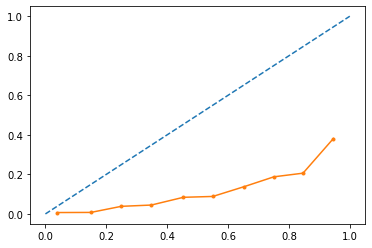

In [33]:
probs=clf_lgbm.predict_proba(x_test_auto)
fop, mpv = calibration_curve(y_test, probs[:,1], n_bins=10, normalize=True)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(mpv, fop, marker='.')
plt.show()

In [51]:
params=itertools.product(np.split(np.repeat(np.arange(1,21),13),20,axis=0),np.arange(1,21))

a=[]
for i,j in params:
    s=dict(w=i,p=j)
    a.append(s)
    

In [52]:
knn=KNeighborsClassifier(n_neighbors=5,algorithm='auto',metric='wminkowski')

In [53]:
n_neighbors=np.arange(1,20)
weights=['uniform','distance']
leaf_size=np.arange(1,400)
p=[None]
metric_params=a
 
kneighbors_param=[{
            'n_neighbors':n_neighbors,
              'weights':weights,
              'leaf_size':leaf_size,
              'p':p,
              'metric_params':metric_params}]

randomized=RandomizedSearchCV(estimator=knn,  param_distributions=kneighbors_param,  n_iter=140,   
                              scoring='balanced_accuracy', cv=skf ,n_jobs=9,random_state=42,verbose=2)

In [54]:
randomized.fit(x_train_auto,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(metric='wminkowski'),
                   n_iter=140, n_jobs=9,
                   param_distributions=[{'leaf_size': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  5...
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])},
                                                           {'p': 8,
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])},
                                                           {'p': 9,
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])},
                                                           {'p': 10,
                                                            'w': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])}, ...],
                                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                         'p': [None],
                                         'weights': ['uniform', 'distance']}],
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [55]:
randomized.best_params_

{'weights': 'distance',
 'p': None,
 'n_neighbors': 17,
 'metric_params': {'w': array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
  'p': 6},
 'leaf_size': 112}

In [270]:
knn=KNeighborsClassifier(n_neighbors=17,p=None,metric='wminkowski',metric_params= {'w': np.array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
  'p': 6},algorithm='auto',leaf_size=112,weights='distance',n_jobs=8)

knn_balanced_test=[]
knn_precision_test=[]
knn_recall_test=[]
knn_auc_test=[]

for train_index, test_index in skf.split(x_train_auto, y_train):
    knn.fit(x_train_auto[train_index],y_train[train_index])
    pred=knn.predict_proba(x_test_auto)
    
    knn_balanced=balanced_accuracy_score(y_test,np.where(pred[:,1]>0.5,1,0))
    knn_balanced_test.append(knn_balanced)
    
    knn_precision=precision_score(y_test,np.where(pred[:,1]>0.5,1,0))
    knn_precision_test.append(knn_precision)
    
    knn_recall=recall_score(y_test,np.where(pred[:,1]>0.5,1,0))
    knn_recall_test.append(knn_recall)
    
    knn_auc=roc_auc_score(y_test,pred[:,1])
    knn_auc_test.append(knn_auc)

knn_balanced_test=np.array(knn_balanced_test)
knn_precision_test=np.array(knn_precision_test)
knn_recall_test=np.array(knn_recall_test)
knn_auc_test=np.array(knn_auc_test)

print(f'mean_balanced_test : {np.mean(knn_balanced_test,axis=0)}+\-{np.std(knn_balanced_test,axis=0)}\nmean_precision_test : {np.mean(knn_precision_test,axis=0)}+\-{np.std(knn_precision_test,axis=0)}\nmean_recall_test : {np.mean(knn_recall_test,axis=0)}+\-{np.std(knn_recall_test,axis=0)}\nmean_AUC_test : {np.mean(knn_auc_test,axis=0)}+/-{np.std(knn_auc_test,axis=0)}')



mean_balanced_test : 0.5309902810334496+\-0.006590757694037286
mean_precision_test : 0.26943484898036757+\-0.03265993915638174
mean_recall_test : 0.08724202626641651+\-0.012923819961947112
mean_AUC_test : 0.6783093013181508+/-0.01195602205806868


In [150]:
clf = TabNetClassifier(n_d=20,n_a=20,
                         n_steps=5,
                         gamma=1.3,
                         lambda_sparse=0.01,
                         momentum=0.06,
                         n_independent=2,
                         n_shared=2,
                         optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_params={"step_size":15,
                                           "gamma":0.96},
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         mask_type='entmax' # "sparsemax"
                         )

Device used : cuda


In [151]:
n_d=[20,80,100]
n_a=[20,80,100]
n_steps=[2,3,4,5,8]

gamma=np.linspace(1,1.5,10)
momentum=np.linspace(0.01,0.4,10)
lambda_sparse=np.linspace(0.001,0.01,10)




forest_param=[{'n_d':n_d,
               'n_a':n_a,
               'n_steps':n_steps,
               'gamma':gamma,
               'momentum':momentum,
               'lambda_sparse':lambda_sparse}]

randomized=RandomizedSearchCV(estimator=clf,  param_distributions=forest_param,  n_iter=40,   
                              scoring='roc_auc', cv=skf ,n_jobs=10,random_state=42,verbose=4)

fit_param=dict(weights=1,max_epochs=50,batch_size=1024,virtual_batch_size=128)

In [152]:
randomized.fit(x_train_auto,y_train,**fit_param)

Device used : cuda
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device

C:\anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

epoch 39 | loss: 0.53433 |  0:01:15s
epoch 40 | loss: 0.5349  |  0:01:17s
epoch 41 | loss: 0.53277 |  0:01:19s
epoch 42 | loss: 0.53411 |  0:01:21s
epoch 43 | loss: 0.53605 |  0:01:23s
epoch 44 | loss: 0.54017 |  0:01:24s
epoch 45 | loss: 0.53451 |  0:01:26s
epoch 46 | loss: 0.5328  |  0:01:28s
epoch 47 | loss: 0.53763 |  0:01:30s
epoch 48 | loss: 0.53422 |  0:01:32s
epoch 49 | loss: 0.53019 |  0:01:33s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=TabNetClassifier(cat_dims=[], cat_idxs=[], lambda_sparse=0.01, mask_type='entmax', momentum=0.06, n_a=20, n_d=20, n_steps=5, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'gamma': 0.96, 'step_size': 15}),
                   n_iter=40, n_...
                   param_distributions=[{'gamma': array([1.        , 1.05555556, 1.11111111, 1.16666667, 1.22222222,
       1.27777778, 1.33333333, 1.38888889, 1.44444444, 1.5       ]),
                                         'lambda_sparse': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ]),
                                         'momentum': array([0.01      , 0.05333333, 0.09666667, 0.14      , 0.18333333,
       0.22666667, 0.27      , 0.31333333, 0.35666667, 0.4       ]),
                                         'n_a': [20, 80, 100],
                                         'n_d': [20, 80, 100],
                                         'n_steps': [2, 3, 4, 5, 8]}],
                   random_state=42, scoring='roc_auc', verbose=4)

In [153]:
randomized.best_params_

{'n_steps': 8,
 'n_d': 100,
 'n_a': 20,
 'momentum': 0.4,
 'lambda_sparse': 0.004,
 'gamma': 1.2222222222222223}

In [154]:
randomized.best_score_

0.7922448679995919

In [155]:
df_randomised_result=pd.DataFrame(randomized.cv_results_)

In [156]:
df_randomised_result.to_csv('param_tabnet.csv')

In [157]:
print(df_randomised_result,'\n\n',randomized.best_params_)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      127.293206      1.546224         0.092353        0.016138   
1      121.866580      0.616533         0.131949        0.060888   
2      290.898421      0.572415         0.301693        0.258296   
3      201.031660      9.053057         0.374897        0.300805   
4      376.914480      7.189615         0.380382        0.262218   
5      140.775815      2.246599         0.104620        0.015518   
6      148.177640      2.326879         0.226293        0.368573   
7      423.381706      4.760215         0.681477        0.609671   
8      239.860616      4.370494         0.256115        0.369978   
9      190.297966      2.420658         0.511632        0.611178   
10     263.760309      2.462987         0.147406        0.016592   
11     142.476658      1.442811         0.092155        0.013697   
12     149.381294      1.470978         0.079988        0.009271   
13     380.024262      3.573573         0.207944

In [240]:

 
balanced_accu_tabnet=[]
auc_tabnet=[]
recall_tabnet=[]
precision_tabnet=[]

balanced_accu_tabnet_test=[]
auc_tabnet_test=[]
recall_tabnet_test=[]
precision_tabnet_test=[]
 
for train_index, test_index in skf.split(x_train_auto, y_train):
    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = x_train_auto[train_index], x_train_auto[test_index]
    Y_train, Y_test = y_train[train_index], y_train[test_index]
    
    
    clf_tab = TabNetClassifier(n_d=100,n_a=20,
                         n_steps=8,
                         gamma=1.2,
                         lambda_sparse=0.004,
                         momentum=0.4,
                         n_independent=2,
                         n_shared=2,
                         optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_params={"step_size":15,
                                           "gamma":0.96},
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         mask_type='entmax' # "sparsemax"
                         )
    clf_tab.fit(X_train, Y_train,
          weights=1,
          max_epochs=300,
          eval_set=[(X_train, Y_train), (X_test, Y_test)],
          eval_name=['train', 'valid'],
          batch_size=1024, virtual_batch_size=128,
          eval_metric=['balanced_accuracy'],patience=20)
    
    preds_proba=clf_tab.predict_proba(X_test)
    
    auc_scoree=roc_auc_score(Y_test,preds_proba[:,1])
    auc_tabnet.append(auc_scoree)
    
    recall_scoree=recall_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    recall_tabnet.append(recall_scoree)
    
    precision_scoree=precision_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    precision_tabnet.append(precision_scoree)
    
    score=balanced_accuracy_score(Y_test,np.where(preds_proba[:,1]>0.5,1,0))
    balanced_accu_tabnet.append(score)
    
    
    preds_proba_test=clf_tab.predict_proba(x_test_auto)
    
    auc_scoree_test=roc_auc_score(y_test,preds_proba_test[:,1])
    auc_tabnet_test.append(auc_scoree_test)
    
    recall_scoree_test=recall_score(y_test,np.where(preds_proba_test[:,1]>0.5,1,0))
    recall_tabnet_test.append(recall_scoree_test)
    
    precision_scoree_test=precision_score(y_test,np.where(preds_proba_test[:,1]>0.5,1,0))
    precision_tabnet_test.append(precision_scoree_test)
    
    score_test=balanced_accuracy_score(y_test,np.where(preds_proba_test[:,1]>0.5,1,0))
    balanced_accu_tabnet_test.append(score_test)
    
balanced_accu_array=np.array(balanced_accu_tabnet)
auc_array=np.array(auc_tabnet)
precision_array=np.array(precision_tabnet)
recall_array=np.array(recall_tabnet)


balanced_accu_array_test=np.array(balanced_accu_tabnet_test)
auc_array_test=np.array(auc_tabnet_test)
precision_array_test=np.array(precision_tabnet_test)
recall_array_test=np.array(recall_tabnet_test)

print(f'balanced_accuracy:{np.mean(balanced_accu_array,axis=0)}+/-{np.std(balanced_accu_array,axis=0)}\nAUC:{np.mean(auc_array,axis=0)}+/-{np.std(auc_array,axis=0)}\nPrecision:{np.mean(precision_array,axis=0)}+/-{np.std(precision_array,axis=0)}\nRecall:{np.mean(recall_array,axis=0)}+/-{np.std(recall_array,axis=0)}')

print(f'balanced_accuracy_test:{np.mean(balanced_accu_array_test,axis=0)}+/-{np.std(balanced_accu_array_test,axis=0)}\nAUC_test:{np.mean(auc_array_test,axis=0)}+/-{np.std(auc_array_test,axis=0)}\nPrecision_test:{np.mean(precision_array_test,axis=0)}+/-{np.std(precision_array_test,axis=0)}\nRecall_test:{np.mean(recall_array_test,axis=0)}+/-{np.std(recall_array_test,axis=0)}')


TRAIN: [    0     1     2 ... 22013 22014 22016] TEST: [   18    23    39 ... 22003 22004 22015]
Device used : cuda
epoch 0  | loss: 1.52893 | train_balanced_accuracy: 0.52448 | valid_balanced_accuracy: 0.52841 |  0:00:02s
epoch 1  | loss: 1.02065 | train_balanced_accuracy: 0.54993 | valid_balanced_accuracy: 0.54457 |  0:00:04s
epoch 2  | loss: 0.69915 | train_balanced_accuracy: 0.70948 | valid_balanced_accuracy: 0.70264 |  0:00:07s
epoch 3  | loss: 0.62009 | train_balanced_accuracy: 0.6837  | valid_balanced_accuracy: 0.65339 |  0:00:09s
epoch 4  | loss: 0.59957 | train_balanced_accuracy: 0.68985 | valid_balanced_accuracy: 0.67929 |  0:00:12s
epoch 5  | loss: 0.57074 | train_balanced_accuracy: 0.68037 | valid_balanced_accuracy: 0.67477 |  0:00:14s
epoch 6  | loss: 0.5492  | train_balanced_accuracy: 0.70485 | valid_balanced_accuracy: 0.68389 |  0:00:16s
epoch 7  | loss: 0.55286 | train_balanced_accuracy: 0.70958 | valid_balanced_accuracy: 0.69025 |  0:00:19s
epoch 8  | loss: 0.54439 | t

epoch 76 | loss: 0.51927 | train_balanced_accuracy: 0.74703 | valid_balanced_accuracy: 0.71638 |  0:03:05s
epoch 77 | loss: 0.51074 | train_balanced_accuracy: 0.74486 | valid_balanced_accuracy: 0.71444 |  0:03:07s
epoch 78 | loss: 0.52163 | train_balanced_accuracy: 0.74949 | valid_balanced_accuracy: 0.70774 |  0:03:10s
epoch 79 | loss: 0.52086 | train_balanced_accuracy: 0.74373 | valid_balanced_accuracy: 0.71236 |  0:03:12s
epoch 80 | loss: 0.53088 | train_balanced_accuracy: 0.74319 | valid_balanced_accuracy: 0.71838 |  0:03:15s
epoch 81 | loss: 0.52491 | train_balanced_accuracy: 0.75    | valid_balanced_accuracy: 0.71394 |  0:03:17s
epoch 82 | loss: 0.51694 | train_balanced_accuracy: 0.74751 | valid_balanced_accuracy: 0.70724 |  0:03:20s
epoch 83 | loss: 0.52105 | train_balanced_accuracy: 0.74797 | valid_balanced_accuracy: 0.71863 |  0:03:22s

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_balanced_accuracy = 0.72853
Best weights from best epoch are automatica

epoch 5  | loss: 0.55763 | train_balanced_accuracy: 0.67402 | valid_balanced_accuracy: 0.65651 |  0:00:14s
epoch 6  | loss: 0.55214 | train_balanced_accuracy: 0.68425 | valid_balanced_accuracy: 0.67301 |  0:00:17s
epoch 7  | loss: 0.55409 | train_balanced_accuracy: 0.71145 | valid_balanced_accuracy: 0.70055 |  0:00:19s
epoch 8  | loss: 0.54903 | train_balanced_accuracy: 0.71074 | valid_balanced_accuracy: 0.70516 |  0:00:21s
epoch 9  | loss: 0.55039 | train_balanced_accuracy: 0.70446 | valid_balanced_accuracy: 0.69555 |  0:00:24s
epoch 10 | loss: 0.54218 | train_balanced_accuracy: 0.72446 | valid_balanced_accuracy: 0.72712 |  0:00:26s
epoch 11 | loss: 0.5378  | train_balanced_accuracy: 0.7141  | valid_balanced_accuracy: 0.71221 |  0:00:29s
epoch 12 | loss: 0.54192 | train_balanced_accuracy: 0.72354 | valid_balanced_accuracy: 0.71044 |  0:00:31s
epoch 13 | loss: 0.54436 | train_balanced_accuracy: 0.72604 | valid_balanced_accuracy: 0.70339 |  0:00:33s
epoch 14 | loss: 0.53949 | train_bala

epoch 31 | loss: 0.51991 | train_balanced_accuracy: 0.73799 | valid_balanced_accuracy: 0.74382 |  0:01:17s
epoch 32 | loss: 0.52616 | train_balanced_accuracy: 0.73763 | valid_balanced_accuracy: 0.73016 |  0:01:19s
epoch 33 | loss: 0.5296  | train_balanced_accuracy: 0.74678 | valid_balanced_accuracy: 0.73968 |  0:01:22s
epoch 34 | loss: 0.52023 | train_balanced_accuracy: 0.73915 | valid_balanced_accuracy: 0.73647 |  0:01:24s
epoch 35 | loss: 0.52531 | train_balanced_accuracy: 0.73788 | valid_balanced_accuracy: 0.73454 |  0:01:27s
epoch 36 | loss: 0.52626 | train_balanced_accuracy: 0.73893 | valid_balanced_accuracy: 0.73329 |  0:01:29s
epoch 37 | loss: 0.51766 | train_balanced_accuracy: 0.73922 | valid_balanced_accuracy: 0.73186 |  0:01:31s
epoch 38 | loss: 0.53048 | train_balanced_accuracy: 0.74364 | valid_balanced_accuracy: 0.72546 |  0:01:34s
epoch 39 | loss: 0.52403 | train_balanced_accuracy: 0.74224 | valid_balanced_accuracy: 0.72836 |  0:01:36s
epoch 40 | loss: 0.51391 | train_bala

epoch 11 | loss: 0.53126 | train_balanced_accuracy: 0.71677 | valid_balanced_accuracy: 0.69811 |  0:00:29s
epoch 12 | loss: 0.53867 | train_balanced_accuracy: 0.71841 | valid_balanced_accuracy: 0.72622 |  0:00:31s
epoch 13 | loss: 0.53867 | train_balanced_accuracy: 0.72105 | valid_balanced_accuracy: 0.71941 |  0:00:33s
epoch 14 | loss: 0.54681 | train_balanced_accuracy: 0.72381 | valid_balanced_accuracy: 0.72622 |  0:00:36s
epoch 15 | loss: 0.52986 | train_balanced_accuracy: 0.73118 | valid_balanced_accuracy: 0.71858 |  0:00:38s
epoch 16 | loss: 0.5427  | train_balanced_accuracy: 0.72908 | valid_balanced_accuracy: 0.7232  |  0:00:41s
epoch 17 | loss: 0.53523 | train_balanced_accuracy: 0.73063 | valid_balanced_accuracy: 0.72174 |  0:00:43s
epoch 18 | loss: 0.53601 | train_balanced_accuracy: 0.72918 | valid_balanced_accuracy: 0.71412 |  0:00:46s
epoch 19 | loss: 0.53569 | train_balanced_accuracy: 0.7276  | valid_balanced_accuracy: 0.71671 |  0:00:48s
epoch 20 | loss: 0.53377 | train_bala

epoch 24 | loss: 0.52979 | train_balanced_accuracy: 0.72815 | valid_balanced_accuracy: 0.71875 |  0:01:01s
epoch 25 | loss: 0.53177 | train_balanced_accuracy: 0.73814 | valid_balanced_accuracy: 0.7217  |  0:01:03s
epoch 26 | loss: 0.53862 | train_balanced_accuracy: 0.73749 | valid_balanced_accuracy: 0.71269 |  0:01:06s
epoch 27 | loss: 0.53385 | train_balanced_accuracy: 0.72803 | valid_balanced_accuracy: 0.70344 |  0:01:08s
epoch 28 | loss: 0.53905 | train_balanced_accuracy: 0.73012 | valid_balanced_accuracy: 0.69236 |  0:01:10s
epoch 29 | loss: 0.53303 | train_balanced_accuracy: 0.73401 | valid_balanced_accuracy: 0.70619 |  0:01:13s
epoch 30 | loss: 0.53651 | train_balanced_accuracy: 0.73368 | valid_balanced_accuracy: 0.71816 |  0:01:15s
epoch 31 | loss: 0.5377  | train_balanced_accuracy: 0.73254 | valid_balanced_accuracy: 0.71678 |  0:01:18s
epoch 32 | loss: 0.5359  | train_balanced_accuracy: 0.73577 | valid_balanced_accuracy: 0.71542 |  0:01:20s
epoch 33 | loss: 0.53638 | train_bala

epoch 36 | loss: 0.5273  | train_balanced_accuracy: 0.73431 | valid_balanced_accuracy: 0.73122 |  0:01:30s
epoch 37 | loss: 0.53534 | train_balanced_accuracy: 0.73535 | valid_balanced_accuracy: 0.74581 |  0:01:32s
epoch 38 | loss: 0.52885 | train_balanced_accuracy: 0.73739 | valid_balanced_accuracy: 0.73835 |  0:01:35s

Early stopping occurred at epoch 38 with best_epoch = 18 and best_valid_balanced_accuracy = 0.74916
Best weights from best epoch are automatically used!
TRAIN: [    0     1     2 ... 22014 22015 22016] TEST: [   11    13    24 ... 21998 22006 22010]
Device used : cuda
epoch 0  | loss: 1.36239 | train_balanced_accuracy: 0.5     | valid_balanced_accuracy: 0.5     |  0:00:02s
epoch 1  | loss: 1.20652 | train_balanced_accuracy: 0.52261 | valid_balanced_accuracy: 0.52565 |  0:00:04s
epoch 2  | loss: 0.68489 | train_balanced_accuracy: 0.64742 | valid_balanced_accuracy: 0.64655 |  0:00:07s
epoch 3  | loss: 0.59342 | train_balanced_accuracy: 0.6313  | valid_balanced_accuracy: 0

epoch 72 | loss: 0.52164 | train_balanced_accuracy: 0.73955 | valid_balanced_accuracy: 0.73147 |  0:02:55s
epoch 73 | loss: 0.52798 | train_balanced_accuracy: 0.74242 | valid_balanced_accuracy: 0.73583 |  0:02:57s
epoch 74 | loss: 0.52206 | train_balanced_accuracy: 0.74334 | valid_balanced_accuracy: 0.73097 |  0:03:00s
epoch 75 | loss: 0.52308 | train_balanced_accuracy: 0.74049 | valid_balanced_accuracy: 0.73097 |  0:03:02s
epoch 76 | loss: 0.52042 | train_balanced_accuracy: 0.74038 | valid_balanced_accuracy: 0.73164 |  0:03:04s
epoch 77 | loss: 0.52169 | train_balanced_accuracy: 0.74067 | valid_balanced_accuracy: 0.7298  |  0:03:07s
epoch 78 | loss: 0.52395 | train_balanced_accuracy: 0.74069 | valid_balanced_accuracy: 0.73784 |  0:03:09s
epoch 79 | loss: 0.52541 | train_balanced_accuracy: 0.74147 | valid_balanced_accuracy: 0.72351 |  0:03:12s
epoch 80 | loss: 0.5276  | train_balanced_accuracy: 0.74112 | valid_balanced_accuracy: 0.72611 |  0:03:14s
epoch 81 | loss: 0.53071 | train_bala

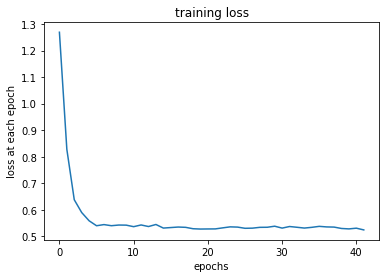

In [181]:
plt.plot(clf_tab.history['loss'])
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('loss at each epoch')
plt.show()

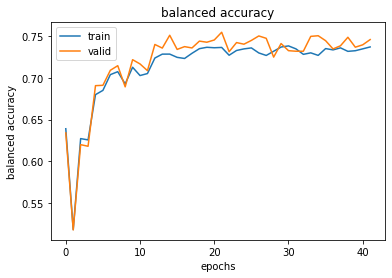

In [182]:
plt.plot(clf_tab.history['train_balanced_accuracy'],label='train')
plt.plot(clf_tab.history['valid_balanced_accuracy'],label='valid')
plt.title('balanced accuracy')
plt.xlabel('epochs')
plt.ylabel('balanced accuracy')
plt.legend(loc='upper left')
plt.show()

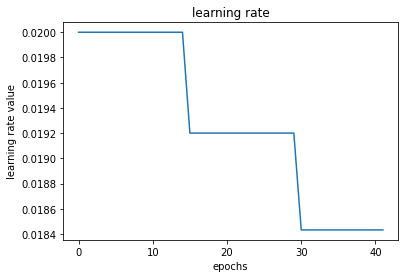

In [183]:
plt.plot(clf_tab.history['lr'])
plt.title('learning rate')
plt.xlabel('epochs')
plt.ylabel('learning rate value')
plt.show()

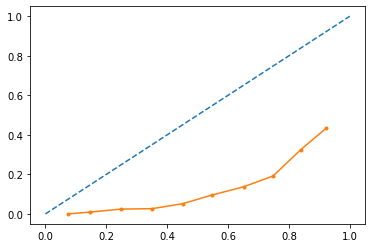

In [45]:
probs=clf_tab.predict_proba(x_test_auto)
fop, mpv = calibration_curve(y_test, probs[:,1], n_bins=10, normalize=True)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(mpv, fop, marker='.')
plt.show()

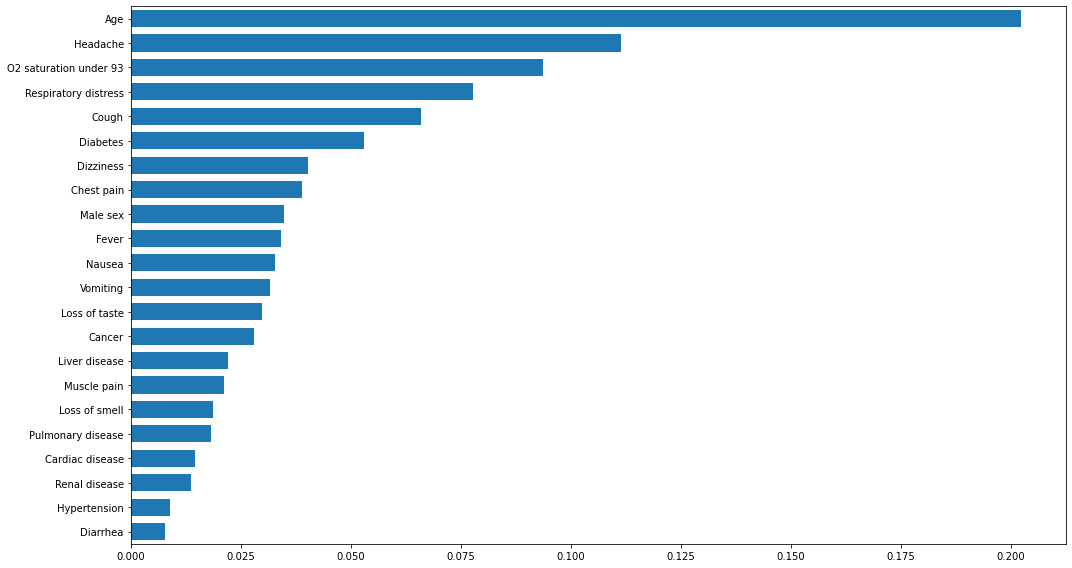

array([0.20234034, 0.03490627, 0.03424428, 0.06583896, 0.02112373,
       0.07786691, 0.0187551 , 0.0297823 , 0.11136447, 0.04034275,
       0.03880738, 0.03286455, 0.03169383, 0.00776469, 0.0935881 ,
       0.02808526, 0.02207248, 0.05309908, 0.01461465, 0.01360245,
       0.01825889, 0.00898355])

In [188]:
tree_importance_sorted_idx = np.argsort(clf_tab.feature_importances_)
tree_indices = np.arange(0, clf_tab.feature_importances_.shape[0]) + 0.5

#tree_labels= df_ext.columns.array[[0,1,4,5,6,10,19,22,27,31,32]]
#tree_labels=tree_labels[1:]

#tree_labels1=tree_labels[:-1]
#tree_labels2=np.append(tree_labels1,['epil0','epil1','epil2','epil3'])

fig,ax1 = plt.subplots(figsize=(15, 8))

ax1.barh(tree_indices,
         clf_tab.feature_importances_[tree_importance_sorted_idx], height=0.7)

ax1.set_yticks(tree_indices)
ax1.set_yticklabels(column_importance[tree_importance_sorted_idx])
ax1.set_ylim((0,clf_tab.feature_importances_.shape[0]))


fig.tight_layout()
plt.show()







clf_tab.feature_importances_

In [120]:
saving_path_name = "./tabnet_model"
saved_filepath = clf_tab.save_model(saving_path_name)
#clf_tab2 = TabNetClassifier()
#clf_tab2.load_model('test/tabnet_model_denoise.zip')

Successfully saved model at ./tabnet_model.zip


In [33]:
explain_matrix, masks = loaded_clf.explain(x_test_denoise)

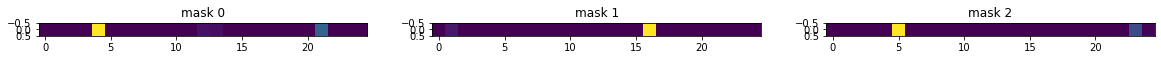

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i])
    axs[i].set_title(f"mask {i}")

In [236]:
#models  selection
# random forest
clf_random=RandomForestClassifier(n_estimators=2829,min_samples_split=0.051,
                                                                min_samples_leaf=0.03628,
                                                               max_features='sqrt',
                                                               max_depth=1832,
                                                               criterion='gini',
                                                               class_weight='balanced_subsample',
                                                               bootstrap=True)

scores_random=cross_validate(clf_random,x_train_auto,y_train,cv=skf,
                             scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

#logistic regression
clf_log_regression=LogisticRegression(penalty='elasticnet',C=7.9,solver='saga',
                                      class_weight='balanced',l1_ratio=0.864,max_iter=900)

scores_log_regression=cross_validate(clf_log_regression,x_train_auto,y_train,cv=skf,
                                      scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

# svm
clf_svc=svm.SVC(C=0.536,kernel='linear',degree=3,gamma=0.34,coef0=4.05,shrinking=True,class_weight='balanced')

scores_svc=cross_validate(clf_svc,x_train_auto,y_train,cv=skf,
                           scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

# knn
knn=KNeighborsClassifier(n_neighbors=17,p=None,metric='wminkowski',
                         metric_params= {'w': np.array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]),
  'p': 6},algorithm='auto',leaf_size=112,weights='distance',n_jobs=8)

scores_knn=cross_validate(knn,x_train_auto,y_train,cv=skf,
                           scoring=('balanced_accuracy','roc_auc','precision','recall'),n_jobs=8)

#lgbm
scores_balanced_lgbm=np.array(balanced_accu_lgbm)
scores_auc_lgbm=np.array(auc_lgbm)
scores_precision_lgbm=np.array(precision_lgbm)
scores_recall_lgbm=np.array(recall_lgbm)

#tabnet
scores_balanced_tabnet=np.array(balanced_accu_tabnet)
scores_auc_tabnet=np.array(auc_tabnet)
scores_precision_tabnet=np.array(precision_tabnet)
scores_recall_tabnet=np.array(recall_tabnet)

# neural net







In [41]:
scores_random.keys()

dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'test_roc_auc', 'test_precision', 'test_recall'])

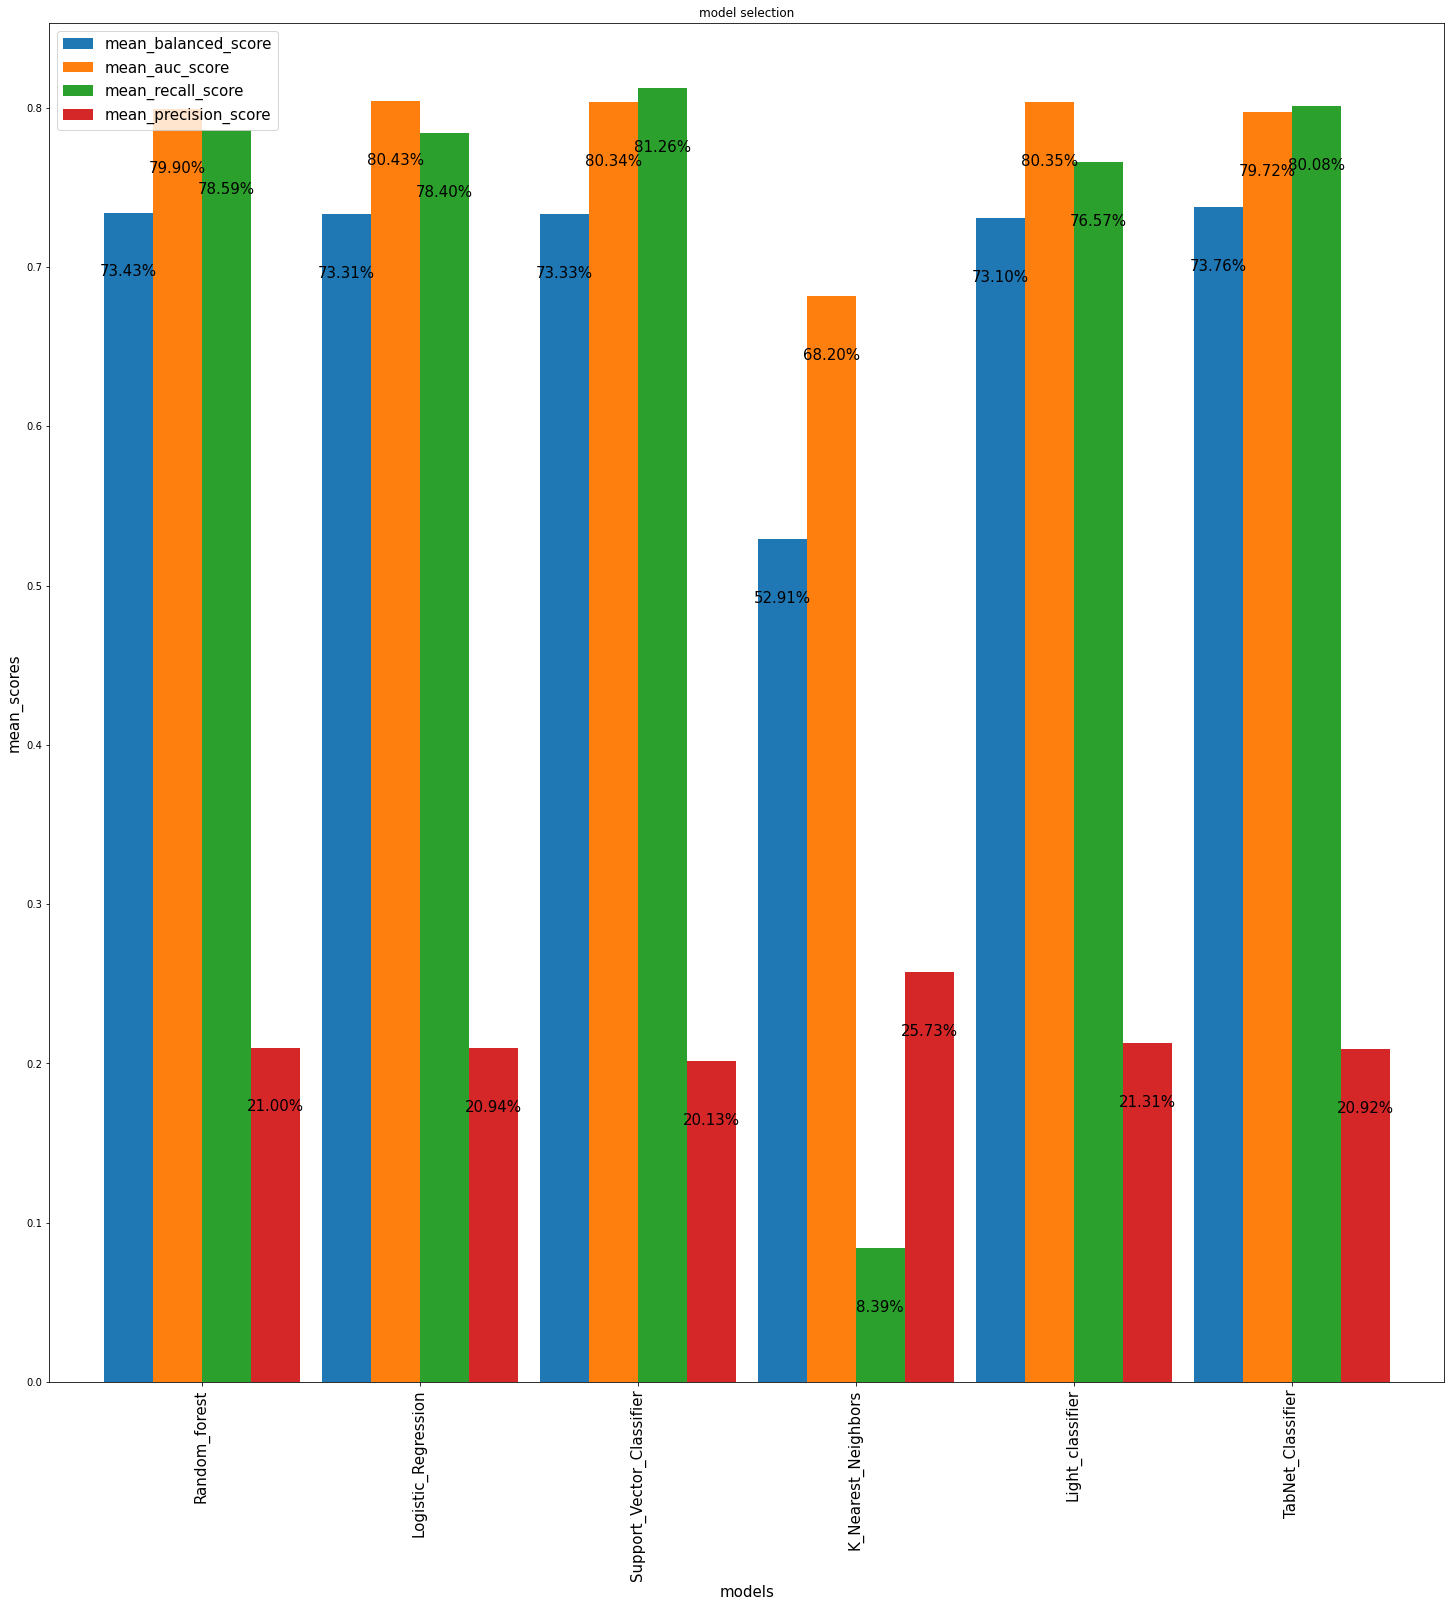

In [237]:
df_models=pd.DataFrame({'mean_balanced_score':[np.mean(scores_random['test_balanced_accuracy'],axis=0),
                                               np.mean(scores_log_regression['test_balanced_accuracy'],axis=0),
                                      np.mean(scores_svc['test_balanced_accuracy'],axis=0),
                                               np.mean(scores_knn['test_balanced_accuracy'],axis=0),
                                      np.mean(scores_balanced_lgbm,axis=0),np.mean(scores_balanced_tabnet,axis=0)],
                        
                        'mean_auc_score':[np.mean(scores_random['test_roc_auc'],axis=0),
                                          np.mean(scores_log_regression['test_roc_auc'],axis=0),
                                      np.mean(scores_svc['test_roc_auc'],axis=0),
                                          np.mean(scores_knn['test_roc_auc'],axis=0),
                                      np.mean(scores_auc_lgbm,axis=0),np.mean(scores_auc_tabnet,axis=0)]   ,
                        
                        'mean_recall_score': [np.mean(scores_random['test_recall'],axis=0),
                                          np.mean(scores_log_regression['test_recall'],axis=0),
                                      np.mean(scores_svc['test_recall'],axis=0),
                                          np.mean(scores_knn['test_recall'],axis=0),
                                      np.mean(scores_recall_lgbm,axis=0),np.mean(scores_recall_tabnet,axis=0)]  ,
                        
                        'mean_precision_score':[np.mean(scores_random['test_precision'],axis=0),
                                          np.mean(scores_log_regression['test_precision'],axis=0),
                                      np.mean(scores_svc['test_precision'],axis=0),
                                          np.mean(scores_knn['test_precision'],axis=0),
                                      np.mean(scores_precision_lgbm,axis=0),np.mean(scores_precision_tabnet,axis=0)] },
                       
                       index=np.array(['Random_forest','Logistic_Regression','Support_Vector_Classifier',
                                       'K_Nearest_Neighbors','Light_classifier','TabNet_Classifier']) )

plot=df_models.plot(kind='bar',rot=90,width=0.9,figsize=(25,25))

for p in plot.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    
    plot.annotate(f'{100*height:.2f}%', (x + 0.5*width, y + height-0.04), ha='center',fontsize=15)
    
plot.set_xticklabels(df_models.index,fontsize=15)    
plt.legend(loc='upper left',fontsize=15)
plt.title('model selection')
plt.xlabel('models',fontsize=15)
plt.ylabel('mean_scores',fontsize=15)
plt.show()

In [277]:
u,p=stats.wilcoxon(scores_recall_tabnet,scores_svc['test_recall'],zero_method='zsplit',mode='approx',alternative='greater')

print(f'wilcoxon:{u}\np-value:{p:.2f}')

wilcoxon:17.5
p-value:0.85


In [61]:
np.array(random_recall_test)

array([0.7879925 , 0.78611632, 0.79174484, 0.79174484, 0.79174484,
       0.78611632, 0.79174484, 0.79362101, 0.78986867, 0.79174484])

In [62]:
np.array(recall_tabnet_test)

array([0.7804878 , 0.77485929, 0.78424015, 0.8011257 , 0.86116323,
       0.8011257 , 0.79174484, 0.7879925 , 0.75234522, 0.8217636 ])

In [176]:
x_test_me=np.repeat(0,22)
x_test_me[0]=34
x_test_me[1]=1
x_test_me[2]=0
x_test_me[3]=0
x_test_me[4]=0
x_test_me[5]=0
x_test_pre_me=column_transfromer_f.transform(x_test_me.reshape(1,-1))
x_test_denoise_me=model.predict(x_test_pre_me)

In [177]:
clf_random.predict_proba(x_test_denoise_me)

array([[0.92999098, 0.07000902]])

In [355]:
print(f'std_tabnet: {np.std(scores_recall_tabnet,axis=0)}\nstd_LightGBM: {np.std(scores_balanced_lgbm,axis=0)}\nstd_logistic: {np.std(log_reg,axis=0)}')

std_tabnet: 0.04334023037317688
std_LightGBM: 0.009606966824919922
std_logistic: 0.014286490061194337
